## AMOD:5440 Data Mining

**Assignment 2**   

Nicholas Hopewell 0496633  
December 8, 2017



**Import Packages:**  

A new package I used which is not part of SciKit or SciPy is called imbalanced learn. This provides many methods for handling imbalanced classfication problems such as providing many different methods for under and over sampling both naturally and synthetically. I also wanted to try different visualization tools so I also used seaborn at different points in the project. I also imported many packages from SciKit learn for various tasks. I describe what they are for in the code and I chose them to impliment the steps outlined in the notebook.  


In [1]:
import csv

# For importing and working with tabular data:

import numpy as np
import pandas as pd

# For summary statistics: 
from scipy import stats

# For visualizations:

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.cm as cm
import seaborn as sns

import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls


# so plots are displayed in line within jupyter notebook
%matplotlib inline

# For processing and Analysis:

# for randomly undersampling the dominant class
from imblearn.under_sampling import RandomUnderSampler
# a simple counter tool
from collections import Counter
#for performning pricipal components analysis
from sklearn.decomposition import PCA
# for encoding categorical features
from sklearn.preprocessing import LabelEncoder 

# for multilayer perceptron net:
from sklearn.neural_network import MLPClassifier
# for cross validation:
from sklearn import cross_validation
# for splitting the data into training and testing:
from sklearn.model_selection import train_test_split
# for reporting the confusion matrix:
from sklearn.metrics import classification_report,confusion_matrix
# for cv again:
from sklearn.model_selection import cross_validate
# report for imbalanced classification
from imblearn.metrics import classification_report_imbalanced
# evaluation metrics including precision, recall, f1, roc, accuracy, and a combined report which includes support
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
# random forest classifyer
from sklearn.ensemble import RandomForestClassifier
# k-means clustering:
from sklearn.cluster import KMeans
# for determining correct number of clusters:
from sklearn.metrics import silhouette_samples, silhouette_score
# for GM model:
from sklearn.mixture import GaussianMixture as GMM  
# for support vector machine
from sklearn.svm import SVC
# for hbdcan
import hdbscan
# for labeling clusters
import sklearn.cluster as cluster
# for the look of the plot if I choose to use or keep basic
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
# for distances when clustering:
from scipy.spatial.distance import cdist, pdist
# cdist = distance between sets of observations
# pdist = pairwise distances between observations in the same set



## National Collision Database

***
This database comes from the Government of Canada's Open Government initiative and contains police-reported motor vehicle collisions on public roads across Canada. All variables are related to collisions which resulted in either a fatality or an injury(non-fatal). These collisions occurred between 1999 and 2014.

***

#### Task: Classification  

The current task is to learn a model which can predict class labels of collisions records in terms of whether the collision resulted in at least one fatality or resulted in injury but no fatalities.   

To investigate accomplish this task, I will use a supervised Artificial Neural Network, and the unsupervised K-Means Clustering and Expectation Maximization algorithms. Finally, I will use 10-fold cross-validation to compare results of these algorithms in terms of how they assign class. 

<br>  


In [2]:
# read csv file into a pandas dataframe indicating that the first row contains column names. 

collisionData = pd.read_csv("/Users/nicho/Desktop/Assignments/Data Mining assignments/Assignment 2/National Collision Database 1999 to 2014.csv", header = 0)

C:\Users\nicho\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning:

Columns (1,2,5,12) have mixed types. Specify dtype option on import or set low_memory=False.



***
Below is a full lsit of the column names. These columns are described in more detail below. 


In [3]:
#  print out a list of all column names

print(list(collisionData))

['C_YEAR', 'C_MNTH', 'C_WDAY', 'C_HOUR', 'C_SEV', 'C_VEHS', 'C_CONF', 'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN', 'C_TRAF', 'V_ID', 'V_TYPE', 'V_YEAR', 'P_ID', 'P_SEX', 'P_AGE', 'P_PSN', 'P_ISEV', 'P_SAFE', 'P_USER']


**Dictionary of Data Elements**  

The data provided fall into three categories: collsion level data elements, vehicle level data elements, and person level data elements.   


*Collision level data elements:*

> * **C_YEAR**: Year  
* **C_MNTH**: Month  
* **C_WDAY**: Day of week  
* **C_HOUR**: Collision hour  
* **C_SEV**:  Collision severity  
* **C_VEHS**: Number of vehicles involved in collision   
* **C_CONF**: Collision configuration  
* **C_RCFG**: Roadway configuration   
* **C_WTHR**: Weather condition  
* **C_RSUR**: Road surface  
* **C_RALN**: Road alignment  
* **C_TRAF**: Traffic control 

*Vehicle level data elements:*

> * **V_ID**: Vehicle sequence number
* **V_TYPE**: Vehicle type
* **V_YEAR**: Vehicle model year  

*Person level data elements:* 

> * **P_ID**: Person sequence number
* **P_SEX**: Person sex
* **P_AGE**: Person age
* **P_PSN**: Person position
* **P_ISEV**: Medical treatment required
* **P_SAFE**: Safety device used
* **P_USER**: Road user class






In [4]:
print("Total rows: {0}".format(len(collisionData)))

Total rows: 5860405


***
The primary issue with this data set is its size; the data set has almost 6 million rows. Reading the file into Python produces a DtypeWarning because the process of guessing data types is very memory demanding. Pandas has guessed the dtypes based on the values of each column. As seen below, Pandas has labelled most of these data types as the general 'object' pandas type (which the native Python type is string). This has been assigned to most columns because they contain both numbers and strings. 
***

In [5]:
collisionData.dtypes

C_YEAR     int64
C_MNTH    object
C_WDAY    object
C_HOUR    object
C_SEV      int64
C_VEHS    object
C_CONF    object
C_RCFG    object
C_WTHR    object
C_RSUR    object
C_RALN    object
C_TRAF    object
V_ID      object
V_TYPE    object
V_YEAR    object
P_ID      object
P_SEX     object
P_AGE     object
P_PSN     object
P_ISEV    object
P_SAFE    object
P_USER    object
dtype: object

***
The **target** feature of the current data is collision severity (whether or not someone died as result of a collision). It would be interesting to learn a model which would help predict which types of collisions are most likely to lead to a fatality on average. The first thing which must be known is the break down of the collision severity variable. Doing this would provide information as to how many collisions resulted in at least on fatality and how many collisions resulted in an injury but no fatalities.
***

In [6]:
# Count frequency of collision occurences. 1 = fatality, 2 = injury, no fatality
collisionData['C_SEV'].value_counts()


2    5761772
1      98633
Name: C_SEV, dtype: int64

In [259]:
# some of the same warnings appear. Running this cell ignores them
import warnings
warnings.filterwarnings("ignore")
# this was the very last cell I added to the notebook. I would never recommend ignoring all warnings
# I did the entire project without these filtered out. The warnings were simple matplot depreciation
# the only important warning is the original one, every other one I dealt with. 

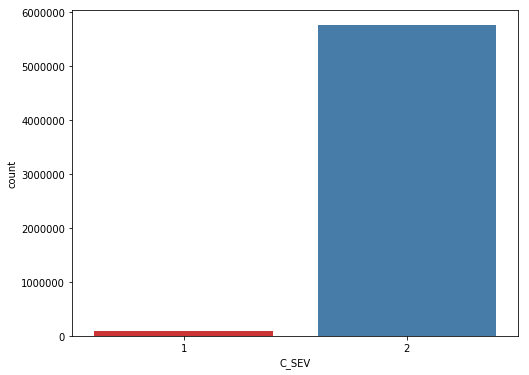

In [262]:

# output plot size
pylab.rcParams['figure.figsize'] = (8, 6)
# seaborn to plot collision severity count
sns.countplot(collisionData['C_SEV'], label='Count', palette="Set1");



**Collision Severity Breakdown:**  

Above is a barchart of the breakdown of the number of collisons which resulted in a fatalty (bar 1 - red) and the number of collisions which resulted in injury but no fatality (bar 2 - blue) between 1999 and 2014.

> * 5,761,772 collisions resulted in injury but no deaths
* 98,633 collisons resulted in at least one death.  
* Ratio of non-fatal to fatal collisions: **58.42  :  1**


## Exploratory Data Analysis and Preprocessing




### Preprocessing Considerations for Classification Models  
  
Each classification model has different strengths, weaknesses, and preprocessing which must be done in order to achieve a decent accuracy.  

> Artificial Neural Networks: 
* Data must be numeric.
* ANNs must be trained on data which does not have missing values - missing values should be removed or replaced.  
* ANNs are sensitive to noise in the training set - this should not be a big concern if using k-fold cross-validation.
* ANNs are sensitive to feature scaling and thus it is highly recommended to scale the data. 

> K-Means Clustering:  
* Outliers influence K-Means as the centriod locations at each iteration represent the mean of the data points which fall within each cluster. 
* Multiple iterations are run until convergence so it can be costly with large data (although overall it is quite efficient). The total run time calculation includes calculating each data points distance to each centroid across each iteration and choosing the centroid with the minimal distance as its cluster. Thus, the calculation includes number of data points, number of dimensions, number of centroids, and number of iterations until convergence.  
 

<br>  

### Preprocessing Considerations for Data Set 

This data set poses many interesting challenges; the seven primary challenges involved with this classifcation problem are: 
> **1.** the size of the data - contains almost 6 million rows and 22 columns   
> **2.** the highly dimensional nature of the data - contains 17 variables some with many levels   
> **3.**  the massive class imbalance of the target variable, over 58:1 in favor of non-fatal collisions  
> **4.** the huge number of missing values - every variable expect year and collision severity have missing data     
> **5.**  the fact that missing values are missing for multiple different reasons - 4 different types of missing data
> **6.** the data has mixed types and a lot of unmapped categorical data  
> **7.** some data needs to be binned before it can be mapped


These challenges will be discussed in more detail below.  

Before any visualizations are done, the data must be significantly reduced by taking a subsample of it.
  
<br>
#### Data Size and Class Imbalance: Sampling
<br>
It is far to expensive and time-consuming to process all of this data with Python so a subset of the data set must be taken. The quality of results taken from sampled data depends largely on whether or not it is representitive of the entire data set. In this classification problem, the target variable of interest is collsion severity (whether or not a fatality occured as result of the collision). Thus, a representitive sample of the data would need to be similar in terms of the proportion of cases where a fatality occured as well as where a fatality did not occur. The problem faced here is that a representative sample would not allow for the training of a model which adequately predicts collision fatality because of the huge imbalance of the number of collisions which resulted in death vs the number of collisions which did not. 

5,761,772 collisions resulted in injury but no deaths while only 98,633 collisons resulted in at least one death. There is a clear imbalance in the class of interest: for every one collision which resulted in fatality there were over 58 (58.42) collisons which did not result in fatality. This is a problem because predicting collisions which led to a fatality are more difficult than predicting collisions which did not lead to a fatality. The model could simply classify all records are non-fatal collisions and obtain quite a good accuracy rating (over 98% of collisions did not result in a fatality). In addition, the model would be biased in favor of the majority class because the algorithm would see many more cases from this class during training. Since the data set is already large we know that collecting more data would not solve this problem.
<br>  
How can this class imbalance problem be overcome? 
 
One possible solution is using an F1-score as the measure of model performance rather than accuracy; this measure is a way of summarizing precision and recall which are two metrics that are very useful to consider when successful detection of of the classes is more significant than the detection of the other class(es). Another possible solutions is to use weights could be used to increase the importance of correctly classfying collisons which led to fatalities but that solution is likely not as good as simply undersampling the dominant class. With this method it would be possible to obtain a class balance for building a classification model which could adequetly predict both non-fatal and fatal collisions. Because fatal collisions are so rare reletive to all collisions, it might be interesting to train an anomaly detection model on this data set. A final option is oversampling the rare class or undersampling the majority class.  

**note:** I won't correct the class unbalanced until later into the analysis after I have done some visualizations.

<br>

*Important sampling considerations:*

> Sampling method: The methods of sampling which need to be considered here are simple random sampling with replacement, without replacement as well as stratified sampling, random over-sampling and random under-sampling.  

> Sample Size: As the size of the sample increases the probability of it being representitive of the original data increases proportionally. That being said, the goal of sampling (to allow the data to be processed efficiently) is lost when taking too large of a sample. The trade off in performance comes at the cost of a potential loss of important information in the data; samples too small reletive to the original data may not adequently represent important patterns or tendencies and thus this important information might be missed. For practical purposes, the sample has to be an adequate size (which is easy due to how large this data set is) but it cannot be too large.

<br>



Because collision fatality is a rare class in this data set, it is critical that this class is adequately represented in the subsample drawn from the data. The best approach here is to utilize stratified sampling where an equal number of records from each class of collision severity are drawn. To do this on a smaller data set one would want to oversample the rare class so that no information is lost. This is not practical in this case because the size of the data set is an issue. In this case, randomly undersampling the dominant class is the best apporach.   
<br>  

*Caveats to random under-sampling:*  

> It is important to know that this sampling method might result in the loss of potentially useful information for building a classification model. In addition, the subsample might be baised in favor of the minority class and thus not a good representation of the data. Although this may have an impacct on results, random undersampling of collisions which did not result in fatality must be done and results should be interpreted within the context of how the subsample was taken.  

<br>  

Random undersampling can be further broken into two methods: 
> * prototype generation
* prototype selection 

In prototype generation the original data points are not used and new data which are similar to the original sample are used. In prototype selection, the orginal is used but the total number of data belonging to the majority class is reduced. Prototype generation methods are particularly tricky because if one resamples in this way before splitting the data for cross-validation, synethetic data has first been generated and duplicate data can be seen in the test set as well as the training set during any one fold of k-fold cross-validation. With each fold, the data in the test set fold is supposed to be 'unseen' to the algorithm; if duplicates are present before cross-validation, data in the test set fold is not neccessarily unseen to the algorithm anymore. To overcome this, it might be an option to use a prototype generation method only on the test data after it has been split and not the test data. This way there would be no duplication of data which poses an issue during cross-validation and might remedy potential over-fitting. I will definately try prototype selection and possibly prototype generation. If I choose both methods I will do so to simply compare results. 

<br>

**Reading in a portion of the data**

First I am going to try to read in only the last 10% of the data set (containing the most recent collisions). The original data contains 5,860,495 rows in total; 10% of this total is 586,040. Thus, when reading in the data, I want to skip the first row up to the 5,274,455th rows (5,860,495 - 586,040 = 5,274,455, or 90% of the data), not including the first row as it contains header information for each column. 

<br>  


In [264]:
# By specifying a range to skiprows I retained only the most recent 10% of the original data

subData = pd.read_csv("/Users/nicho/Desktop/Assignments/Data Mining assignments/Assignment 2/National Collision Database 1999 to 2014.csv", 
                          skiprows=range(1, 5274455))

<br>  
Now, if I print out the head of this smaller data set, notice the year begins at 2013 instead of 1999. This new data has dropped 90% of the older records and retained the most recent collisions to analyze. Now the size of the data has drastically been reduced but Python still gives a DtypeWarning because missing data are substituted with characters.

<br>  


In [265]:
# see first 10 rows
subData.head(10)


C_YEAR C_MNTH C_WDAY C_HOUR  C_SEV C_VEHS C_CONF C_RCFG C_WTHR C_RSUR  \
0    2013      2      1     17      2      3     21     01      1      2   
1    2013      2      1     17      2      3     21     01      1      2   
2    2013      2      1     17      2      3     21     01      1      2   
3    2013      2      1     16      2      2     21     01      1      1   
4    2013      2      1     16      2      2     21     01      1      1   
5    2013      2      1     19      2      2     21     01      1      1   
6    2013      2      1     19      2      2     21     01      1      1   
7    2013      2      1     19      2      2     21     01      1      1   
8    2013      2      1     19      2      2     36     03      1      1   
9    2013      2      1     19      2      2     36     03      1      1   

   ...   V_ID V_TYPE V_YEAR P_ID P_SEX P_AGE P_PSN P_ISEV P_SAFE P_USER  
0  ...      1     01   2003   01     M    47    11      1     02      1  
1  ...      2     01   1998   01     M    35    11      2     02      1  
2  ...      3     01   2007   01     F    27    11      1     02      1  
3  ...      1     01   2004   01     F    69    11      2     02      1  
4  ...      2     01   2008   01     M    35    11      1     NN      1  
5  ...      1     01   2012   01     M    23    11      1     02      1  
6  ...      2     01   2013   01     M    58    11      1     02      1  
7  ...      2     01   2013   02     F    64    13      2     02      2  
8  ...      1     01   2003   01     F    24    11      2     02      1  
9  ...      2     01   2005   01     F    48    11      2     02      1  

[10 rows x 22 columns]

<br>  
Now I will compare the breakdown of collision severity in this subsample to the breakdown in the original data. Recall in the original data everyone one fatal car accident there were over 58 non-fatalty accidents. I would expect this ratio to remain similar in these more recent collisions are the majority of collisions which result in injury do not result in death (fortunately). Although similar, I do expect changes in favor of less fatal collisons compared to non-fatal collisions due to many manufacturing and social awareness facotors experienced most commonly in more recent years. Let's see if this prediction is correct.

<br>  

In [266]:
# Count frequency of collision occurences. 1 = fatality, 2 = injury, no fatality
subData['C_SEV'].value_counts()

2    577198
1      8753
Name: C_SEV, dtype: int64

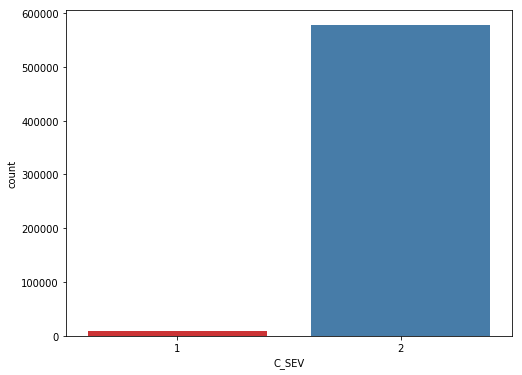

In [267]:

#  Using seaborn, create plot for collision severity

sns.countplot(subData['C_SEV'], label='Count', palette="Set1");


**Collision Severity Breakdown: subData**  

Above is a barchart of the breakdown of the number of collisons which resulted in a fatalty (bar 1 - red) and the number of collisions which resulted in injury but no fatality (bar 2 - blue).
This data only invloves collisions from 2013 and 2014.

> * 577,198 collisions resulted in injury but no deaths
* 8,753 collisons resulted in at least one death.  
* Ratio of non-fatal to fatal collisions: **65.94  :  1**




As expected, the of non-fatal to fatal collisions is noticibly larger due to the fact that more people are likely driving newer cars on average (compared to drivers in 1999 to mid 2000's) which most likely have better safety ratings/standards, undergo more scrutinous quality control, and have better build qualities. Simply by looking at the head of the subsample we can see that it seems a lot of cars were built from mid 2000's to very recent. If we compared these newer cars to cars driven in 1999 which might have been made in the 80's we would surely see that the more common cars on the roads were much less safe to drive than the cars driven aroudn 2013-2014. This coupled with increased awareness and education about road safety hazards such as the use of cellphones while driving (which used to be very common and is much less common in recent years), seems to have resulted in an interesting outcome. In recent years it seems, of all collisions which result in injury, a lesser proportion of these collisions result in at least on fatality. Where the complete data set contained over 58 non-fatal collisions for every 1 fatal collision, this subsample of the data contains just under 66 non-fatal collisions for every 1 fata collision. This suggest that data towards the earliest years (1999-mid 2000's) had a smaller ration, perhaps closer to about 50:1. This is great news for drivers and a sign of progress we have made over time, but it also has an influence on the classification problem at hand. As result of sampling only the newest records, the fatal class (which was a tiny minority even in the original data) is even more rare in the subsample. This means the imbalance of classes has got even more lop-sided in favor of accidents which did not result in a fatality. As previously mentioned, this will be overcome by undersampling non-fatal collisions.

<br>  


#### Missing Data: Deletion and Replacement
<br>  
This mix of data types has to do with how missing values are labelled in this data set. There is a lot of missing data in this data set. Additionally, missing values are missing for different reasons: some missing data are expected to be missing (the data was not supposed to be gathered) while other missing data was simply not recorded or could not be recorded for some reason (unknown). Below are the different ways missing values are coded in this data set: 

> * U = Uknown  
* X = Jurisdiction does not provide this data element
* Q = Choice is other than the preceding values
* N = Data element is not applicable  

As seen from these descriptions, some forms of missing data can simply be treated as data which was not supposed to be gathered. Any data fields containing 'X' or 'N' represent data which was not supposed to be gathered and this can be replaced with np.NaN. Data fields which contain 'U' are more interesting, these cases represent data which is missing for some other (unknown) reason. These data should have been recorded but for some reason were not; replacing the data in these fields might be a consideration.  Data fields containing 'Q' are very tricky because these data were recorded but their values did not fit the range of possible values determined the related attribute. For instance, collision configuration possible values contain the majority of common configurations of vehicle collsions (rear-end collisions, head-on collisions, roll-overs, right-angle collisions, hitting a stationary object etc.) but not all collisions follow these more common configurations. As it is not practical to represent every possible unique collision configurations, cases which do not fall into any of these configurations are represented with 'Q'. Replacing collected data with np.NaN seems unintuitive (the data is not completely missing). That being said, in this case I know the data cannot be replaced or interpolated from any other values because it is known that the these data fields contain something other than the values contained within a feature. Ultimately, the semantics of these data is unknown and it would be categorically incorrect to replace them with anything other than NaN values.  

The only unresolved missing data now are the data represented with 'U', the rest will be replaced with NaN. The question is whether these values should also be replaced with NaN or some other value. If I had more experience what I would consider doing is clustering the data and replacing missing values with the values of the nearest data points. Because these data are categorical, I would consider replacing 'U' fields with the mode of the feature. Since taking the mean does not make sense for categorical values, using the most frequently occuring value for replacement would be acceptable. The important part is to consider wether or not the data is missing completely at random (MCAR). If there data were missing completely at random there would be no systematic explaination for the data to be missing. That being said, a lot of the missing data in the current data set might be explained by other data. For instance, perhaps data for collision configuration is more likely to be unknown if the accident involved only one car and the driver died as result of the crash (they could not give information and this information could not be reliably gathered by responders). Furthermore, hit and run scenarios pose an even more interesting scenario. If a driver flead the scene of an accident, we would expect their vehicle information as well as information about their age and sex to be unknown. For these reasons, I do not think there are grounds to justify that the data is missing completely at random (which would give me justification to replace these values with the mode).  

After careful consideration, I believe it is best to replace all 4 types of missing values with np.NaN. drop rows with missing values, and see how many records are retained in the process. First, I want to see how many field in the data set are blank:

<br>  

In [268]:
# Sum total number of missing values in each column. These values are blank, not coded with N,X,U, or Q:
subData.isnull().sum()

C_YEAR    0
C_MNTH    0
C_WDAY    0
C_HOUR    0
C_SEV     0
C_VEHS    3
C_CONF    0
C_RCFG    0
C_WTHR    0
C_RSUR    0
C_RALN    0
C_TRAF    0
V_ID      0
V_TYPE    0
V_YEAR    0
P_ID      0
P_SEX     0
P_AGE     0
P_PSN     0
P_ISEV    0
P_SAFE    0
P_USER    0
dtype: int64

<br>  
The data set has a lot of missing values with labels but only 3 blank values.  

Once all missing data labeled with 'X', 'N', 'U', 'Q' are replaced with NaN values, the true amount of missing data in this subsample will be known. 

<br>  

  
Considering this subsample contains just under 580,000 records, this can be used to first gage whether some features contain so much missing data that the entire column should be dropped as it would be meaningless to use for classifcation. One feature that sticks out is 'P_SAFE' which includes information about the safety device used by individuals involved in the collision (no sefety device or child restraint used, saftey device or child restraint used, helmet worn, reflective clothing worn, helmt and reflective clothing worn - for motorcyclists/bicyclists, other safety device used, or no safety device used). This feature has 122,825 missing data points. Although this feature has a lot of missing data, I do not think it is ever appropriate to drop an entire column unless it has almost no useable data. No matter what the column was, it might be critical to this analysis. In this case, the use of a safety is likely a good predictor of fatality (they are, in fact, called safety devices) and should no be removed. 

Even once rows with missing values are removed, the sample size is still quite large so no new concerns have presented themselves. I will drop rows with missing values and then use this refined subsample for my analysis. I considered using a threshold where I would only drop rows which had at 5 of more missing values but because neural networks should be trained on data without missing values I will simply drop all such rows.

<br>  

In [269]:
# find all strings representing missing data and replace with numpy.NaN

subData.replace(['X', 'XX', 'XXX', 'XXXX'], [np.NaN, np.NaN, np.NaN, np.NaN], inplace = True)
subData.replace(['N', 'NN', 'NNN', 'NNNN'], [np.NaN, np.NaN, np.NaN, np.NaN], inplace = True)
subData.replace(['Q', 'QQ', 'QQQ', 'QQQQ'], [np.NaN, np.NaN, np.NaN, np.NaN], inplace = True)
subData.replace(['U', 'UU', 'UUU', 'UUUU'], [np.NaN, np.NaN, np.NaN, np.NaN], inplace = True)

In [270]:
# now see how much missing data there is:
subData.isnull().sum()

C_YEAR         0
C_MNTH        50
C_WDAY        54
C_HOUR      4152
C_SEV          0
C_VEHS        55
C_CONF     49892
C_RCFG     55223
C_WTHR      8726
C_RSUR     23101
C_RALN     36783
C_TRAF     37065
V_ID           8
V_TYPE     30480
V_YEAR     58466
P_ID        1192
P_SEX      34073
P_AGE      42352
P_PSN      21047
P_ISEV     39942
P_SAFE    122825
P_USER     27286
dtype: int64

In [271]:
# drop rows with missing values
subData = subData.dropna()

In [272]:
# confirm rows have been dropped:
subData.isnull().sum()

C_YEAR    0
C_MNTH    0
C_WDAY    0
C_HOUR    0
C_SEV     0
C_VEHS    0
C_CONF    0
C_RCFG    0
C_WTHR    0
C_RSUR    0
C_RALN    0
C_TRAF    0
V_ID      0
V_TYPE    0
V_YEAR    0
P_ID      0
P_SEX     0
P_AGE     0
P_PSN     0
P_ISEV    0
P_SAFE    0
P_USER    0
dtype: int64

In [273]:
# Count frequency of collision occurences. 1 = fatality, 2 = injury, no fatality
subData['C_SEV'].value_counts()

2    326050
1      4346
Name: C_SEV, dtype: int64

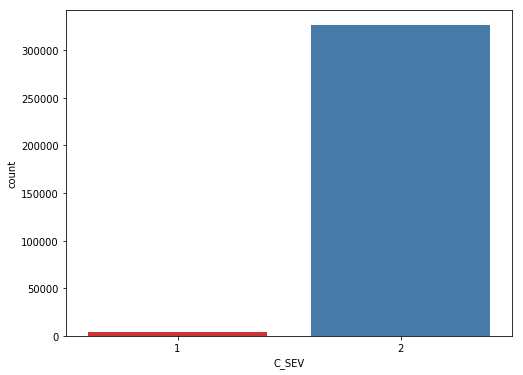

In [274]:
#  Using seaborn, create plot for collision severtiy
sns.countplot(subData['C_SEV'], label='Count', palette="Set1");

**Collision Severity Breakdown: subData - \*REFINED\***  

Above is a barchart of the breakdown of the number of collisons which resulted in a fatalty (bar 1 - red) and the number of collisions which resulted in injury but no fatality (bar 2 - blue).
This data is refined from the first subsample which included only collisions from 2013 and 2014, now with rows which contained missing values dropped.

> * 326,050 collisions resulted in injury but no deaths
* 4,346 collisons resulted in at least one death.  
* Ratio of non-fatal to fatal collisions: **75.01  :  1**

Percisely what I hypothesized earlier about collisions which resulted in fatality being more likely to have missing values appears to be the case. After dropping rows with missing values the class imbalance has once again become more extreme. Now for every 1 fatal collision there are over 75 non-fatal collisions in the retained sample. What does this mean in practical terms? I think this outcome must be considered when interpreting results from any model build from this data. It seems by first taking a subsample of only the most recent collisions and then refining that sample by removing rows with missing values, I have abstracted from the raw data in two steps. This abstraction has had a quantitative impact on the break down of the collision severity of this retained sample.

**Why I think this is okay:** One might argue that this refined data set is bias in some way. Perhaps there is something in common with the vehical collisions which resulted in fatality AND have no missing information associated with them. This is impossible to pin down but I would argue another interpretation. I saw that fatal collisions across Canada (reletive to all reported collisions which at least produced an injury) seemed to be going down over the most recent years. I speculated that this had to do with imporved vehical safety standards and driver education/laws such as banning the use of cell phones while driving. Considering this data set stops at 2014 and it is currently almost 2018, I would aruge that perhaps this ratio is quite representitive of collisions today, assuming the downward trend of fatal collisions has continued. Perhaps this is introducing an unfair assumption, but it is, at the very least, food for thought.  

**Why do I care about this ratio?** One might say that I shouldn't care so much about the breakdown of the class labels since I am going to make the class label ratio 1:1 with sampling methods. Why I think it is important to consider is because this breakdown informs the implementation of different performance metrics and models. Perhaps I could compare random undersampling to no sampling with an F1 measure. Perhaps I could try to apply an anomaly detection model to the data if the ratio were very extreme. In addition, I think it is always important to keep the nature of the data in mind as it was before and after each stage of preprocessing

***
#### Get columns into proper dtypes:

Recall that Python classified almost all of the columns as objects because they contained mixed types, specifically strings. The string values were the missing data which were labeled as 'X','N','Q', and 'U'. Now that these missing data have been dropped, I can fix the dtypes of the columns.  

First I will need to recode males and females in the P_SEX column (labeled as 'M' and 'F') as this is the only column left with string values. 
 


In [275]:
# recode males ('M') as 1 and females ('F') as 2
subData['P_SEX'] = subData['P_SEX'].replace(['M','F'],['1','2'])

In [276]:
subData['P_SEX'].value_counts()

1    173804
2    156592
Name: P_SEX, dtype: int64

This data set contains information regarding 173,804 males and 156,592 females, now labeled as 1 and 2 respectively. From everything we know about car accidents it is not surprising the sample contains more males than females as males are statistically more likely to drive recklessly.  

Now I can convert the columns to their proper dtypes:

In [277]:
# Convert each column improperly classified as object dtypes to integer dtypes
subData['C_MNTH'] = subData.C_MNTH.astype(np.int64)
subData['C_WDAY'] = subData.C_WDAY.astype(np.int64)
subData['C_HOUR'] = subData.C_HOUR.astype(np.int64)
subData['C_VEHS'] = subData.C_VEHS.astype(np.int64)
subData['C_CONF'] = subData.C_CONF.astype(np.int64)
subData['C_RCFG'] = subData.C_RCFG.astype(np.int64)
subData['C_WTHR'] = subData.C_WTHR.astype(np.int64)
subData['C_RSUR'] = subData.C_RSUR.astype(np.int64)
subData['C_RALN'] = subData.C_RALN.astype(np.int64)
subData['C_TRAF'] = subData.C_TRAF.astype(np.int64)
subData['V_ID'] = subData.V_ID.astype(np.int64)
subData['V_TYPE'] = subData.V_TYPE.astype(np.int64)
subData['V_YEAR'] = subData.V_YEAR.astype(np.int64)
subData['P_ID'] = subData.P_ID.astype(np.int64)
subData['P_SEX'] = subData.P_SEX.astype(np.int64)
subData['P_AGE'] = subData.P_AGE.astype(np.int64)
subData['P_PSN'] = subData.P_PSN.astype(np.int64)
subData['P_ISEV'] = subData.P_ISEV.astype(np.int64)
subData['P_SAFE'] = subData.P_SAFE.astype(np.int64)
subData['P_USER'] = subData.P_USER.astype(np.int64)

In [278]:
# check to make sure dtypes were changed:
subData.dtypes

C_YEAR    int64
C_MNTH    int64
C_WDAY    int64
C_HOUR    int64
C_SEV     int64
C_VEHS    int64
C_CONF    int64
C_RCFG    int64
C_WTHR    int64
C_RSUR    int64
C_RALN    int64
C_TRAF    int64
V_ID      int64
V_TYPE    int64
V_YEAR    int64
P_ID      int64
P_SEX     int64
P_AGE     int64
P_PSN     int64
P_ISEV    int64
P_SAFE    int64
P_USER    int64
dtype: object

It looks like all the columns are now the proper dtype.
***

#### Inconsistent Data  

<br>
Before moving on, I want to check for data entry errors by seeing whether the data falls within the proper range which they ought to fall. I will look at the minimum and maximum values for each feature while referecing my data dictionary.

<br> 
* Min values:


In [279]:
#Get the minimum value of each column:
subData.apply(min)

C_YEAR    2013
C_MNTH       1
C_WDAY       1
C_HOUR       0
C_SEV        1
C_VEHS       1
C_CONF       1
C_RCFG       1
C_WTHR       1
C_RSUR       1
C_RALN       1
C_TRAF       1
V_ID         1
V_TYPE       1
V_YEAR    1911
P_ID         1
P_SEX        1
P_AGE        1
P_PSN       11
P_ISEV       1
P_SAFE       1
P_USER       1
dtype: int64

<br>
All of these minimum values seem correct. 'C_HOUR' does have a possible 0 value which represents collisions which occured between midnight to 12:29 am. 'P_PSN' (person position) does begin at 11 representing the driver position. The oldest car to be involved in a collision was made in 1911, let's see if they survived the collision. 

<br>

In [280]:
# select only records where the year built of the vehicle was 1911
subData.loc[subData['V_YEAR'] == 1911]

C_YEAR  C_MNTH  C_WDAY  C_HOUR  C_SEV  C_VEHS  C_CONF  C_RCFG  C_WTHR  \
402327    2014       6       1      14      2       2      21       2       1   
402328    2014       6       1      14      2       2      21       2       1   

        C_RSUR   ...    V_ID  V_TYPE  V_YEAR  P_ID  P_SEX  P_AGE  P_PSN  \
402327       1   ...       1       1    1911     1      1     57     11   
402328       1   ...       1       1    1911     2      2      6     13   

        P_ISEV  P_SAFE  P_USER  
402327       1      13       1  
402328       1       2       2  

[2 rows x 22 columns]

<br>
Looks like this collision took place in June 2014 and involved a 57 year old male and 6 year old female driving in the car. They both survived with no injuries while the driver (male) was not wearing a seat belt and the passenger (female) was in a child contraint.  

One might look at this and say the data is not tidy because information about the same collision is stored in more than one row. The database is actually about the individuals involved in the collisions, not the collisions overall. So each row is not neccessarily one seperate collision but rather one unique individual. 

To read more see Haldey Wickhams 'Tidy Data' paper.  

Another unfortunate peice of information provided here is that the youngest individual(s) who was involved in a collision was 1 year old. 

<br>

* Max values:

In [281]:
# Get the maximum value of each column:
subData.apply(max)

C_YEAR    2014
C_MNTH      12
C_WDAY       7
C_HOUR      23
C_SEV        2
C_VEHS      57
C_CONF      41
C_RCFG      10
C_WTHR       7
C_RSUR       9
C_RALN       6
C_TRAF      18
V_ID        47
V_TYPE      23
V_YEAR    2015
P_ID        93
P_SEX        2
P_AGE       99
P_PSN       98
P_ISEV       3
P_SAFE      13
P_USER       5
dtype: int64

All of these max values seem fine. One thing that is suspect to me is the max value 57 in the 'C_VEHS' column. This means that a collision occured that involved 57 vehicles. I guess this is possible but very rare; I imagine this would be a case where a tractor trailor lost control and caused a huge collision (or something of that nature). 

In [282]:
# select only records where number of vehicles involved equals 57
subData.loc[subData['C_VEHS'] == 57]

C_YEAR  C_MNTH  C_WDAY  C_HOUR  C_SEV  C_VEHS  C_CONF  C_RCFG  C_WTHR  \
298359    2014       1       3       8      2      57      21       1       4   
298367    2014       1       3       8      2      57      21       1       4   
298369    2014       1       3       8      2      57      21       1       4   
298370    2014       1       3       8      2      57      21       1       4   
298371    2014       1       3       8      2      57      21       1       4   
298372    2014       1       3       8      2      57      21       1       4   
298387    2014       1       3       8      2      57      21       1       4   
298388    2014       1       3       8      2      57      21       1       4   
298397    2014       1       3       8      2      57      21       1       4   

        C_RSUR   ...    V_ID  V_TYPE  V_YEAR  P_ID  P_SEX  P_AGE  P_PSN  \
298359       3   ...      10       8    2014     1      1     53     11   
298367       3   ...      17       1    2013     2      2     73     13   
298369       3   ...      19       8    2014     1      1     59     11   
298370       3   ...      20       1    2003     1      1     20     11   
298371       3   ...      21       8    2008     1      1     35     11   
298372       3   ...      22       8    2011     1      1     46     11   
298387       3   ...      37       8    2005     1      1     34     11   
298388       3   ...      38       8    2001     1      1     49     11   
298397       3   ...      47       8    2005     1      1     61     11   

        P_ISEV  P_SAFE  P_USER  
298359       2       2       1  
298367       2       2       2  
298369       1       2       1  
298370       2       2       1  
298371       2       2       1  
298372       2       2       1  
298387       2       2       1  
298388       2       2       1  
298397       2       2       1  

[9 rows x 22 columns]

<br>  

Looks like the databse does not contain all information regarding individuals inolved in this collision which did infact involve a few tractor trailers. Everyone involed (whos records I have) survived.  

It is also interesting to note that the max value seen in the columns 'C_RCFG' (roadway configuration in which collision occured) is 10 which represents a collision which happened on an express lane of a freeway system. The max possible value for this column is 12, so no data in this subsample contains information about a collision which occured on a collector lane of a freeway (11) nor a transfer lane of a freeway (12).  

In addition, the oldest individual(s) to be involved in a collision was 99 years old. 

<br> 

* Ranges:

In [283]:
# Get the range of each column:
subData.apply(lambda x: x.max() - x.min())

C_YEAR      1
C_MNTH     11
C_WDAY      6
C_HOUR     23
C_SEV       1
C_VEHS     56
C_CONF     40
C_RCFG      9
C_WTHR      6
C_RSUR      8
C_RALN      5
C_TRAF     17
V_ID       46
V_TYPE     22
V_YEAR    104
P_ID       92
P_SEX       1
P_AGE      98
P_PSN      87
P_ISEV      2
P_SAFE     12
P_USER      4
dtype: int64

<br> 

The ranges all make sense (which I have already deduced).  

In conclusion, there appears to be no inconsistent data which would I suspect was entered incorrectly. 

<br> 

**Mode and Counts**
<br>  
It is good to capture important information about the data in a concise summary one or a few numbers. A lot of summary statistics (such as the mean) are not applicable to categorical data. Modes and counts are applicable to categorical data, however. 

This data set contains a lot of interesting features which bring a lot of curiosities to mind. 

 * Modes:

 The first thing I want to look at are the most frequently occuring values for each feature.

In [284]:
# Get the mode of each feature
subData.apply(stats.mode)

C_YEAR    ([2014], [166317])
C_MNTH       ([10], [32520])
C_WDAY        ([5], [56012])
C_HOUR       ([16], [31635])
C_SEV        ([2], [326050])
C_VEHS       ([2], [211529])
C_CONF      ([21], [118940])
C_RCFG       ([2], [171693])
C_WTHR       ([1], [239596])
C_RSUR       ([1], [227904])
C_RALN       ([1], [261869])
C_TRAF      ([18], [171889])
V_ID         ([1], [178255])
V_TYPE       ([1], [298964])
V_YEAR     ([2007], [25227])
P_ID         ([1], [232547])
P_SEX        ([1], [173804])
P_AGE         ([18], [8427])
P_PSN       ([11], [231607])
P_ISEV       ([2], [184487])
P_SAFE       ([2], [309850])
P_USER       ([1], [225533])
dtype: object

It looks like the month of October, Fridays, and the window of time between 4-5pm saw the most collisions in 2013 and 2014. Although I did not expect October to see the most collisions, Friday between 4 and 5pm makes a lot of sense because this is a time when everyone is rushing to get home for the weekend and it would make sense that most collisions occur during rush-hour. 

Not surprisingly, most collisions involved 2 vehicles and the most common type of collision was a rear-end collision. Student drivers are taught in drivers-ed that the most common accidents often occur from behind you as distracted drivers fail to stop in time or a sudden change in traffic flow causes one vehicle to stop abruptly, not allowing vehicles behind enough time to react accordingly. The majority of collisions happened at intersections which again is no surprise because these are higgly congested areas which see traffic moving in at least 4 different directions. 

In terms of weather conditions, the majority of collisions occured on clear, sunny days in dry conditions. This might be surprising but I do not personally find this surprising. When weather conditions are worse, people take extra precautions and drive much more safely and public services clean roadways for drivers (when the weather is really bad, people don't drive at all). On the other hand, drives drive a lot more carelessly and recklessly on nice days. That being said, clear days to not neccessarily mean road conditions are clear. 

As previously discussed, the fact that more males were involved in collisions is not surprising because we drive more recklessly on average. It is also not surprising that the so many collisions involved individuals the age of 18. A lot of teens begin to drive around 16 and start to gain more confidence (and cockiness) around 18 or 19. Yougn adults are at a very risky age where their driving experience has not caught up to their confidence levels and they do consider the importance of precautions and the impacts of reckless driving. 

Finally, on a more positive note, it seems like most individuals involved in collisions were using a safety device. If not, I am sure the number of fatal collisions would be far greater. 


* Counts:

 I have already done multiple counts of the breakdown of collision severity for the entire original dataset, the first subsample, and then finally the refined subsample and compared the breakdown for each sample.  
 
 Going into counts in too much detail is not very meaningful because it is better to visualize counts for categorical data because there are not as many intersting visualization choices when you have mostly categorical data. 


***
Before I complete all the preprocessing which must be done, it would be useful to visualize the data to gain some insights about collisions in Canada between 2013 and 2014. 
***

#### Visualizations 
 

<br>  

Keep in mind that my data is almost entirely categorical so my visualization options are limited compared to if I had a lot of mixed data types.  

I choose to look at some time-series plots as well as bar plots and factor plots. Some of the bar and factor plots do not look nice at first because of the large imbalance of records which fall into each categories levels. This being said, it is understandable that this would be the case as the nature of the categories produce such data. For instance, if one visualized the type of vehicle individuals were driving when they were involved in a collision, chances are most of those vehicle types would be stanard passenger cars as opposed to trucks and buses because most vehicles on the road are cars.
Furthermore, I chose to look at some time series plots because I thought that some of the features of the dataset related to time of day and time of year might be important for classifying collision severity.

<br>  

Populating the interactive namespace from numpy and matplotlib


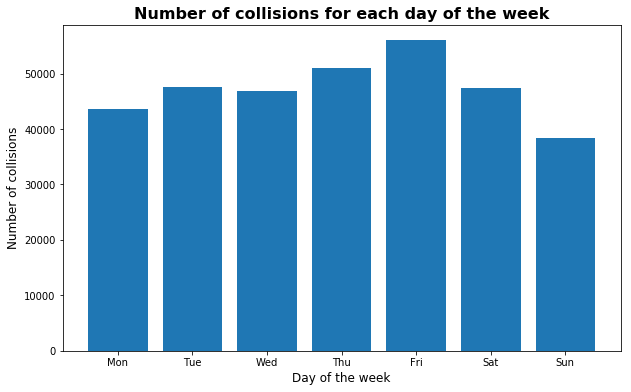

In [285]:
# to set parameters in line
%pylab inline

# set plot size of first plot
pylab.rcParams['figure.figsize'] = (10, 6)

# count number of collision records for each week
weekly_count = subData.groupby('C_WDAY').C_WDAY.count()
day_of_week = weekly_count.index
count = weekly_count.values

# Make a bar plot of weekly collision counts
plt.bar(day_of_week, count)
plt.xticks(day_of_week, ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Number of collisions for each day of the week', fontsize=16,fontweight='bold')
plt.xlabel('Day of the week', fontsize = 12)
plt.ylabel('Number of collisions', fontsize = 12)
plt.show()


Here we see the number of collisions going up slghtly as the work week passes, reaching its worst on Friday. On Friday's a lot of people are rushing home from work or going away somewhere for the weekend causing more traffic and likely more aggressive driving. Sunday's see the least amount of accidents likely because people tend to stay in on Sunday and relax with their families. 


In [286]:
# Add new date column for time series displays

subData['DATE'] = subData['C_YEAR'].astype(str) + '-' + subData['C_MNTH'].astype(str)

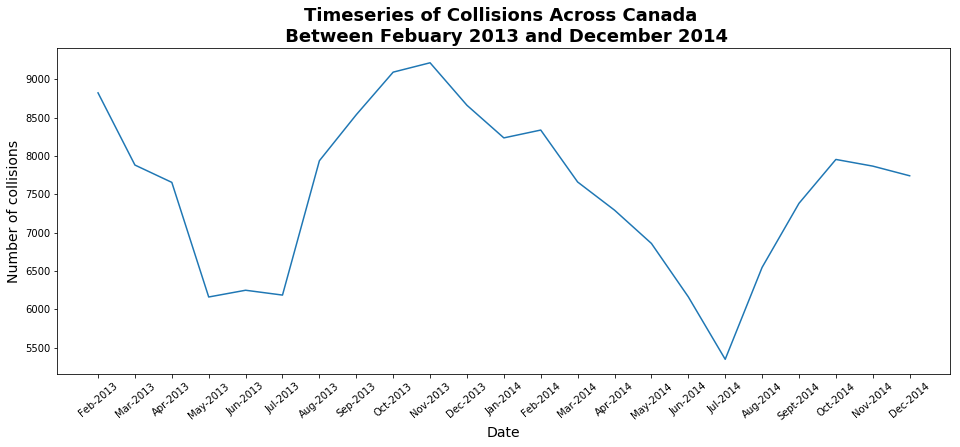

In [308]:
# figure output size
pylab.rcParams['figure.figsize'] = (16, 6)
# only males and group by date to get counts by date
yearly_collisions = subData[subData.P_SEX == 1].groupby('DATE').DATE.count()
# index of the above object
dateCols = yearly_collisions.index
# plot yearly collision index and associated values
plt.plot(yearly_collisions.index, yearly_collisions.values)
# label the x-axis ticks
plt.xticks(dateCols, ['Feb-2013', 'Mar-2013', 'Apr-2013', 'May-2013', 'Jun-2013', 'Jul-2013', 'Aug-2013', 'Sep-2013', 'Oct-2013',
                      'Nov-2013','Dec-2013', 'Jan-2014', 'Feb-2014', 'Mar-2014', 'Apr-2014', 'May-2014', 'Jun-2014', 'Jul-2014',
                      'Aug-2014', 'Sept-2014', 'Oct-2014', 'Nov-2014', 'Dec-2014'], rotation=40) # so the labels can fit
# main, x and y axis labels
plt.title('Timeseries of Collisions Across Canada \n Between Febuary 2013 and December 2014', fontsize=18,fontweight='bold')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Number of collisions', fontsize = 14)
plt.show() # show plot

Above is a plot of the number of collisions for each month between February 2013 and December 2014. There seems to be more collisions which have occured in the colder months perhaps due to road conditions and visibilty. The large drop at July 2014 might be an artifact of data cleaning. Such a low number proportional to just a few months on either side is suspicious. That being said, there seems to be a downwards trend of collisions towards the summer months for both years. 

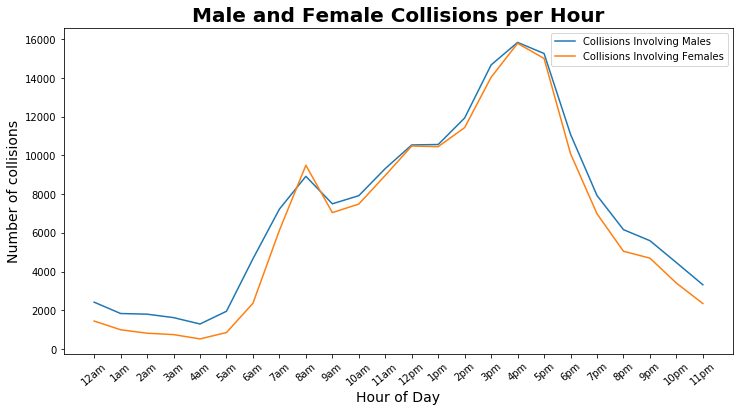

In [318]:
# figure output size
pylab.rcParams['figure.figsize'] = (12, 6)
# save counts of male collisons groupi by hour of day
male_hours_of_collisions = subData[subData.P_SEX == 1].groupby('C_HOUR').C_HOUR.count()
# save counts of female collisons groupi by hour of day
female_hours_of_collisions = subData[subData.P_SEX == 2].groupby('C_HOUR').C_HOUR.count()
# the index of the above objects for plotting
hour_of_dayM = male_hours_of_collisions.index
hour_of_dayF = female_hours_of_collisions.index
# plot the index and the associated values, giving a label to include in the legend
plt.plot(male_hours_of_collisions.index, male_hours_of_collisions.values, label='Collisions Involving Males')
# plot the index and the associated values, giving a label to include in the legend
plt.plot(female_hours_of_collisions.index, female_hours_of_collisions.values, label='Collisions Involving Females')
# label the x-ticks, rotating for fit.
plt.xticks(hour_of_dayM, ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am', '10am', '11am',
                          '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm', '11pm'], rotation=40)
# find best location for legend with most white space
pylab.legend(loc='best')
# main, x and y axis titles
plt.title('Male and Female Collisions per Hour', fontsize=20,fontweight='bold')
plt.xlabel('Hour of Day', fontsize = 14)
plt.ylabel('Number of collisions', fontsize = 14)
plt.show()


The above plot shows the amount of collisions per hour for both males and females. Not surprisingly more collisions occur at rush hour on the way home from work as well as in the morning on the way to work. It is also noticible that the amount of collisions spike again around lunch when people are on break. The day time trends of collisions for males and females is very similar expect one can see a noticable difference at very early and late hours. Men seem to get into more collisions during these hours perhaps because more men are driving during these hours. This might have something to do with the type of job they work or perhaps men on average have longer commutes to work. It might also be the case that some men, especially young men, drive at night recklessly for recreation.   

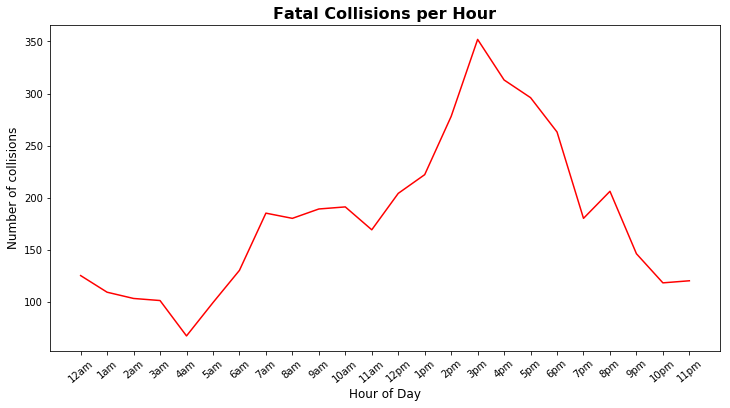

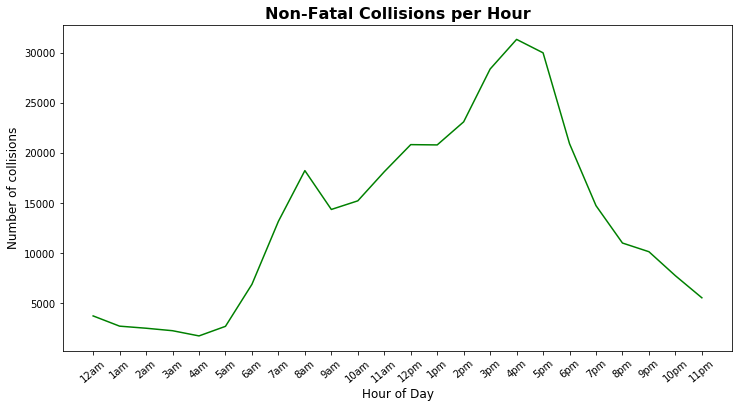

In [319]:
# count of fatal collisions by hour of day
hours_of_collision = subData[subData.C_SEV == 1].groupby('C_HOUR').C_HOUR.count()
# index of the stored values
hour_of_day = hours_of_collision.index
# plot the index and the values, changing line colour to red
plt.plot(hours_of_collision.index, hours_of_collision.values, label='Number of Fatal Collisions per Hour', color = 'red')
# label the ticks of the x-axis, rotating for space
plt.xticks(hour_of_day, ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am', '10am', '11am',
                        '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm', '11pm'], rotation=40)
#main, x and y axis titles
plt.title('Fatal Collisions per Hour', fontsize=16,fontweight='bold')
plt.xlabel('Hour of Day', fontsize = 12)
plt.ylabel('Number of collisions', fontsize = 12)
plt.show()

# count of non-fatal collisions by hour of day
hours_of_collision2 = subData[subData.C_SEV == 2].groupby('C_HOUR').C_HOUR.count()

#  plot index and associated values with green line
plt.plot(hours_of_collision2.index, hours_of_collision2.values, label='Number of Non-Fatal Collisions per Hour', color = 'green')
# label tick marks of x-axis, rotating for space
plt.xticks(hour_of_day, ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am', '10am', '11am',
                        '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm', '11pm'], rotation=40)
# main, x and y axis titles
plt.title('Non-Fatal Collisions per Hour', fontsize=16,fontweight='bold')
plt.xlabel('Hour of Day', fontsize = 12)
plt.ylabel('Number of collisions', fontsize = 12)
plt.show()

Above are plots of fatal and non-fatal accidents for each hour of the day. These plots could not be properly overlaid because the number of non-fatal collisions are orders of magnitude greater than fatal collisions (as seen in the values of the y-axes). 

Not surprisingly, it appears more fatal collisions occur at very late and very early hours when people are tried and possibly driving dangerously or simply not paying attention. 







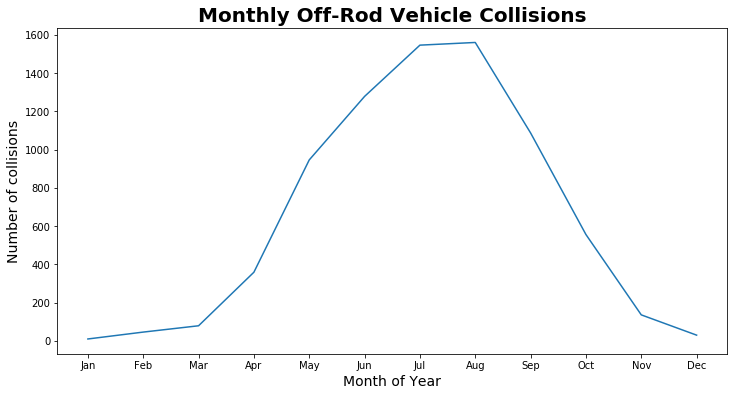

In [320]:
# count of offroad vehicle collisions grouped by month
moto_hours_of_collisions = subData[subData.V_TYPE == 14].groupby('C_MNTH').C_MNTH.count()
# store index of values
month_of_year = moto_hours_of_collisions.index
# plot index and values
plt.plot(moto_hours_of_collisions.index, moto_hours_of_collisions.values)
# change x axis tick labels
plt.xticks(month_of_year, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# main, x and y axis titles
plt.title('Monthly Off-Rod Vehicle Collisions', fontsize=20,fontweight='bold')
plt.xlabel('Month of Year', fontsize = 14)
plt.ylabel('Number of collisions', fontsize = 14)
plt.show()


Above is a plot of collisions per month involing off-road vehicles. These vehicles seem to follow an inverse trend comared to the overall monthly collision trends seen from the original time-series plot. This is obviously because off-road vehicles are driven in the warmer months especially towards the end of the summer when people realize they do ont have much good weather left in the year. This is probably why most off-road vehicle collisions occcured in August.

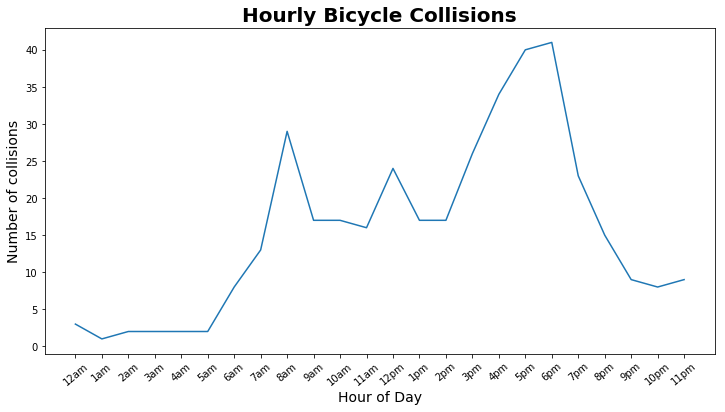

In [321]:
# count of bike collisions grouped by hour of day
bike_hours_of_collisions = subData[subData.V_TYPE == 17].groupby('C_HOUR').C_HOUR.count()
# plot index and values without storing - same outcome
plt.plot(bike_hours_of_collisions.index, bike_hours_of_collisions.values, label='Monthly Collisions Involving Bicycles')
# edit x axis tick labels, roating for space
plt.xticks(hour_of_day, ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am', '10am', '11am',
                        '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm', '11pm'], rotation=40)
# change main, x and y axis titles
plt.title('Hourly Bicycle Collisions', fontsize=20,fontweight='bold')
plt.xlabel('Hour of Day', fontsize = 14)
plt.ylabel('Number of collisions', fontsize = 14)
plt.show()

Hourly bike collisions show a more dramatic trend which is similar to hourly collisions in general expect slightly shifted over towards the later hours which a much more noticile increase in collisions around noon. This shift towards the later hours likely because bikers take longer to get home. Also, while the number of cars on the roads begins to drasticalyl decrease after rush hour, perhaps this decrease occurs later for bike traffic because some people ride their bikes for excercise once they arive home. 

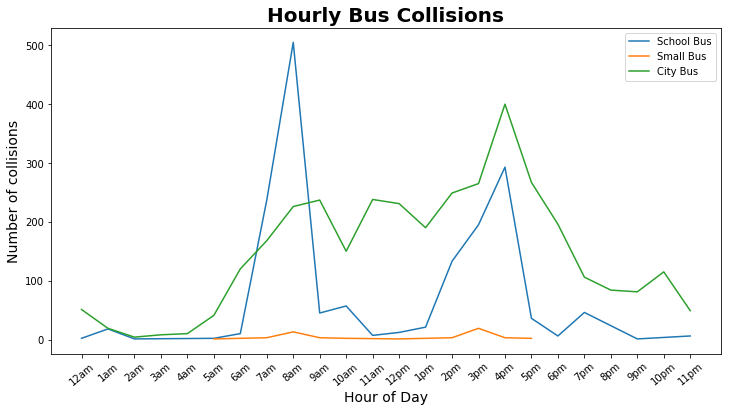

In [322]:
# count of schoolbus collisions grouped by hour of day
schoolbus_hours__of_collision = subData[subData.V_TYPE == 9].groupby('C_HOUR').C_HOUR.count()
# count of smallbus collisions grouped by hour of day
smallbus_hours__of_collision = subData[subData.V_TYPE == 10].groupby('C_HOUR').C_HOUR.count()
# count of city bus collisions grouped by hour of day
citybus_hours__of_collision = subData[subData.V_TYPE == 11].groupby('C_HOUR').C_HOUR.count()

# plot index and values of each assigning appropriate labels to all three 
plt.plot(schoolbus_hours__of_collision.index, schoolbus_hours__of_collision.values, label='School Bus')
plt.plot(smallbus_hours__of_collision.index, smallbus_hours__of_collision.values, label='Small Bus')
plt.plot(citybus_hours__of_collision.index, citybus_hours__of_collision.values, label='City Bus')
# edit x-axis tick labels
plt.xticks(hour_of_day, ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am', '10am', '11am',
                         '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm', '11pm'], rotation=40)

# assign legend position to best location based on white space
pylab.legend(loc='best')

# edit main, x and y axis titles
plt.title('Hourly Bus Collisions', fontsize=20,fontweight='bold')
plt.xlabel('Hour of Day', fontsize = 14)
plt.ylabel('Number of collisions', fontsize = 14)
plt.show()

Above is a plot of hourly bus collisions involving school buses, small buses, and city buses. It is interesting that school buses actually show a similar but reversed trend in collisions compared to overall collisions. Where overall collisions peak later in the day around rush hour, school buses see a huge peak in the morning on the way to school. Perhaps this has to do with excited children in the morning distracting the driver. Also interesting is that city buses do not see a noticable peak in the morning despite city traffic being very congested in the mornings. Perhaps this has to do with lower speeds of travel in city centers during congested times of day. 

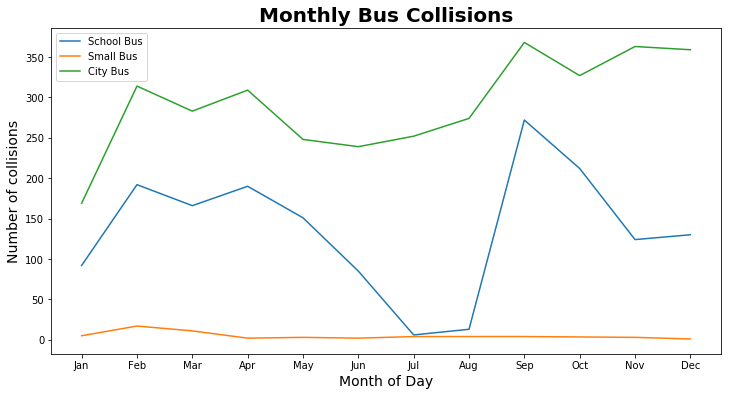

In [323]:
# count of schoolbus collisions grouped by month of year
schoolbus_hours__of_collision = subData[subData.V_TYPE == 9].groupby('C_MNTH').C_MNTH.count()
# count of smallbus collisions grouped by month of year
smallbus_hours__of_collision = subData[subData.V_TYPE == 10].groupby('C_MNTH').C_MNTH.count()
# count of city bus collisions grouped by month of year
citybus_hours__of_collision = subData[subData.V_TYPE == 11].groupby('C_MNTH').C_MNTH.count()

# plot index and values of each, assigning appropriate titles to each
plt.plot(schoolbus_hours__of_collision.index, schoolbus_hours__of_collision.values, label='School Bus')
plt.plot(smallbus_hours__of_collision.index, smallbus_hours__of_collision.values, label='Small Bus')
plt.plot(citybus_hours__of_collision.index, citybus_hours__of_collision.values, label='City Bus')
# edit x axis tick labels
plt.xticks(month_of_year, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# set legend to best location based on white space
pylab.legend(loc='best')
# edit main, x and y axis titles
plt.title('Monthly Bus Collisions', fontsize=20,fontweight='bold')
plt.xlabel('Month of Day', fontsize = 14)
plt.ylabel('Number of collisions', fontsize = 14)
plt.show()

Above are monthly bus collisions. Monthly city bus collisions do not seem to fall off as much in the warmer months as seen for overall collisions but over all the trend is similar. Obviously school buses do no run nearly as much in the summers that is why there is a large drop off in school bus collicions around June. 


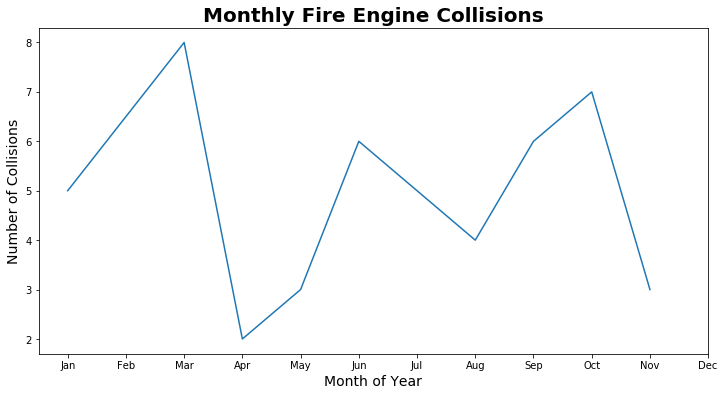

In [312]:
# count of fire engine collisons grouped by month of year
fire_hours__of_collision = subData[subData.V_TYPE == 21].groupby('C_MNTH').C_MNTH.count()

#plot index and values
plt.plot(fire_hours__of_collision.index, fire_hours__of_collision.values)
# change x axis tick mark labels
plt.xticks(month_of_year, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# edit main, x and y axis titles
plt.title('Monthly Fire Engine Collisions', fontsize=20,fontweight='bold')
plt.xlabel('Month of Year', fontsize = 14)
plt.ylabel('Number of Collisions', fontsize = 14)
plt.show()

The above plot portrays montly collisions involving fire engines. This is interesting because the number of collisions involving fire engines also gives insight into which months might see the most fires. If the trend in fire enginge collisions follows the trend seen for all vehicle collisions then the times in which fire engines are most active (on the road) are also the times when they are most likely to be involved in collisions. There seems to be very noticible peaks in March, June, and October. It si hard to say why these peaks might be this way but it most likely is just noise as the number of collisions involving fire enginers is so low overall that although the plot seems to show a trend this is probably just random variation. 

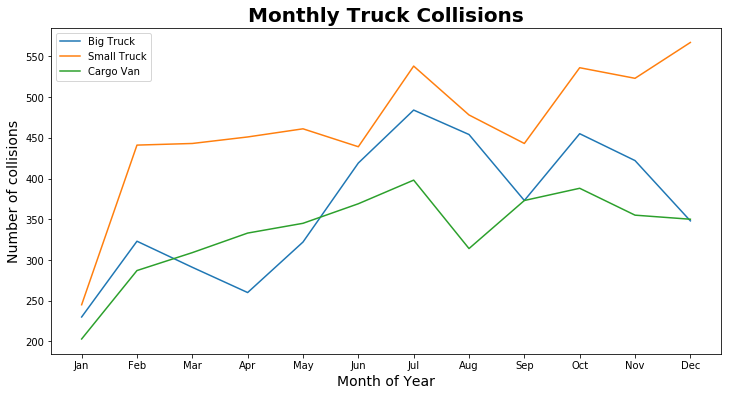

In [313]:
# counts of large trucks grouped by month of year
bigtruck_days_of_collisions = subData[subData.V_TYPE == 7].groupby('C_MNTH').C_MNTH.count()
# counts of small trucks grouped by month of year
smalltruck_days_of_collisions = subData[subData.V_TYPE == 6].groupby('C_MNTH').C_MNTH.count()
# counts of cargo vans grouped by month of year
cargovan_days_of_collisions = subData[subData.V_TYPE == 5].groupby('C_MNTH').C_MNTH.count()
# index of one of the above, all the same
day_of_week = bigtruck_days_of_collisions.index

# plot the index and values of each object
plt.plot(bigtruck_days_of_collisions.index, bigtruck_days_of_collisions.values, label='Big Truck')
plt.plot(smalltruck_days_of_collisions.index, smalltruck_days_of_collisions.values, label='Small Truck')
plt.plot(cargovan_days_of_collisions.index, cargovan_days_of_collisions.values, label='Cargo Van')

# change x axxis tick labels
plt.xticks(month_of_year, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# put legend in best location based on white space
pylab.legend(loc='best')

# add main, x and y axis titles
plt.title('Monthly Truck Collisions', fontsize=20,fontweight='bold')
plt.xlabel('Month of Year', fontsize = 14)
plt.ylabel('Number of collisions', fontsize = 14)
plt.show()

The trend in monthly truck collisions is hard to interpret with the missing data at January 2013. Overall, it appears the number of collisions increases towards the later months of the year.  

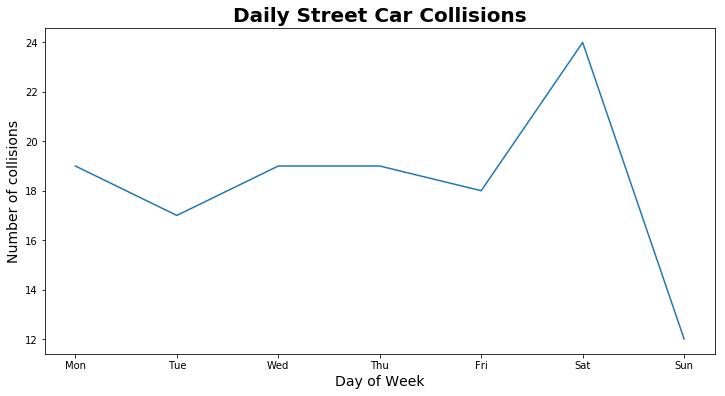

In [314]:
# count of street car collisions grouped by day of week
streetcar_days_of_collisions = subData[subData.V_TYPE == 23].groupby('C_WDAY').C_WDAY.count()
# index of values above
day_of_week = streetcar_days_of_collisions.index
# plot index and values
plt.plot(streetcar_days_of_collisions.index, streetcar_days_of_collisions.values)
# change x axis tick labels
plt.xticks(day_of_week, ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# main, x and y axis titles
plt.title('Daily Street Car Collisions', fontsize=20,fontweight='bold')
plt.xlabel('Day of Week', fontsize = 14)
plt.ylabel('Number of collisions', fontsize = 14)
plt.show()

Overall, there were very few street car collisions in 2013 and 2014. The spike on Saturdays is misleading as it is only a small number of collisions more compared to Wednesdays and Thursdays.

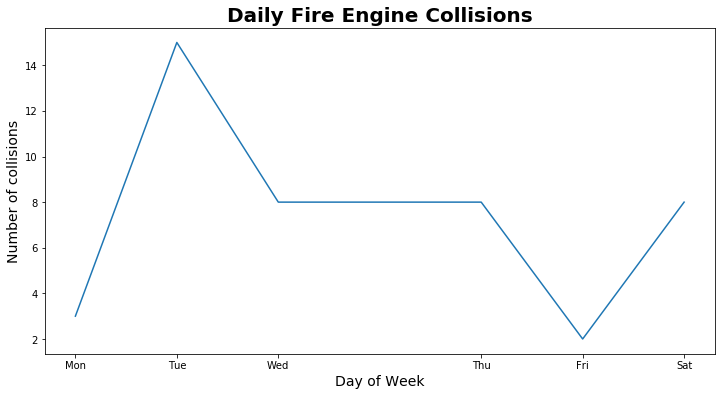

In [315]:
# count of fire engine collision grouped by day of the week.
fire_days_of_collision = subData[subData.V_TYPE == 21].groupby('C_WDAY').C_WDAY.count()
# index of values
day_of_week = fire_days_of_collision.index
# plot index and values
plt.plot(fire_days_of_collision.index, fire_days_of_collision.values)
# change x tick labels
plt.xticks(day_of_week, ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# main, x and y axis titles
plt.title('Daily Fire Engine Collisions', fontsize=20,fontweight='bold')
plt.xlabel('Day of Week', fontsize = 14)
plt.ylabel('Number of collisions', fontsize = 14)
plt.show()

Again, there are quite few overall fire engine collisions with the least amount on Fridays which is surprising. 


Text(0,0.5,'Count')

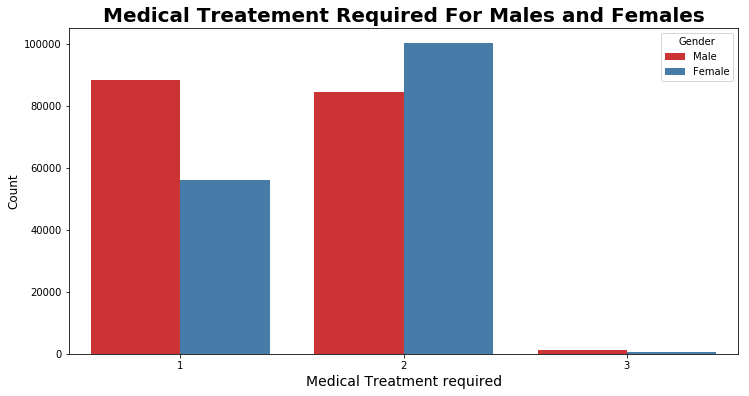

In [316]:
# count plot of medical tratment required split by sex
P1 = sns.countplot(x="P_ISEV", hue="P_SEX", data=subData, palette="Set1");
# for legend:
titles = ["Male", 'Female']
# format legend with titles and location
plt.legend(titles, ncol=1, loc='upper right', title = 'Gender');
# main, x and y axis titles
plt.title('Medical Treatement Required For Males and Females', fontsize=20,fontweight='bold')
plt.xlabel('Medical Treatment required', fontsize = 14)
plt.ylabel('Count', fontsize = 12)

The above plot shows counts of personal injury/medical treatment required for males and females who were involved in a collision. It seems that fewer males were injured as result of a collision but more males died from collisions. Of those who were injured and required medical treatment, more of these individuals were females than males. Perhaps this has to do with the types of collisions men and women get into, the types of vehicles they drive, and possibly their body size and build. It would be interesting to know which type of injury amongst women was the most common. Perhaps that would give insights into the breakdown of personal injury severity.

Text(0,0.5,'Count')

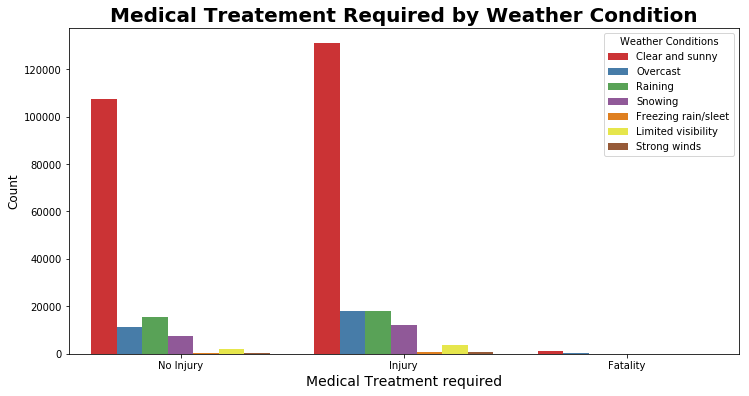

In [317]:
# figure output size
pylab.rcParams['figure.figsize'] = (12, 6)
# counts of medical treament required split by weather conditions
P2 = sns.countplot(x="P_ISEV", hue="C_WTHR", data=subData, palette="Set1");
# titles for legend
titles = ["Clear and sunny", "Overcast", "Raining", "Snowing", "Freezing rain/sleet", "Limited visibility", "Strong winds"]
# format legend with titles and location
plt.legend(titles, ncol=1, loc='upper right', title = "Weather Conditions");
# change tick labels of x axis
P2.set_xticklabels(["No Injury", "Injury", "Fatality"])
# main title, x  and y axis titles
plt.title('Medical Treatement Required by Weather Condition', fontsize=20,fontweight='bold')
plt.xlabel('Medical Treatment required', fontsize = 14)
plt.ylabel('Count', fontsize = 12)



Overall, most collisions occur on clear days possibly because people are more cautious on days with worse weather conditions. Furthermore, Canada has mroe clear days than any other weather condition so it makes sense that more collisions overall happen on these days. When comparing collisions where a person was injured and required medical attention to collisions were no injury and no medical attention was required, a few things stand out. Although the vertical bars do not appear to differ by much for the all conditions apart from clear and sunny days, considering the x-axis is scaled so high due to how tall the clear conditions bar is, there are real differences to look at. It seems injuries were almost twice as likely to occur when it was snowing and about a third more likely during overcast days. It is also apparent that limited visibility had an influence; more collisions which occured during conditions with limited visibility resulted in injury than those which did not. 

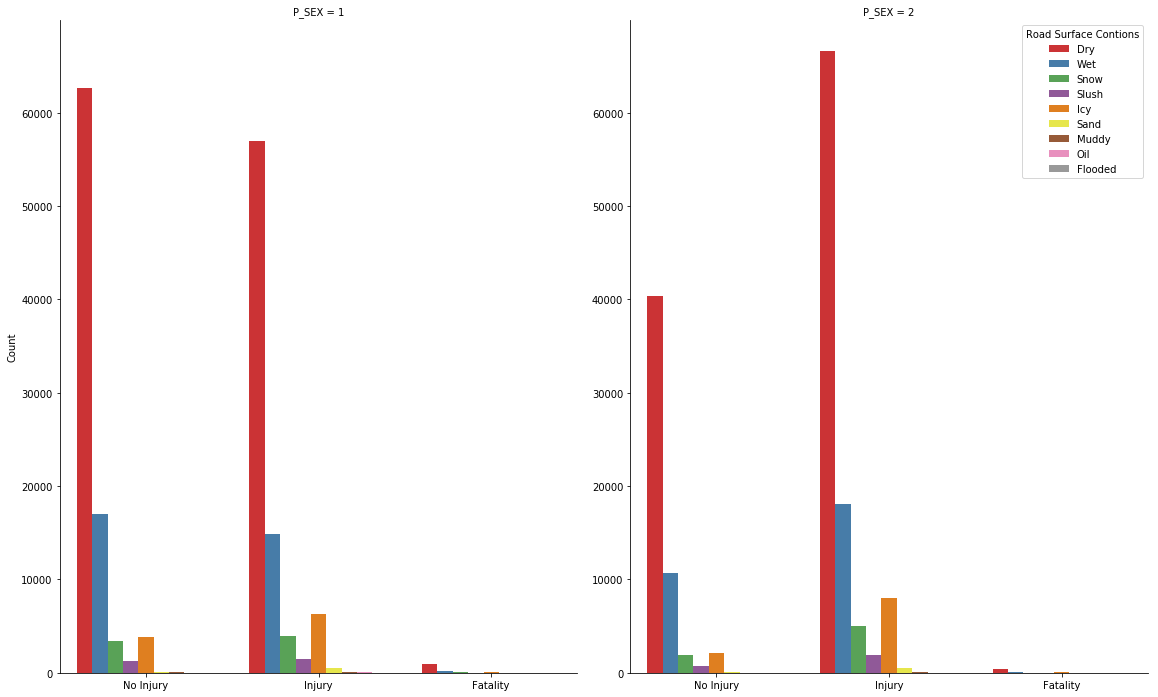

In [324]:
# factor plot of medical treatment required, road surface contisions, sex
P3 = sns.factorplot(x="P_ISEV", hue="C_RSUR", col = 'P_SEX',
               data=subData, kind="count", size=10, aspect=.8,
               palette="Set1", legend = False);
# titles for legend
titles = ["Dry", "Wet", "Snow", "Slush", "Icy", "Sand", "Muddy", "Oil", "Flooded"]
P3.set_axis_labels("", "Count") # y label
P3.set_xticklabels(["No Injury", "Injury", "Fatality"]) # label x tick marks
# format legend with titles and location
plt.legend(titles, ncol=1, loc='upper right', title = "Road Surface Contions");


Women get in proportionally more collisions resulting in injury in dry, wet and icy conditions. Overall, when are more often injured as result of a collision than men are, with propotionally less no injury collisions experienced in almost all road surface conditions. 

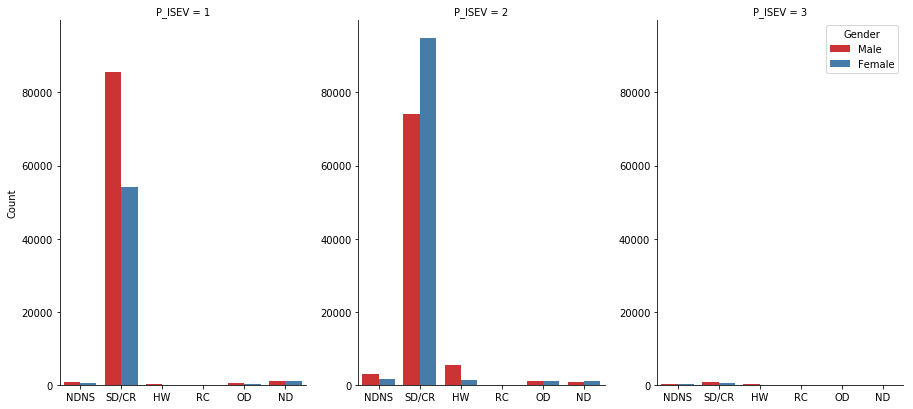

In [301]:
# store facttor plot of saftey device used, sex, and medical treatment required in object
P4 = sns.factorplot(x="P_SAFE", hue="P_SEX", col="P_ISEV",
                    data=subData, kind="count",
                   size=6, aspect=.7, palette="Set1", legend = False);  
# store titles for legend
titles = ["Male", "Female"]
# y label
P4.set_axis_labels("", "Count")
# label ticks of x axis
P4.set_xticklabels(["NDNS", "SD/CR", "HW", "RC", "OD", "ND"])
# format legend with titles and position
plt.legend(titles, ncol=1, loc='upper right', title = "Gender");

* NDNS = No saftey device used or no child restrain used  
* SD/CR = Safey devide or child restraint used  
* HW = Helmet worn   
* RC = Reflective clothing  
* OD = Other device used  
* ND = No saftey device  

Men get into more injuries while wearing helmets when women do which suggests they ride motorcycles and bicycles more often. Men use a safety device less often and get injured more often as result. Women get sustain injury more often when wearing a safety device compared to when men are wearing a safety device. Perhaps this has to do with body size and muscle mass. 

Text(0,0.5,'Count')

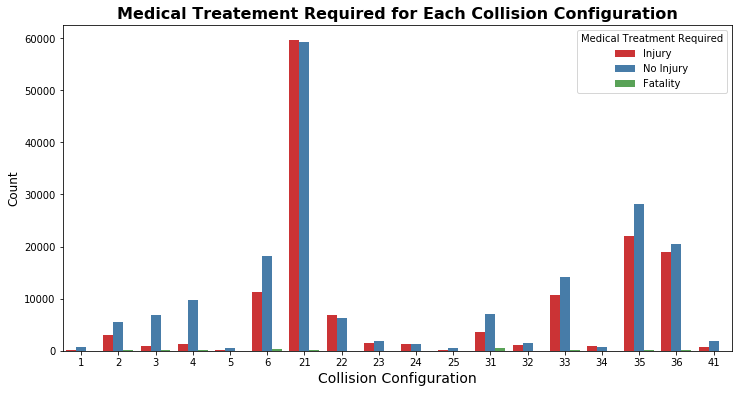

In [302]:
# count plot of collision configureation and medical treatment required
sns.countplot(x="C_CONF", hue="P_ISEV", data=subData, palette="Set1");  

# titles stored
titles = ["Injury", "No Injury", "Fatality"] 
# format the legend of the plot with titles and location
plt.legend(titles, ncol=1, loc='upper right', title = "Medical Treatment Required");
# add main title, x and y axis titles
plt.title('Medical Treatement Required for Each Collision Configuration', fontsize=16,fontweight='bold')
plt.xlabel('Collision Configuration', fontsize = 14)
plt.ylabel('Count', fontsize = 12)

Single Vehicle in motion:
* 1 = Hit a moving object  
* 2 = Hit a stationary object  
* 3 = Ran off the left shoulder  
* 4 = Ran off the right shoulder  
* 5 = Rollover on the roadway  
* 6 = An other single vehicle collison  

Two Vehicles in Motion - Same Direction of Travel:  
* 21 = Read-end collision  
* 22 = Side-swipe  
* 23 = One vehicle passing to the left of the other, or left turn conflict  
* 24 = One vehicle passing to the right of the other, or right turn conflict  
* 25 = Any other two vehicle - same direction of travel configuration  

Two Vehicles in Motion - Different Direction of Travel:  
* 31 = Head-on collision  
* 32 = Approaching side-swipe  
* 33 = Left turn across opposing traffic  
* 34 = Right turn, including turning conflicts  
* 35 = Right angle collision  
* 36 = Any other two-vehicle - different direction of travel configuration  


Two Vehicles - Hit a Parked Motor Vehicle:  
* 41 = Hit a parked vehicle    



Of all the collision configurations, rear-end, side-swipe and right turn conflicts were more likely to result in injury than no injury. On the other hand, hitting a stationary object, running off the left shoulder, and running off the right shoulder rarely resulted in injury which required medical attention. Not surprisingly, there were more fatal collisions as result of a head on collision than any other type of collision. The most common types of collisions are rear-ends, left turns across opposing traffic and right angle collisions (T-bone). Roll-overs are very uncommon, as well as approaching side-swipes, and collisions involving a car making a right turn. It is also quite uncommon for a vechicle to hit a parked car, but when it does happen injury is over twice as likely as no injury.

<br> 

#### Dimensionality Reduction 
<br>
   
* Feature Subset Selection:  

When considering the selection of a subset of features from the dataset it is important to not lose information important to classification. If any features are not included, they cannot be relevant to the classifcation of collision fatalities. Carefully considering the features, there do not appear to be redundant features which duplicate all or most of the information of one or more other features. In terms of irrelevant features, all of the features appear to have useful information which might help to classify which collisions are fatal and which are not. In the case of the current data, it might not be appropriate to implement a filter approach to choosing a feature subset as all features seem relevant.  
<br> 

**How I would find association between features when selecting a subset?**  

> How could I determine features which are related to collison severity given that I have only categorical data? If I had more time I might look into making seperate data frames for each attribute split across both levels of collision severity providing counts of the amounts of records (observations) which fell into each category. This would make a contingency table for each categorical variable. I would then compute a chi-sqaured test for independence statistic to measure the association of each categorical variable  with collision severtity.  

> The problem with this measure is that in a sample as large as mine, the sensitivity of the test would would be great and thus the statistical power of the test would be inflated making even tiny differences statstically significant. Because a Pearson's chi-sqaured does not give a measure of effect size it is hard to know if these effects are very meaningful. I would therefore have to look at column and row percentages to interpret the effect as well as run a Cramer's V (phi) because phi would give me an idea of the effect size rather than simply the detection of an effect.  

> **What I would have to do first?** Chi-sqaured assumes records are independent but the data in this data set is not independent; the same collisions involving multiple individuals across multiple rows are present in the data. To overcome this I would take 10,000 bootstrap samples of >= 10% of the original complete data set sampling with replacement to assume independence of observations and compute an empirical p-value for chi-sqaured.   

> Would these statistics lead me to a firm decision about which variables are to be retained and which are not? Not really. They would simply inform me of any chases where a variable seemed to have no relation to collision severity which I then might inspect further and decide to remove.  

> I do not have time to do these things but I think it would be interesting to explore in the future. 

<br> 
* Feature Creation for Replacement: 

Here I would like to consider whether or not I could create any new features which capture the information of original features, replacing these original features, ultimately reduce the number of overall features. It is possible to create a 'date' feature which includes information of the features which describe the year, month, week, day, and possibly hour of th collison (replacing these 3-4 features). This could be helpful for some queries, such as easily seeing accidents on certain days of each year, but would be a hinderence overall. It is more informative to be able to consider collisons in terms of monthly, weekly, daily, and hourly occurences, especially for visualization purposes.  

There might be a way to combine medical treatment required and saftey devices used but I think this loses a lot of interesting information; perhaps the same types of medical treatments see the use of different devices depending on the training and preference of the first responder, nature of the collision, or size/age of the victim. I think combining these attributes in some way would introduce bias into the model because it would be the result of making several assumptions.  

Similarly, the weather conditions and road surface features are very similar and definately highly correlated but I also think that combining these features would lose important information. Knowing that it is sunny out does not mean the road is not wet. If someone is driving in the morning and it rained over night, perhaps the sun has not had time to dry the road yet. Also, knowing that it is snowing does not neccessarily mean snow has accomulated on the roads surface. Many days when the direct sunlight it strong and it is snowing, the snow does not have a chance to reach the ground before it evaporates (and definitely not a chance to accumulate). In conclusion, I do not think combining original features into a fewer number of new feature is appropriate for this data.  

* Principal Components Analysis:  

PCA is a technique used for dimensionality reduction with continuous attributes. Most of the attributes of the current data set are nominal. However, these nominal attributes will be mapped to new space with 1 to n mapping and, as result, the data set wil contain a very large number of attributes. PCA can be used to retain much of the variance in the data while reducing the number of attributes greatly. With a very large number of attributes it is neccessary to reduce the amount of attributes. PCA is done with continuous data but I have read that there are similar methods for discrete data. I will research the issue further. 


<br>  

#### Mapping the Data: Nominal Variables with 1 to n Mapping  

This data set contains a large number of categorical variables with multiple levels to each. To map these to a new space it is important not to introduce an ordering which is not inherent to the original data set. To map these categorical variables to a new space without introducing an artificial order, 1 to n mapping will be used for each variable. These new mapped variables will then need to be attached onto the data set.  

**Caveat:** There is another problem that mapping with 1 to n mapping will solve (the way I am going to do it anyways). There are a few levels to some of the attributes which have no data associated with them. For instance, I mentioned before that no crashes occured in two roadway configurations: on a collector lane of a freeway system and on a transfer lane of a freeway system. These two levels of the C_RCFG will not get a new column, thus that level will not be considered.  

<br> 

> **Something interesting to consider:** If one thinks about 1 to n mapping it might soon become clear that to retain all the information about the levels of a categorical variable one actually *does not* need to map to n new columns but instead one only needs to map to n-1 new columns. By removing the first new column, this level becomes the base line. For instance, if a categorical variable contained 3 levels we could map these levels to 2 new columns without losing information by assuming [0 , 0] denoted the first level, [0, 1] denoted the second level, and [1, 0] denoted the third level. As you can see this method only required 2 rows of values to express 3 ideas and is thus parsimonious. In the above example, the first level (represented as a 0 in both of the two new columns) has been established as a baseline. 

> I am not going to do 1 to n-1 mapping because I am not sure if it is always appropriate in data mining contexts so will stick with 1 to n.  

<br> 

>**More interesting stuff to consider:** The number of records which fall into a level of a certain feature may be very low. For instance, of the vehicle type feature there are three levels which include different types of trucks. Say for instance one of those truck types (one level of the vehicle type feature) had a tiny number of records associated with it, maybe >1 - 4% of all records. This level might not really have any impact on the classification model so one might consider combining this level with another level where appropriate. Say big truck type 1 had 1000 records associated with it and big truck type 2 had 11 records associated with it, it might be a good idea to put records associated with the later truck type level into the former truck type level. This would mean actually altering original values which I do not like to do (and really shouldn't be done except in certain cirsumstances usually following some form of outlier detection, etc.) so it would be done merely for comparision purposes.  

> That being said, I do not want to remove categories whose levels are very imbalanced overall as they likely do a good job splitting the target feature and thus great for classification. 

> If I had more time I might explore this option and see how it influenced model prediction quality.  

<br> 

For now, I will simply do the mapping:

* Mapping sex (P_SEX):

In [47]:
# 1 to n mapping creating a new column for each level of a P_SEX and filling with 0's and 1's ('dummy variables)
sexDummies = pd.get_dummies(subData.P_SEX, prefix = 'P_SEX')

# concatenate this data frame containing dummy coding variables to the data set specifying axis =1 too attach by columns
subData= pd.concat([subData, sexDummies], axis = 1)

* Mapping month (C_MNTH)

In [48]:
# 1 to n mapping creating a new column for each level of a C_MNTH and filling with 0's and 1's ('dummy variables)
monthDummies = pd.get_dummies(subData.C_MNTH, prefix = 'C_MNTH')

# concatenate this data frame containing dummy coding variables to the data set specifying axis =1 too attach by columns
subData= pd.concat([subData, monthDummies], axis = 1)

* Mapping weekday (C_WDAY):

In [49]:
# 1 to n mapping creating a new column for each level of a C_WDAY and filling with 0's and 1's ('dummy variables)
weekDummies = pd.get_dummies(subData.C_WDAY, prefix = 'C_WDAY')

# concatenate this data frame containing dummy coding variables to the data set specifying axis =1 too attach by columns
subData= pd.concat([subData, weekDummies], axis = 1)

* Mapping hour of collision (C_HOUR):

In [50]:
# 1 to n mapping creating a new column for each level of a C_HOUR and filling with 0's and 1's ('dummy variables)
hourDummies = pd.get_dummies(subData.C_HOUR, prefix = 'C_HOUR')

# concatenate this data frame containing dummy coding variables to the data set specifying axis =1 too attach by columns
subData= pd.concat([subData, hourDummies], axis = 1)

* Mapping collision configuration (C_CONF):

In [51]:
# 1 to n mapping creating a new column for each level of a C_CONF and filling with 0's and 1's ('dummy variables)
confDummies = pd.get_dummies(subData.C_CONF, prefix = 'C_CONF')

# concatenate this data frame containing dummy coding variables to the data set specifying axis =1 too attach by columns
subData= pd.concat([subData, confDummies], axis = 1)

* Mappping roadway configuration (C_RCFG):

In [52]:
# 1 to n mapping creating a new column for each level of a C_RCFG and filling with 0's and 1's ('dummy variables)
roadDummies = pd.get_dummies(subData.C_RCFG, prefix = 'C_RCFG')

# concatenate this data frame containing dummy coding variables to the data set specifying axis =1 too attach by columns
subData= pd.concat([subData, roadDummies], axis = 1)

* Mapping weather conditions (C_WTHR): 

In [53]:
# 1 to n mapping creating a new column for each level of a C_WTHR and filling with 0's and 1's ('dummy variables)
weatherDummies = pd.get_dummies(subData.C_WTHR, prefix = 'C_WTHR')

# concatenate this data frame containing dummy coding variables to the data set specifying axis =1 too attach by columns
subData= pd.concat([subData, weatherDummies], axis = 1)

* Mapping road surface (C_RSUR):

In [54]:
# 1 to n mapping creating a new column for each level of a C_RSUR and filling with 0's and 1's ('dummy variables)
surfaceDummies = pd.get_dummies(subData.C_RSUR, prefix = 'C_RSUR')

# concatenate this data frame containing dummy coding variables to the data set specifying axis =1 too attach by columns
subData= pd.concat([subData, surfaceDummies], axis = 1)

* Mapping road allignment (C_RALN):

In [55]:
# 1 to n mapping creating a new column for each level of a C_RALN and filling with 0's and 1's ('dummy variables)
allignDummies = pd.get_dummies(subData.C_RALN, prefix = 'C_RALN')

# concatenate this data frame containing dummy coding variables to the data set specifying axis =1 too attach by columns
subData= pd.concat([subData, allignDummies], axis = 1)


* Mappiing traffic control (C_TRAF):

In [56]:
# 1 to n mapping creating a new column for each level of a C_TRAF and filling with 0's and 1's ('dummy variables)
controlDummies = pd.get_dummies(subData.C_TRAF, prefix = 'C_TRAF')

# concatenate this data frame containing dummy coding variables to the data set specifying axis =1 too attach by columns
subData= pd.concat([subData, controlDummies], axis = 1)

* Mapping for vehicle type (V_TYPE):

In [57]:
# 1 to n mapping creating a new column for each level of a V_TYPE and filling with 0's and 1's ('dummy variables)
vtypeDummies = pd.get_dummies(subData.V_TYPE, prefix = 'V_TYPE')

# concatenate this data frame containing dummy coding variables to the data set specifying axis =1 too attach by columns
subData= pd.concat([subData, vtypeDummies], axis = 1)

* Mapping for person position (P_PSN): 

In [58]:
# 1 to n mapping creating a new column for each level of a P_PSN and filling with 0's and 1's ('dummy variables)
positionDummies = pd.get_dummies(subData.P_PSN, prefix = 'P_PSN')

# concatenate this data frame containing dummy coding variables to the data set specifying axis =1 too attach by columns
subData= pd.concat([subData, positionDummies], axis = 1)

* Mapping medical treatment required (P_ISEV):

In [59]:
# 1 to n mapping creating a new column for each level of a P_ISEV and filling with 0's and 1's ('dummy variables)
medicalDummies = pd.get_dummies(subData.P_ISEV, prefix = 'P_ISEV')

# concatenate this data frame containing dummy coding variables to the data set specifying axis =1 too attach by columns
subData= pd.concat([subData, medicalDummies], axis = 1)

* Mapping safety device used (P_SAFE):

In [60]:
# 1 to n mapping creating a new column for each level of a P_SAFE and filling with 0's and 1's ('dummy variables)
safetyDummies = pd.get_dummies(subData.P_SAFE, prefix = 'P_SAFE')

# concatenate this data frame containing dummy coding variables to the data set specifying axis =1 too attach by columns
subData= pd.concat([subData, safetyDummies], axis = 1)

* Mapping road user class (P_USER):

In [61]:
# 1 to n mapping creating a new column for each level of a P_USER and filling with 0's and 1's ('dummy variables)
userDummies = pd.get_dummies(subData.P_USER, prefix = 'P_USER')

# concatenate this data frame containing dummy coding variables to the data set specifying axis =1 too attach by columns
subData= pd.concat([subData, userDummies], axis = 1)

<br>  

Now that I have done the mapping, lets print the columns to make sure they are all there:  


In [62]:
# print a list of all columns in subData:
print(list(subData))

['C_YEAR', 'C_MNTH', 'C_WDAY', 'C_HOUR', 'C_SEV', 'C_VEHS', 'C_CONF', 'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN', 'C_TRAF', 'V_ID', 'V_TYPE', 'V_YEAR', 'P_ID', 'P_SEX', 'P_AGE', 'P_PSN', 'P_ISEV', 'P_SAFE', 'P_USER', 'DATE', 'P_SEX_1', 'P_SEX_2', 'C_MNTH_1', 'C_MNTH_2', 'C_MNTH_3', 'C_MNTH_4', 'C_MNTH_5', 'C_MNTH_6', 'C_MNTH_7', 'C_MNTH_8', 'C_MNTH_9', 'C_MNTH_10', 'C_MNTH_11', 'C_MNTH_12', 'C_WDAY_1', 'C_WDAY_2', 'C_WDAY_3', 'C_WDAY_4', 'C_WDAY_5', 'C_WDAY_6', 'C_WDAY_7', 'C_HOUR_0', 'C_HOUR_1', 'C_HOUR_2', 'C_HOUR_3', 'C_HOUR_4', 'C_HOUR_5', 'C_HOUR_6', 'C_HOUR_7', 'C_HOUR_8', 'C_HOUR_9', 'C_HOUR_10', 'C_HOUR_11', 'C_HOUR_12', 'C_HOUR_13', 'C_HOUR_14', 'C_HOUR_15', 'C_HOUR_16', 'C_HOUR_17', 'C_HOUR_18', 'C_HOUR_19', 'C_HOUR_20', 'C_HOUR_21', 'C_HOUR_22', 'C_HOUR_23', 'C_CONF_1', 'C_CONF_2', 'C_CONF_3', 'C_CONF_4', 'C_CONF_5', 'C_CONF_6', 'C_CONF_21', 'C_CONF_22', 'C_CONF_23', 'C_CONF_24', 'C_CONF_25', 'C_CONF_31', 'C_CONF_32', 'C_CONF_33', 'C_CONF_34', 'C_CONF_35', 'C_CONF_36', 'C_CONF_4

Looks like it was sucessful. Remember that some levels of these categorical variables were dropped if no records fell into said level. Also remember that the category levels were not always labeled as an ordered series(1,2,3,4,5...) but often had jumps in the series (1,2,9,10,11...). Considering this, these columns all appear fine. 

<br>

Now that I have dummies I can drop the original variables so no information is replicated: 

In [63]:
# delete original features which have been dummy coded:

del subData['C_MNTH']
del subData['C_WDAY'] 
del subData['C_HOUR']
del subData['C_CONF']
del subData['C_RCFG']
del subData['C_WTHR']
del subData['C_RSUR']
del subData['C_RALN']
del subData['C_TRAF']
del subData['V_TYPE']
del subData['P_SEX']
del subData['P_ISEV']
del subData['P_SAFE']
del subData['P_USER']  
del subData['P_PSN']

Make sure they are deleted: 

In [64]:
# print a list of all columns in subData:
print(list(subData))

['C_YEAR', 'C_SEV', 'C_VEHS', 'V_ID', 'V_YEAR', 'P_ID', 'P_AGE', 'DATE', 'P_SEX_1', 'P_SEX_2', 'C_MNTH_1', 'C_MNTH_2', 'C_MNTH_3', 'C_MNTH_4', 'C_MNTH_5', 'C_MNTH_6', 'C_MNTH_7', 'C_MNTH_8', 'C_MNTH_9', 'C_MNTH_10', 'C_MNTH_11', 'C_MNTH_12', 'C_WDAY_1', 'C_WDAY_2', 'C_WDAY_3', 'C_WDAY_4', 'C_WDAY_5', 'C_WDAY_6', 'C_WDAY_7', 'C_HOUR_0', 'C_HOUR_1', 'C_HOUR_2', 'C_HOUR_3', 'C_HOUR_4', 'C_HOUR_5', 'C_HOUR_6', 'C_HOUR_7', 'C_HOUR_8', 'C_HOUR_9', 'C_HOUR_10', 'C_HOUR_11', 'C_HOUR_12', 'C_HOUR_13', 'C_HOUR_14', 'C_HOUR_15', 'C_HOUR_16', 'C_HOUR_17', 'C_HOUR_18', 'C_HOUR_19', 'C_HOUR_20', 'C_HOUR_21', 'C_HOUR_22', 'C_HOUR_23', 'C_CONF_1', 'C_CONF_2', 'C_CONF_3', 'C_CONF_4', 'C_CONF_5', 'C_CONF_6', 'C_CONF_21', 'C_CONF_22', 'C_CONF_23', 'C_CONF_24', 'C_CONF_25', 'C_CONF_31', 'C_CONF_32', 'C_CONF_33', 'C_CONF_34', 'C_CONF_35', 'C_CONF_36', 'C_CONF_41', 'C_RCFG_1', 'C_RCFG_2', 'C_RCFG_3', 'C_RCFG_4', 'C_RCFG_5', 'C_RCFG_6', 'C_RCFG_7', 'C_RCFG_8', 'C_RCFG_9', 'C_RCFG_10', 'C_WTHR_1', 'C_WTHR_2',

In [65]:
# see shape of data frame:
subData.shape


(330396, 158)

<br>  

**Another challenge has now presented itself**  

After mapping, data are discrete and discrete binary. Features which have been mapped are now discrete binary but original features which are discrete but not categorical have not been mapped and are still simply discrete data. For instance, a persons age and the age of the vehicle are measured only in ages in years and cannot take on continuous real numbers but also cannot be mapped appropriately to convert to binary features.  This is a problem because I want to train a neural network which is sensitive to feature scaling.  

> see: 

> *Greenacre, Michael; Blasius, Jorg (2006-06-23). Multiple Correspondence Analysis and Related Methods. CRC Press. pp. 352.*  

<br> 

Before I move on, I want to make sure the data is of the same type.

<br>

 

**Binning non-categorical data and then mapping 1 to n**  

After mapping I want to also include the age of the individual involved in the accident as well as the year the vehicle was made. I want to include these because I imagine a persons age might have an important contribution to predicting fatality as result of a collision. Very young and very old individuals are likely at higher risk of dying from a collision. Similary older cars might have poorer safety ratings than newer cars and so individuals riding in these cars may be more suseptible to dying as result of a collsion. Noticle how I am taking about individuals ages and vehicle ages in terms of categories ("young", "old"). To get these into the same data type as all the features which have been mapped already, I am going to bin person age and vehicle age into intervals (age categories) and then map those bins into new space with 1 to n mapping just as I did above. As result, the entire set of features I will use for this analysis will be on a binary 0|1 scale. 

> **Reflection:** Here I am abstracting from the original data and introducing levels to features which did not have levels before. I also mentioned how I believed younger and older individuals might have increased likelihood of dying as result of a collision. This could be seen as introducing my own bias into the data set and one might argue it is not okay to proceed with this method of abstracting from the original data. Perhaps young people and older people are *less* likely to die as result of a car accident. As we know, infants usually have protective car seats and their parents or care givers might drive much more cautiously with an infant in the car. Similarly, elderly individuals might be driving at significantly lower speeds when they are involved in a collision. And in both cases, medical responders might take extra care and precautions when helping very young and very old victims. 

> **Moral of the story:** there are many ways to interpret a phenomena and there are much more qualitative aspects of an analysis than one might imagine. All I can do is give my reason for proceeding in such a fashion and move on always remaining mindful of what I have done and the implications of my practices. 

* Binning person age (P_AGE)  

First I need to cut the person age feature into bins. I want to have bins including 5 years, starting at age 0 (infants) and ending at age 100 (recall the oldest individals in the data set were 99). First I need to specify which features values I want to cut into bins, in what intervals I should cut these bins, and then assign records into of these bins into a new grouped feature which I will call 'AgeGroup'.

<br>

In [66]:
# cutting P_AGE into bins and assigning to new feature:

subData['AgeGroup'] = pd.cut(subData.P_AGE, [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])


<br>
Now, to check to make sure this worked out I can use the pandas crosstab function to check which ages in the column P_AGE where included within each level of the new feature AgeGroup.

<br>

In [67]:
#  check to see if this worked out with crosstab:

print(pd.crosstab(subData['AgeGroup'], subData['P_AGE']))

P_AGE        1     2     3     4     5     6     7     8     9     10 ...  \
AgeGroup                                                              ...   
(0, 5]     3368  1797  1897  1898  1892     0     0     0     0     0 ...   
(5, 10]       0     0     0     0     0  1827  1756  1779  1659  1657 ...   
(10, 15]      0     0     0     0     0     0     0     0     0     0 ...   
(15, 20]      0     0     0     0     0     0     0     0     0     0 ...   
(20, 25]      0     0     0     0     0     0     0     0     0     0 ...   
(25, 30]      0     0     0     0     0     0     0     0     0     0 ...   
(30, 35]      0     0     0     0     0     0     0     0     0     0 ...   
(35, 40]      0     0     0     0     0     0     0     0     0     0 ...   
(40, 45]      0     0     0     0     0     0     0     0     0     0 ...   
(45, 50]      0     0     0     0     0     0     0     0     0     0 ...   
(50, 55]      0     0     0     0     0     0     0     0     0     0 ...   

<br>  

It worked out perfectly. As seen above people who are who are ages 0-5 fall into the first level of the new feature AgeGroup. Also, this output shows and how many individuals of each age fall into each level of the new feature. 

In [68]:
# first 5 rows of age group
subData['AgeGroup'].head(5)

0    (45, 50]
1    (30, 35]
2    (25, 30]
3    (65, 70]
5    (20, 25]
Name: AgeGroup, dtype: category
Categories (20, interval[int64]): [(0, 5] < (5, 10] < (10, 15] < (15, 20] ... (80, 85] < (85, 90] < (90, 95] < (95, 100]]

<br> 
Notice above how AgeGroup is recognized as categorical. 

<br>

* Mapping age group (AgeGroup):  

Now I can map age groups to new space with 1 of n.

In [69]:
# 1 to n mapping creating a new column for each level of a P_USER and filling with 0's and 1's ('dummy variables)
agegroupDummies = pd.get_dummies(subData.AgeGroup, prefix = 'AgeGroup')

# concatenate this data frame containing dummy coding variables to the data set specifying axis =1 too attach by columns
subData= pd.concat([subData, agegroupDummies], axis = 1)

<br> 
I also want to do the same for vehicle year. First binning and then mapping. 

* Binning vehicle year (V_YEAR):

This is going to be more tricky than binning and mapping age. In the case of vehicle age, the breakdown of the number of vehicles for each model year is much more uneven.  

To see counts of vehicle age in ascending order:

In [70]:
# get sounts for vehicle year
subData.V_YEAR.value_counts(ascending =True)

1963        1
1916        1
1927        1
1954        1
1929        1
1931        1
1937        1
1938        1
1951        1
1955        2
1952        2
1950        2
1911        2
1940        2
1928        2
1948        2
1956        3
1964        3
1958        3
1949        3
1965        4
1960        5
1930        5
1959        5
1957        6
1915        7
1962        7
1966       10
1968       16
1967       21
        ...  
1986      234
1987      314
1988      378
1989      551
1990      791
2015      808
1991      873
1992     1274
1993     1395
1994     1897
1995     2718
1996     3039
1997     5588
1998     7427
1999     8682
2014     8915
2000    12641
2001    14001
2002    18022
2004    19467
2011    19769
2009    20123
2013    20733
2003    21169
2012    21605
2006    22019
2010    22424
2005    23121
2008    23923
2007    25227
Name: V_YEAR, Length: 77, dtype: int64

<br>  

Notice that there are many vehicle ages which only have 1 or very few associated vehicles. This is not like the distribution of person ages as infants and toddlers riding in cars is not a rarity. 

Because of this break down I am going to make the bins contain a larger range of values of vehicle age. I am most interested in **classic, very old, old, not old but not new, new, and very new cars.**  

The range of vehicle ages will inform how I want to split the data:

<br>

In [71]:
#Get the minimum value of each column:
print('Minimum vehicle year:', subData.loc[:,'V_YEAR'].min())
print('Maximum vehicle year:', subData.loc[:,'V_YEAR'].max())

Minimum vehicle year: 1911
Maximum vehicle year: 2015


This range is correct. Recall the data goes up until 2014 but car manufacturers always release next years models towards the end of a year because this is a time when manufacturers see a lul in sales as people would rather wait to buy the nest years model. Releasing a model early erases this lul in sales. 

This is how I will bin vehicle years:  

* Very new cars: 2010 - 2015
* New cars: 2005 - 2009
* Not new but not old cars: 2000 - 2004 
* Old cars: 1995 - 1999
* Very old cars: 1990 - 1994
* Classic cars: 1911 - 1989


In [72]:
# cutting V_AGE into bins and assigning to new feature:

subData['vyearGroup'] = pd.cut(subData.V_YEAR, [1911, 1989, 1994, 1999, 2004, 2009, 2015])

In [73]:
#  check to see if this worked out with crosstab:

print(pd.crosstab(subData['vyearGroup'], subData['V_YEAR']))

V_YEAR        1911  1915  1916  1927  1928  1929  1930  1931  1937  1938  \
vyearGroup                                                                 
(1911, 1989]     0     7     1     1     2     1     5     1     1     1   
(1989, 1994]     0     0     0     0     0     0     0     0     0     0   
(1994, 1999]     0     0     0     0     0     0     0     0     0     0   
(1999, 2004]     0     0     0     0     0     0     0     0     0     0   
(2004, 2009]     0     0     0     0     0     0     0     0     0     0   
(2009, 2015]     0     0     0     0     0     0     0     0     0     0   

V_YEAR        ...    2006   2007   2008   2009   2010   2011   2012   2013  \
vyearGroup    ...                                                            
(1911, 1989]  ...       0      0      0      0      0      0      0      0   
(1989, 1994]  ...       0      0      0      0      0      0      0      0   
(1994, 1999]  ...       0      0      0      0      0      0      0      0   
(

In [74]:
# look at the first 5 rows of the vyearGroup attribute
subData['vyearGroup'].head(5)

0    (1999, 2004]
1    (1994, 1999]
2    (2004, 2009]
3    (1999, 2004]
5    (2009, 2015]
Name: vyearGroup, dtype: category
Categories (6, interval[int64]): [(1911, 1989] < (1989, 1994] < (1994, 1999] < (1999, 2004] < (2004, 2009] < (2009, 2015]]

<br> 

Now the data is categorical and can be mapped appropriately.

* Mapping vehicle age groups (vyearGroup) 1 to n:

In [75]:
# 1 to n mapping creating a new column for each level of a P_USER and filling with 0's and 1's ('dummy variables)
vgroupDummies = pd.get_dummies(subData.vyearGroup, prefix = 'vageGroup')

# concatenate this data frame containing dummy coding variables to the data set specifying axis =1 too attach by columns
subData= pd.concat([subData, vgroupDummies], axis = 1)

<br> 

Now I can delete the original features and the created binned features which I have now mapped 1 to n.

In [76]:
# delete original features which have been dummy coded:

del subData['P_AGE']
del subData['AgeGroup'] 
del subData['V_YEAR']
del subData['vyearGroup']

In [77]:
# print a list of all columns in subData:
print(list(subData))

['C_YEAR', 'C_SEV', 'C_VEHS', 'V_ID', 'P_ID', 'DATE', 'P_SEX_1', 'P_SEX_2', 'C_MNTH_1', 'C_MNTH_2', 'C_MNTH_3', 'C_MNTH_4', 'C_MNTH_5', 'C_MNTH_6', 'C_MNTH_7', 'C_MNTH_8', 'C_MNTH_9', 'C_MNTH_10', 'C_MNTH_11', 'C_MNTH_12', 'C_WDAY_1', 'C_WDAY_2', 'C_WDAY_3', 'C_WDAY_4', 'C_WDAY_5', 'C_WDAY_6', 'C_WDAY_7', 'C_HOUR_0', 'C_HOUR_1', 'C_HOUR_2', 'C_HOUR_3', 'C_HOUR_4', 'C_HOUR_5', 'C_HOUR_6', 'C_HOUR_7', 'C_HOUR_8', 'C_HOUR_9', 'C_HOUR_10', 'C_HOUR_11', 'C_HOUR_12', 'C_HOUR_13', 'C_HOUR_14', 'C_HOUR_15', 'C_HOUR_16', 'C_HOUR_17', 'C_HOUR_18', 'C_HOUR_19', 'C_HOUR_20', 'C_HOUR_21', 'C_HOUR_22', 'C_HOUR_23', 'C_CONF_1', 'C_CONF_2', 'C_CONF_3', 'C_CONF_4', 'C_CONF_5', 'C_CONF_6', 'C_CONF_21', 'C_CONF_22', 'C_CONF_23', 'C_CONF_24', 'C_CONF_25', 'C_CONF_31', 'C_CONF_32', 'C_CONF_33', 'C_CONF_34', 'C_CONF_35', 'C_CONF_36', 'C_CONF_41', 'C_RCFG_1', 'C_RCFG_2', 'C_RCFG_3', 'C_RCFG_4', 'C_RCFG_5', 'C_RCFG_6', 'C_RCFG_7', 'C_RCFG_8', 'C_RCFG_9', 'C_RCFG_10', 'C_WTHR_1', 'C_WTHR_2', 'C_WTHR_3', 'C_WTH

<br> 

Finally, after getting a better understanding and inspecting these data, a few features are in fact not neccessary for this analysis. I will not include these columns into analysis. These include collision year, vehicle and person ID, and vehicle sequence number. I wanted to look at vehicle sequence number but there is no straight forward way to deal with how this features values are broken down. I also do not need the date feature I created for visualization purposes because its information is captured in other features. 

**Under sampling the dominant class**  

<br>

Now I can undersample the dominant class.

Recall the class breakdown:


C:\Users\nicho\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



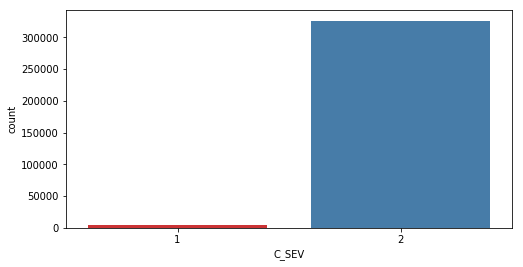

In [78]:
pylab.rcParams['figure.figsize'] = (8, 4)
sns.countplot(subData['C_SEV'], label='Count', palette="Set1");

In [79]:
subData['C_SEV'].value_counts()

2    326050
1      4346
Name: C_SEV, dtype: int64

<br>  

To deal with this imabalnce I want to balance these classes before classification such that each class is equally represented. Why this is important was previously discussed. I will randomly undersample class 2 which includes collisions which did not result in fatality. As result the ratio of classes will be now **1 : 1**. Since the rare class has only 4346 records associated with it, after balancing both classes should have this many records.  

To do with I will use RandomUnderSampler from Imbalanced-learn. It requires passing 'X' as a full list of attributes used to predcit the class label and 'y' as the column containing the class labels.

<br>  

**Define X as the attribute set and y as the target feature collision severity**

In [80]:
Target = subData['C_SEV']

Drop final columns I do not need. Described above.

In [81]:
del subData['C_YEAR']
del subData['C_SEV'] 
del subData['C_VEHS']
del subData['V_ID']
del subData['P_ID']
del subData['DATE']

Now I have the target feature stored as well as the attribute set. 

In [82]:
print(subData.shape)
print(Target.shape)

(330396, 176)
(330396,)


 Resample X based on breakdown of y

In [83]:
# randomly undersample the dominant class, producing a 1:1 ratio:

us = RandomUnderSampler(ratio = 1, random_state = 1)
X_resampled, y_resampled = us.fit_sample(subData, Target)

# print count of the new distribution of class labels following undersampling:
print(sorted(Counter(y_resampled).items()))

[(1, 4346), (2, 4346)]


C:\Users\nicho\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning:

Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.



<br>  

Now both classes have 4346 records each.

<br>  

C:\Users\nicho\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



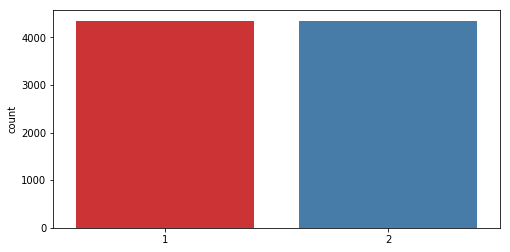

In [84]:
# should see class distribution now:
sns.countplot(y_resampled, label='Count', palette="Set1");

 
The classes are now perfectly balanced and I can proceed. Like previously mentioned I could have not balanced the classes and tried using a different performance metric. I also could have done this right from the start instead of doing it on this sub sample. I am going to keep working with this data set in the future; next time I will do this from the start so I have much more training data.   



<br>
#### Principal Components Analysis (PCA)

I have heard and read some differing oppinions on whether it is okay to do PCA or something similar with binary data
I have read about different methods but there seems to be a lot of disagreement. It seems this can be done if the data was mapped from oridinal features but nominal are more debated. Mapping ordinal data to dummy variables and then doing PCA is called a Filmer and Pritchett procedure. 

> see: 

> *Filmer, D. & Pritchett, L. (2001), ‘Estimating wealth effect without expenditure data — or tears: An application to educational enrollments in states of India’, Demography 38, 115–132.*  

Although, there is debate whether this method produces results that the researcher would expect. Some scientists think this produre produces undesirable correlations. It is also mentioned that there is no advice nor standard practice for doing PCA with categorical attributes with no natural ordering, like those of the current data set. 

> see: 

> *Kolenikov, S. and Angeles, G. (2004) The Use of Discrete Data in PCA: Theory, Simulations, and Applications to Socioeconomic Indices. UNC Chapel Hill.*  

Others have said that the problems lies in how to calculate the correct correlation matrix for PCA to decompose. This touches on my primary concern. Some say an approach is to use a  polychoric correlation to construct the R-matrix. I looked to see if the scipy stack had a method to implement such a correlation but it does not seem to. 

> see: 

> *Lee, S.-Y., Poon, W. Y., & Bentler, P. M. (1995). "A two-stage estimation of structural equation models with continuous and polytomous variables". British Journal of Mathematical and Statistical Psychology, 48, 339–358.*  


<br> 

**Moving forward:**
 

I am going to try to implement PCA with this mapped data and see the result. Due to the very high dimensionality of my data, without PCA distance measures used in clustering would not yeild good results. As dimenstionality becomes great, measures of distance lose meaning. This is known as the curse of dimensionality and I will try to address this concern below. 

### PCA for Visualizing in 2-Dimensions

For visualization purposes I can project the data into 2 dimensions, specifying 2 principal components.

In [85]:
pca = PCA(2)  # project from 178 dimensions to 2 dimensions
projected = pca.fit_transform(X_resampled) # reduce resampled data to 2 dimensions

# look at the should of the resampled data before and after pca
print(X_resampled.shape) 
print(projected.shape)

(8692, 176)
(8692, 2)


The data has been projected from 176 to 2 dimensions (first 2 principal components).

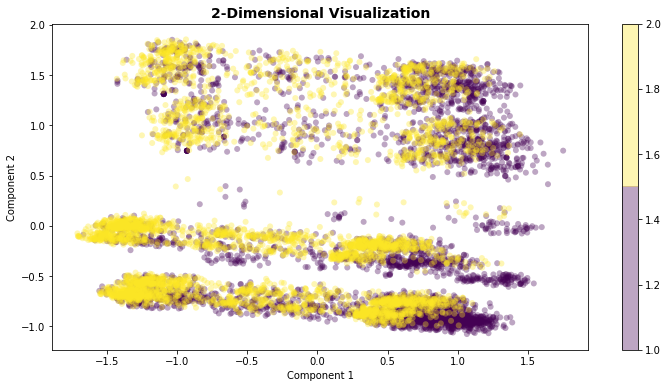

In [86]:
# set figure output size
pylab.rcParams['figure.figsize'] = (12, 6)

# make a scatter plot of the data after PCA
plt.scatter(projected[:, 0], projected[:, 1],  #0 = component 1, 1 = component 2
            c=y_resampled, edgecolor='none', alpha=0.35,  # reduce clutter
            cmap=plt.cm.get_cmap('viridis', 2)) # set colour palet

# gives labels to x, y and main
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('2-Dimensional Visualization', fontsize=14,fontweight='bold')
plt.colorbar(); #show bar at side for classes
# make the axes scales not shown:


Above is a plot of the data which has been projected into two dimensions. It is important to consider that the original data input has 176 dimensions so this visualization is a representation of only a small proportion of the true variance in the data. This is explained more below. 

### PCA for dimensionality reduction

To determine how many components should be retained it is important to know how many components adequately describe the nature of the data. One visual way to do this is to plot the cumulative explained varaince for each principal component. The first component should account for the most cumulative explained varaince while the following components account for proportionally less and less. This means that if we describe data which has been reduced via PCA, the principal component is that which retains the most amount of information about the original data. At the far right end notice that the number of components reaches that of the number of attributes in the data set and can account for all variance in the data. In fact, at around 110 components nearly all the variance in the data can be accounted for. Also notice that the first 25 components account for appoximately 60% of the variance in the data set and 90% of the variance is not explained until about 90 components. The number of components which account for a majority of the variance in the data depends on the dimensionality of the original data. In this case, my data set has very high dimensionality so a larger number of components are required to explain most of the variance in the data. The key is to significantly reduce the dimensionality of the data while retaining as much variance as possible.  

In general, one would like the results to be parsimonious in that the resulting data once it has been reduced after PCA should be **as simple as possible, but no simpler.** I would argue that this phrase should be amended to read 'as simple as is optimal, but no simpler.' This means that while I need to project my data into a lower dimensional space, I also need to retain an adequate amount of information about the data to produce valid results. This trade-off becomes quite tricky when you have highly dimensional data and would like to apply an unsupervised technique such as K-means clustering. In high-dimensions, the distances computed by K-means become less meaningful and computationally costly while on the other hand, in low-dimensions, a huge proportion of variance in the data might be left unexplained.  

With this in mind, interpreting the 2-dimensional plot above becomes more clear. Reducing the data into 2 principal components makes visualization easy but it also results in a very large amount of information loss. By looking at the plot below, the first 2 components account for approximately 15% of the variance in the data. It should be clear that this is a huge abstraction from the true nature of the original data. 

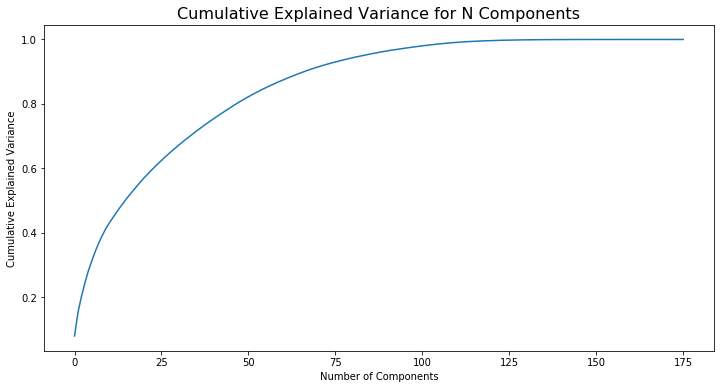

In [87]:
# pca on resampled data
pca = PCA().fit(X_resampled)
plt.plot(np.cumsum(pca.explained_variance_ratio_)) #plot cumulative explained variance

# add x, y and main titles
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance for N Components', fontsize=16);

In [88]:
# show explained variance
np.cumsum(pca.explained_variance_ratio_)

array([ 0.07991877,  0.15318455,  0.20246601,  0.24526467,  0.28251096,
        0.31347745,  0.34312899,  0.36919318,  0.39229172,  0.41303525,
        0.43067958,  0.44671492,  0.46241299,  0.47775519,  0.49233739,
        0.50659925,  0.51990831,  0.53302347,  0.54585365,  0.55843312,
        0.57054847,  0.5819584 ,  0.59300804,  0.60387804,  0.61452382,
        0.62483034,  0.63485725,  0.64463011,  0.6540861 ,  0.66332719,
        0.67240863,  0.68132649,  0.69004932,  0.69856466,  0.70696334,
        0.71519582,  0.72337311,  0.73125763,  0.73907484,  0.74667583,
        0.754122  ,  0.76153929,  0.76871776,  0.77584071,  0.78290636,
        0.78985775,  0.79671551,  0.80349847,  0.80994179,  0.81622553,
        0.82234913,  0.82832233,  0.83406753,  0.83978268,  0.84519966,
        0.85044882,  0.85556638,  0.8604796 ,  0.8652774 ,  0.86998551,
        0.87463643,  0.87912909,  0.88358488,  0.88797887,  0.8921637 ,
        0.89627476,  0.90025922,  0.904172  ,  0.90794125,  0.91

<br> 

2 principal componets retained 15.32% of the variance in the original data.  

Looking tat the above plot, I have to decide how many components to retain. The upper bound of the number of componets to retain has a limit because I want to cluster this data. I do not believe more then 40 components should be retained as I do not want high-dimensionality to impact the K-means algorithm. It seems that 40 components retains about 75% of the variance in the data.   

I can index the array containing the cumulative explained variance of the components to see the exact value. 

In [89]:
# show explained variance of 40 components
np.cumsum(pca.explained_variance_ratio_)[40]

0.75412199640150568

It looks like 40 components accounts for 75.4% of the variance in the original data. For this analysis, I am going to say that I am okay losing about 30% of the variance in the original data due to its high-dimensionality. That means I was select the number of components which can account for ~70% of the cumulative variance. 

In [90]:
np.cumsum(pca.explained_variance_ratio_)[34]

0.70696334362452307

The data set for training a Neural Net is fine without PCA but I will reduce the data into 2 dimensions for visualizing K-means clustering. I could cluster with the 34 components but I could not visualize it.  

In conclusion, PCA does seem to work fine with this type of data.

<br>

### **Preprocessing is complete** 

<br>

I could have done a lot more and I have interesting ideas to implement in the future but for the sake of time I will proceed with this data.  


<br> 

## Training and Evaluation


## Unsupervised Learning  

<br>  

In this section, class labels will be stripped and the underlying structure or relationships withing the data will be explored. 

### Expectation-Maximization - K-means Clustering 

K-means is an algorithm that splits data into K clusters in which observations are assigned to the cluster with the nearest mean value. This makes sense, attribute values of observations closest to a cluster mean will be more similar  than attribute values of observations closest to other cluster means. K-Means looks for a number of clusters which is defined beforehand by the user in data where class labels are unkown.   

K-means is one implementation of expecation maximization which uses the arithemtic mean as the cluster centroids but there are many more implementations.   

Conventionally, you begin by trying different values for K and comparing results of the algorithm. K-means begins by putting K centroids randomly in the data, then assigns cluster memberships based on euclidean distance to nearest centroid. After that the centroids position is updated as the mean of the data associated with each cluster. By updating the centroid locations, cluster memberships change and some data points are now closer in terms of euclidean distance to a different centroid. This means the the centroids position must be updated at each step. This process is iterative and continues until convergence (no data points change cluster membership) or some stopping criteria is met (perhaps little movement).

The step in which points are assigned to the nearest cluster centroid is known as the 'expectation-step' because there is where our expecations for which cluster each data point belongs to are updated. The step in which the cluster centroids are determined as the mean of all data within each cluster is known as the 'maximization step' because it maximizes a fitness function which in the case of K-means is an arithemetic mean. A fitness function is simply something which is used to summarise how close a given solution is to achieving what is trying to be achieved and is represented as a single figure. As the algorithm iteratives through these expectation and maximization steps, a more accurate estimatization of each cluster is achieved (ideally). 

**Determine number of clusters**

To determine the appropriate number of clusters (K) for this data I want to plot the cumlative between-cluster sum of squared errrors as K increases. I previously mentioned that there was a stopping criterion for k-Means. This stopping criterion is usually a threshold value in which the change in within-cluster sum of sqaured errors in two back-to-back iterations is less than, haulting the algorithm. k-Means tries to minimize the within-cluster sum of squared error (clsuters more tightly packed and less dispersed) and maximize the between-cluster sum of sqaured error (clusters are spread out from each other). When looking at the plot it is important to find an optimal value of K such that increasing K by 1 does not improve the between cluster sum of squared error very much. Similar to PCA, The first cluster will explain a lot of variance and subsequent clusters will explain less and less.  At some point, the cumulative increase in between-cluster sum of squared error from adding one more cluster (K+1) will be neglibile. This means that there are qualitatively that many clusters minus one in the data set that k-Means can find and adding another cluster centroid would not be meaningful.

In [253]:
# reduce resampled data to 2 dimensons for visualization
X_resampled_pca = PCA(n_components = 34).fit_transform(X_resampled)

In [254]:
# for k-means clustering
kmeans = KMeans()
kmeans.fit(X_resampled_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

n_clusters denotes the number of clusters K.  

First, I need to look at the characteristics of a range of clusters.

In [255]:
# range of clusters
k_range = range(1,15)

# fit k-means for each n_clusters = k
k_means_variance = [KMeans(n_clusters = k).fit(X_resampled_pca) for k in k_range]

# get the cluster centroids for each k-means model
centroids = [X.cluster_centers_ for X in k_means_variance]


In [256]:
# calculate the euclidean distance from each data point to every cluster center (centroid)
k_euclidean = [cdist(X_resampled_pca, cent, 'euclidean') for cent in centroids]
# dist = minimum distsance, distance to enarest centroid
distance = [np.min(euclid, axis = 1) for euclid in k_euclidean]

# get the total within cluster sum of squares - remember K-means tries to reduce within cluster SSE
WCSSE = [sum(d**2) for d in distance]

# get total SSE in order to calculate the between cluster sum of squared errors
TSSE = sum(pdist(X_resampled_pca)**2)/X_resampled_pca.shape[0]

# between cluster sum of squares = total sse - within see
BSSE = TSSE - WCSSE


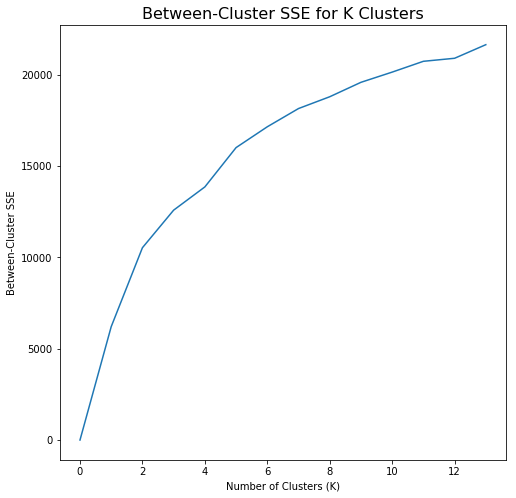

In [258]:
pylab.rcParams['figure.figsize'] = (8, 8)

# plot the between clusters SSE
plt.plot(BSSE)
plt.xlabel('Number of Clusters (K)') 
plt.ylabel('Between-Cluster SSE')
plt.title('Between-Cluster SSE for K Clusters', fontsize=16);
plt.show() 

The above plot does not have a point of inflexion (steap angle). This suggests that the K-means algorithm is not suitable for finding the natural clusters in this data set. I could also plot the within-cluster sum of sqaured errors and see an inverse plot. 


<br> 

**Visualizing K-means when K = 2**  

To visualize the results of K-means on this data set I will first reduce the data into two components.

In [236]:
# reduce resampled data to 2 dimensons for visualization
X_resampled_pca = PCA(n_components = 2).fit_transform(X_resampled)

In [237]:
# 2 clusters:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_resampled_pca)
y_kmeans = kmeans.predict(X_resampled_pca)

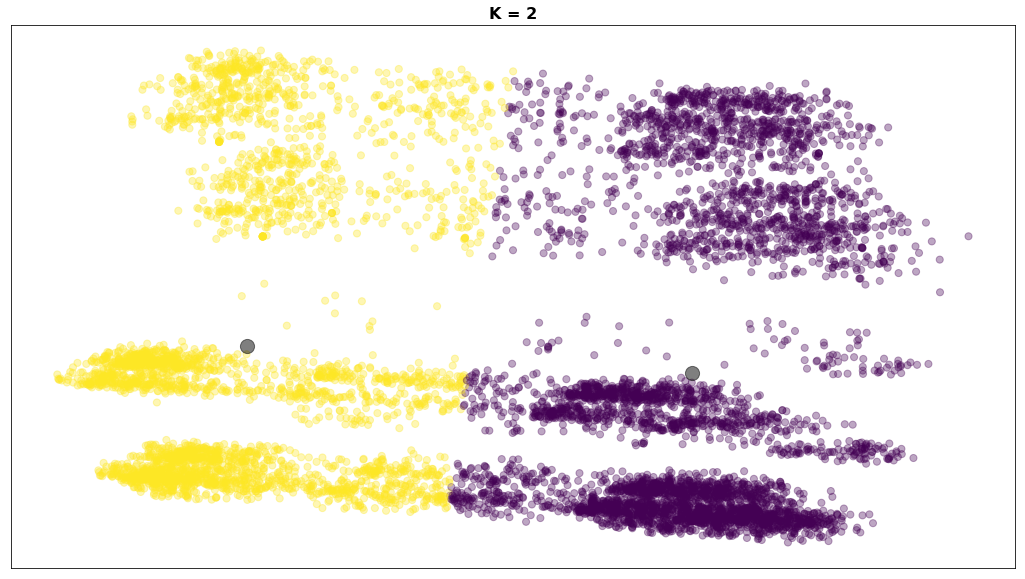

In [238]:
# figure output size:
pylab.rcParams['figure.figsize'] = (18, 10)

# scatter splot of 2 dimensions with k means clustering k=5 applied
plt.scatter(X_resampled_pca[:, 0], X_resampled_pca[:, 1], c=y_kmeans, alpha = 0.35, s=50, cmap='viridis')

# store centroids
centers = kmeans.cluster_centers_

# plot the centroids as black transparent dots
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.title('K = 2', fontsize=16,fontweight='bold');
# make the axes scales not shown:
frame = plt.gca() # get current axes
frame.axes.get_xaxis().set_visible(False) 
frame.axes.get_yaxis().set_visible(False)


<br>  

**Visualizing K-means when K = 3**

In [239]:
# 3 clusters:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_resampled_pca)
y_kmeans = kmeans.predict(X_resampled_pca)

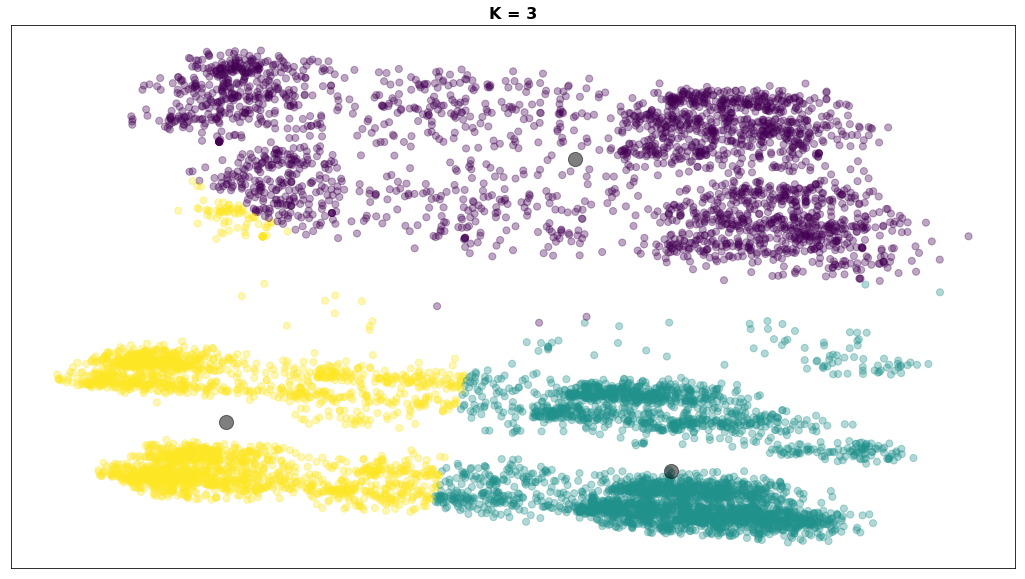

In [240]:
# figure output size:
pylab.rcParams['figure.figsize'] = (18, 10)

# scatter splot of 2 dimensions with k means clustering k=5 applied
plt.scatter(X_resampled_pca[:, 0], X_resampled_pca[:, 1], c=y_kmeans, alpha = 0.35, s=50, cmap='viridis')

# store centroids
centers = kmeans.cluster_centers_

# plot the centroids as black transparent dots
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.title('K = 3', fontsize=16,fontweight='bold');
# make the axes scales not shown:
frame = plt.gca() # get current axes
frame.axes.get_xaxis().set_visible(False) 
frame.axes.get_yaxis().set_visible(False)


<br>  


**Visualizing K-means when K = 4**

In [241]:
# 4 clusters:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_resampled_pca)
y_kmeans = kmeans.predict(X_resampled_pca)

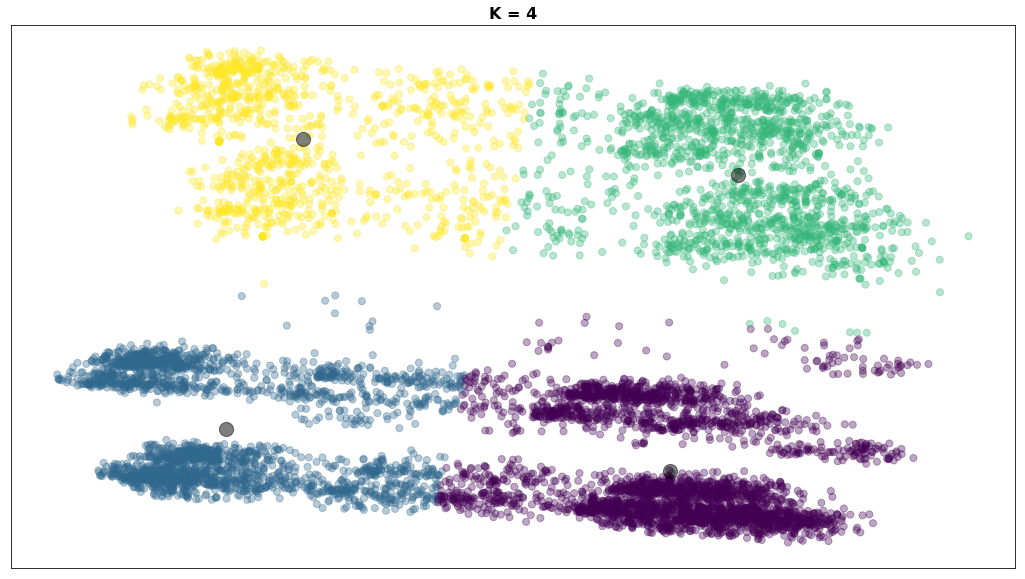

In [242]:
# figure output size:
pylab.rcParams['figure.figsize'] = (18, 10)

# scatter splot of 2 dimensions with k means clustering k=5 applied
plt.scatter(X_resampled_pca[:, 0], X_resampled_pca[:, 1], c=y_kmeans, alpha = 0.35, s=50, cmap='viridis')

# store centroids
centers = kmeans.cluster_centers_

# plot the centroids as black transparent dots
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.title('K = 4', fontsize=16,fontweight='bold');
# make the axes scales not shown:
frame = plt.gca() # get current axes
frame.axes.get_xaxis().set_visible(False) 
frame.axes.get_yaxis().set_visible(False)


<br>  

**Visualizing K-means when K = 5**

In [243]:
# 5 clusters:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_resampled_pca)
y_kmeans = kmeans.predict(X_resampled_pca)

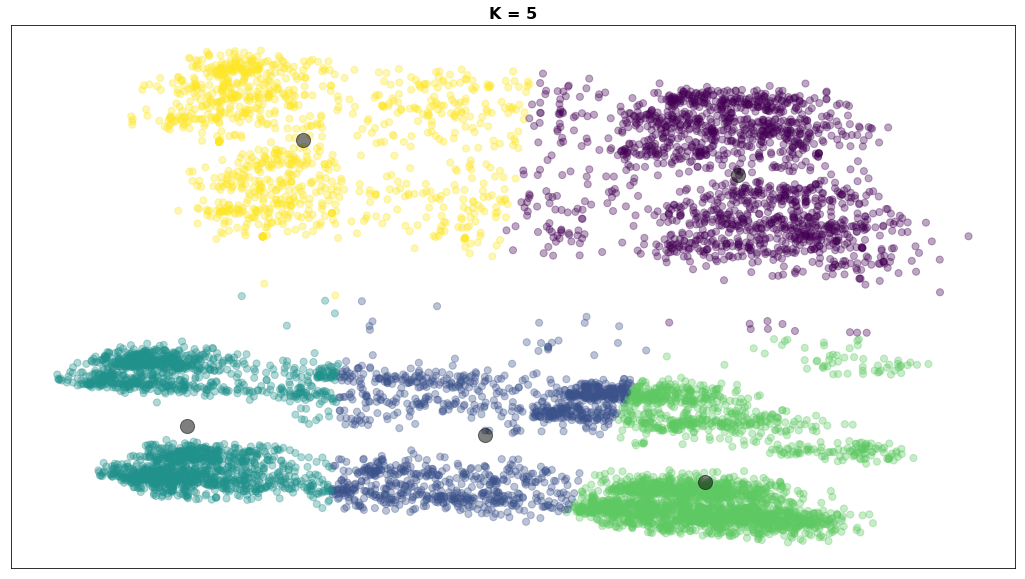

In [244]:
# figure output size:
pylab.rcParams['figure.figsize'] = (18, 10)

# scatter splot of 2 dimensions with k means clustering k=5 applied
plt.scatter(X_resampled_pca[:, 0], X_resampled_pca[:, 1], c=y_kmeans, alpha = 0.35, s=50, cmap='viridis')

# store centroids
centers = kmeans.cluster_centers_

# plot the centroids as black transparent dots
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.title('K = 5', fontsize=16,fontweight='bold');
# make the axes scales not shown:
frame = plt.gca() # get current axes
frame.axes.get_xaxis().set_visible(False) 
frame.axes.get_yaxis().set_visible(False)


<br>  


**Visualizing K-means when K = 6**

In [245]:
# six clusters
kmeans = KMeans(n_clusters=6)
kmeans.fit(X_resampled_pca)
y_kmeans = kmeans.predict(X_resampled_pca)

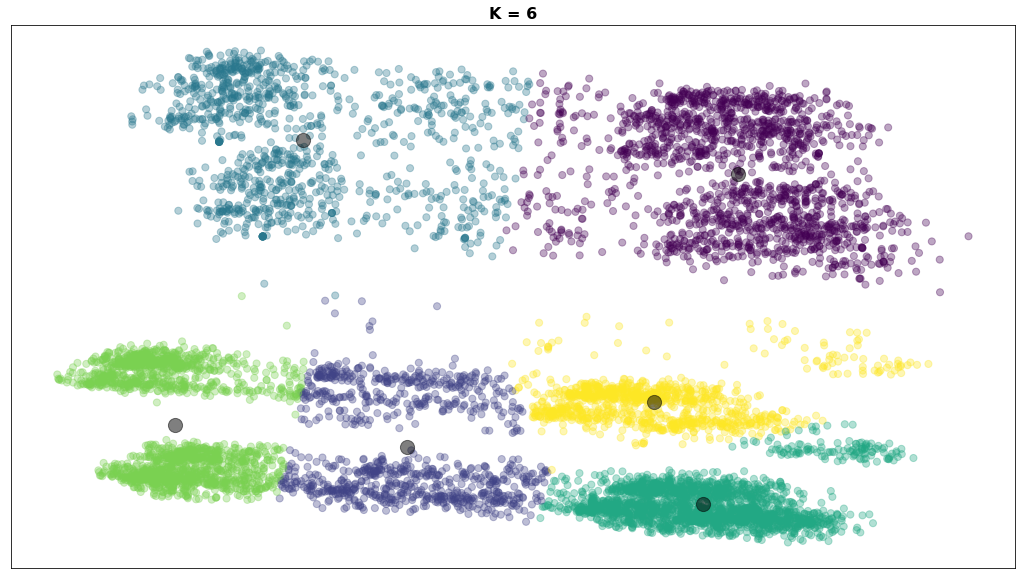

In [246]:
# figure output size:
pylab.rcParams['figure.figsize'] = (18, 10)

# scatter splot of 2 dimensions with k means clustering k=5 applied
plt.scatter(X_resampled_pca[:, 0], X_resampled_pca[:, 1], c=y_kmeans, alpha = 0.35, s=50, cmap='viridis')

# store centroids
centers = kmeans.cluster_centers_

# plot the centroids as black transparent dots
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.title('K = 6', fontsize=16,fontweight='bold');
# make the axes scales not shown:
frame = plt.gca() # get current axes
frame.axes.get_xaxis().set_visible(False) 
frame.axes.get_yaxis().set_visible(False)


<br>  


**Visualizing K-means when K = 7**

In [247]:
# seven clusters
kmeans = KMeans(n_clusters=7)
kmeans.fit(X_resampled_pca)
y_kmeans = kmeans.predict(X_resampled_pca)

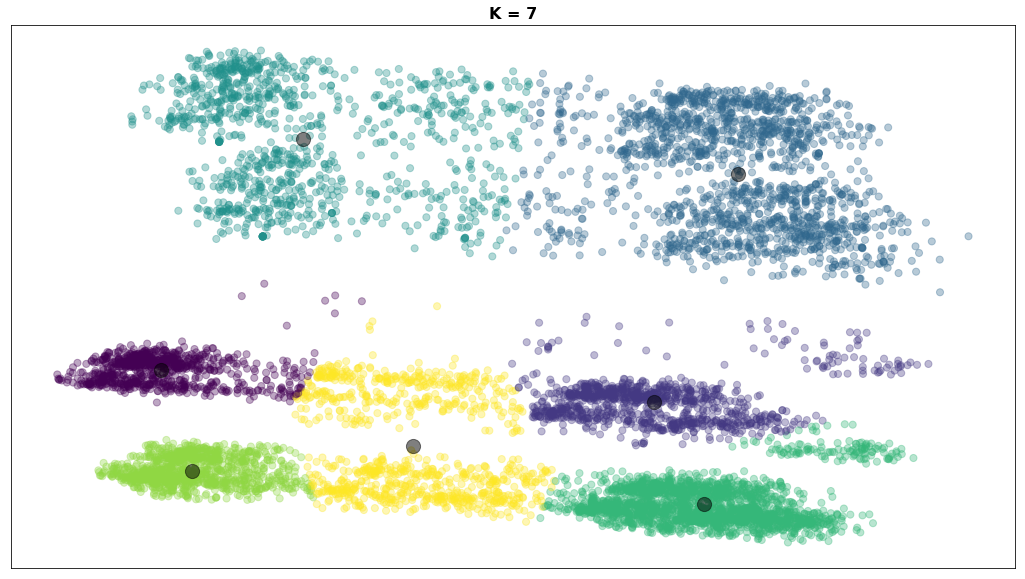

In [248]:
# figure output size:
pylab.rcParams['figure.figsize'] = (18, 10)

# scatter splot of 2 dimensions with k means clustering k=5 applied
plt.scatter(X_resampled_pca[:, 0], X_resampled_pca[:, 1], c=y_kmeans, alpha = 0.35, s=50, cmap='viridis')

# store centroids
centers = kmeans.cluster_centers_

# plot the centroids as black transparent dots
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.title('K = 7', fontsize=16,fontweight='bold');
# make the axes scales not shown:
frame = plt.gca() # get current axes
frame.axes.get_xaxis().set_visible(False) 
frame.axes.get_yaxis().set_visible(False)


<br>  

**Visualizing K-means when K = 8**

In [249]:
# eight clusters
kmeans = KMeans(n_clusters=8)
kmeans.fit(X_resampled_pca)
y_kmeans = kmeans.predict(X_resampled_pca)

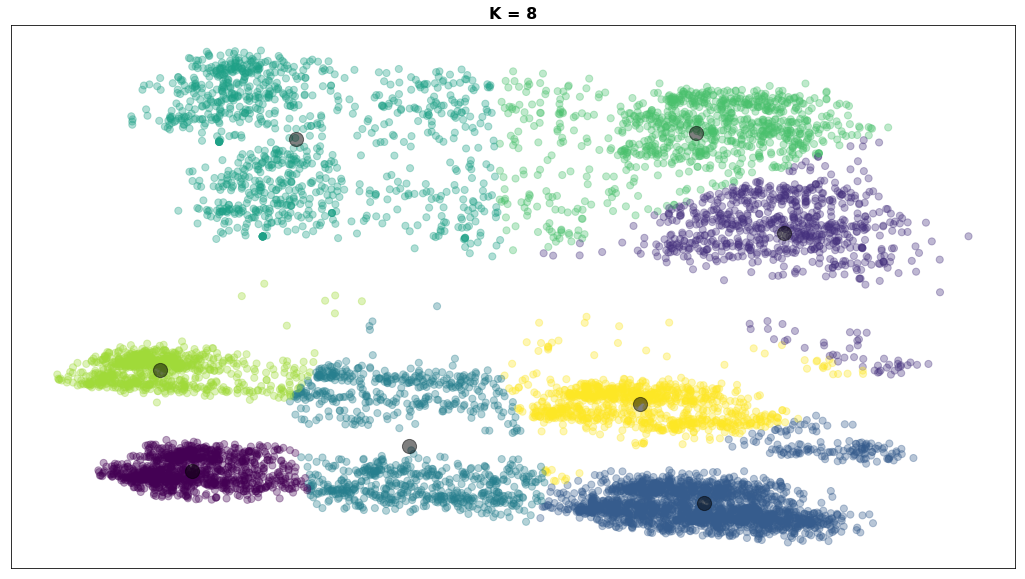

In [250]:
# figure output size:
pylab.rcParams['figure.figsize'] = (18, 10)

# scatter splot of 2 dimensions with k means clustering k=5 applied
plt.scatter(X_resampled_pca[:, 0], X_resampled_pca[:, 1], c=y_kmeans, alpha = 0.35, s=50, cmap='viridis')

# store centroids
centers = kmeans.cluster_centers_

# plot the centroids as black transparent dots
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.title('K = 8', fontsize=16,fontweight='bold');
# make the axes scales not shown:
frame = plt.gca() # get current axes
frame.axes.get_xaxis().set_visible(False) 
frame.axes.get_yaxis().set_visible(False)


<br> 



**Visualizing K-means when K = 9**

In [251]:
# nine clusters
kmeans = KMeans(n_clusters=9)
kmeans.fit(X_resampled_pca)
y_kmeans = kmeans.predict(X_resampled_pca)

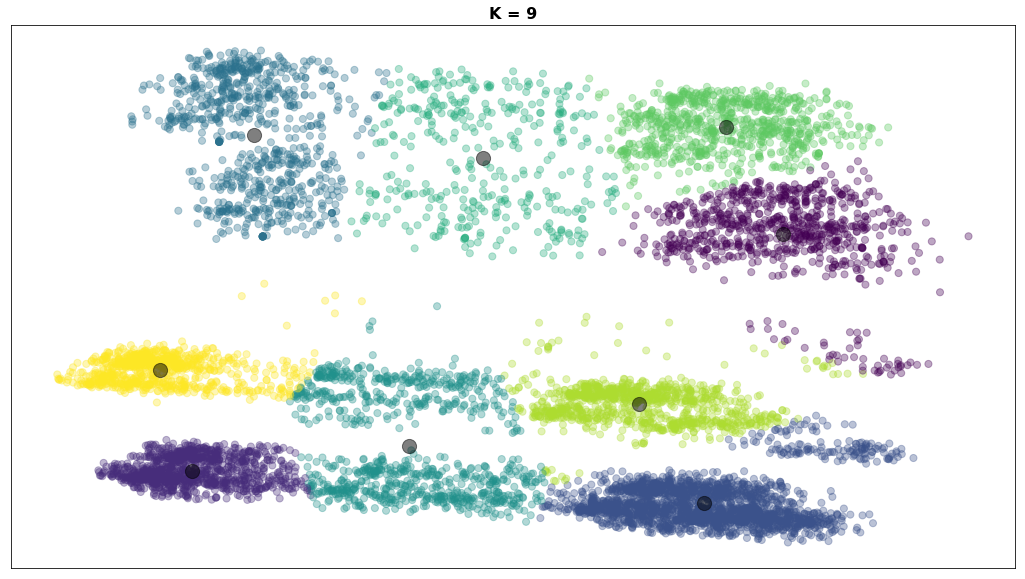

In [252]:
# figure output size:
pylab.rcParams['figure.figsize'] = (18, 10)

# scatter splot of 2 dimensions with k means clustering k=5 applied
plt.scatter(X_resampled_pca[:, 0], X_resampled_pca[:, 1], c=y_kmeans, alpha = 0.35, s=50, cmap='viridis')

# store centroids
centers = kmeans.cluster_centers_

# plot the centroids as black transparent dots
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.title('K = 9', fontsize=16,fontweight='bold');
# make the axes scales not shown:
frame = plt.gca() # get current axes
frame.axes.get_xaxis().set_visible(False) 
frame.axes.get_yaxis().set_visible(False)


<br> 

**Visualizing K-means when K = 10**

In [162]:
# ten clusters
kmeans = KMeans(n_clusters=10)
kmeans.fit(X_resampled_pca)
y_kmeans = kmeans.predict(X_resampled_pca)

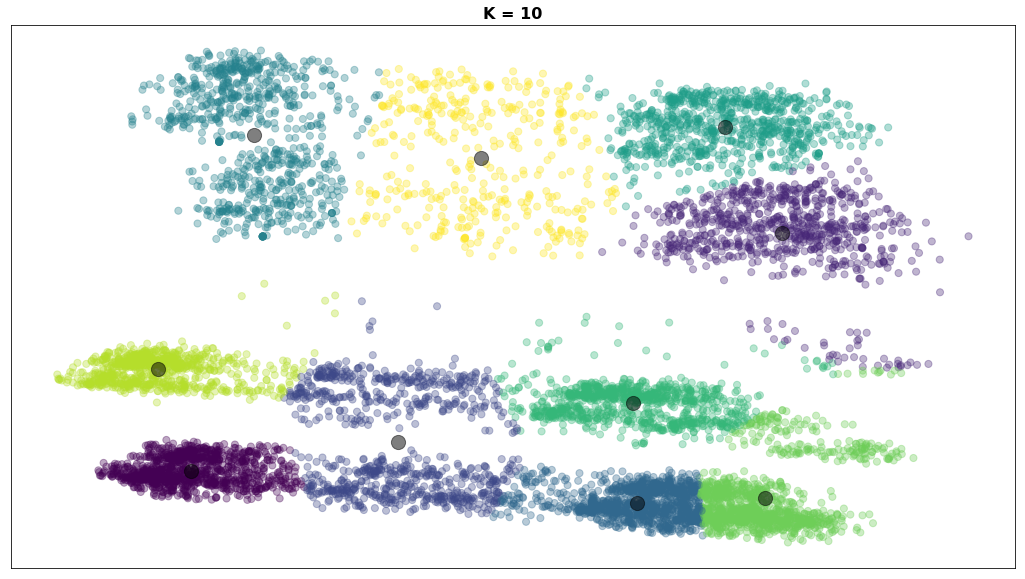

In [164]:
# figure output size:
pylab.rcParams['figure.figsize'] = (18, 10)

# scatter splot of 2 dimensions with k means clustering k=5 applied
plt.scatter(X_resampled_pca[:, 0], X_resampled_pca[:, 1], c=y_kmeans, alpha = 0.35, s=50, cmap='viridis')

# store centroids
centers = kmeans.cluster_centers_

# plot the centroids as black transparent dots
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.title('K = 10', fontsize=16,fontweight='bold')
# make the axes scales not shown:
frame = plt.gca() # get current axes
frame.axes.get_xaxis().set_visible(False) 
frame.axes.get_yaxis().set_visible(False)

<br>  

**Comparing Clustering Results with Silhouette Score**

A silhouette score can range from -1 to 1 with scores closer to 1 denoting a better fit of the number of clusters to the data. These scores combine cluster cohesion and seperation. Cluster cohesion measures the compactness of objects in a cluster based on how closely related they are. Cluster sepearation measures how distinct and well-seperated a cluster is from other clusters.

In [483]:
for n_cluster in range(2, 20):
    kmeansSil = KMeans(n_clusters=n_cluster).fit(X_resampled_pca)
    label = kmeansSil.labels_
    sil_coeff = silhouette_score(X_resampled_pca, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.4465871640448509
For n_clusters=3, The Silhouette Coefficient is 0.5531426256409488
For n_clusters=4, The Silhouette Coefficient is 0.6110358283560174
For n_clusters=5, The Silhouette Coefficient is 0.530959333607743
For n_clusters=6, The Silhouette Coefficient is 0.5158400766306759
For n_clusters=7, The Silhouette Coefficient is 0.5270980034515188
For n_clusters=8, The Silhouette Coefficient is 0.5002777355843603
For n_clusters=9, The Silhouette Coefficient is 0.5009429843369124
For n_clusters=10, The Silhouette Coefficient is 0.48743271681050876
For n_clusters=11, The Silhouette Coefficient is 0.5066808432767933
For n_clusters=12, The Silhouette Coefficient is 0.5082829702397162
For n_clusters=13, The Silhouette Coefficient is 0.5188284067654686
For n_clusters=14, The Silhouette Coefficient is 0.5244018854455293
For n_clusters=15, The Silhouette Coefficient is 0.5141563122707283
For n_clusters=16, The Silhouette Coefficient is 0.51228

Looking at the above silhouette scores it appears that 3 and 4 clusters fit the data the best which reinforces what was learned from the exaplined variance for K-clusters plot.   

That being said, what can be taken away from all of these values as a whole is that there are no obvious number of clusters which are present in the data that K-means can find. What I would like to see is a value of K (or possibly two values) which stands out from the others in terms of its positive silhouette value.

<br>

**Interpretation of K-means Clustering for This Data Set**  


To try to make sense of these clusters, one has to consider what the K-means algorithm is actually producing and what its limitations are. Firstly, although the iterative steps of K-means looks for a locally optimal strategy to cluster the data, the global optimal state may not be achieved. Considering that K centroids are randomly placed in the data, this stocastic tendency means that we could run K-means from the start multiple times over and get different results. If we are lucky, perhaps the globally optimum state is achieved but that also has a lot to to with the characteristics of the data. Secondoly, notice how K-means tries to cluster the data into globs with linearly seperable boundaries. If the data naturally clusters into evenly spherical clusters then K-means will have little issue finding these naturally occuring clusters. The problem arises when the natural clusters take on strange shapes and do not occupy an equal space. In the current example, the natural clusters are not globular which is a problem for K-means; the natural clusters in the data do not seem to be found by K-means.   

Further more, the boundaries of K-means are always linear, but perhaps the natureal clusters are not linearly seperable. In the example of this data set, the clusters have some more complex geometries which leads K-means to find locally optimal solutions but globally non-optimal clusters.  

K-means also has an issue finding natural clusters when one cluster is significantly large than others. In this example, there seems to be three vertical clusters with the top cluster being much larger than the bottom two. One might also say that there are 4 clusters with two vertical ones on the bottom and two clusters on the top. Either way, these clusters are not going to be found optimally with K-means.   

K-means also has trouble finding clusters of different densities. For instance, notice how the smaller clusters on the bottom are much more dense than the larger cluster(s) on the top. One good thing, however, is that since this data has been reduced with PCA much of the noise is no longer present. It the data were highly-dimensional and had outliers the calculations of distances and means would no longer produce good results.   

Something interesting that can be seen by look at the top half of the plot is that there are some clusters which are reasonably ideal for K-means. Esspecially the clusters at the top left and right are somewhat spherical and linearly seperable. K-means has done a decent job clustering these data points into individual clusters.  

Although K-means is not very good here, a density-based clustering approach which can find different shaped clusters such as DBSCAN would likely be more appropriate. 


### Expectation Maximization - Gaussian Mixture

Recall that K-means computes distances of all points to each cluster to assign cluster membership. Although this is very intuitive, we saw that it has many practical issues when clustering non-globular and symetric clusters. What K-means does not account for is uncertainty in assigning clusters. We would be more certain about the cluster membership of clusters which are more spaced out than cluster membership of clusters which are close-together and even overlapping.  

The Guassian Mixture model does include a probabilistic measure of the probability of each point belonging to each cluster by factoring in the distance of each data point to each cluster center rather than focusing only on the minimal distance to the closest cluster. 

In [576]:
probabilities = gmm.predict_proba(X_resampled_pca)
print(probabilities[:1].round(3))

[[ 0.     0.     0.     0.     0.     0.002  0.994  0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.004  0.     0.     0.   ]]


The Gaussian Mixture model uses an expectation maximization process similar to K-means expect at the expectation step it accounts for the probability of each cluster membership. Also, at the maximization step, instead of only the location of the cluster center being repositioned based only on data points which fall into any one cluster, the clusters location and shape are updated based on all data points. Thus, the clusters do not have to be spherical like in K-means.  

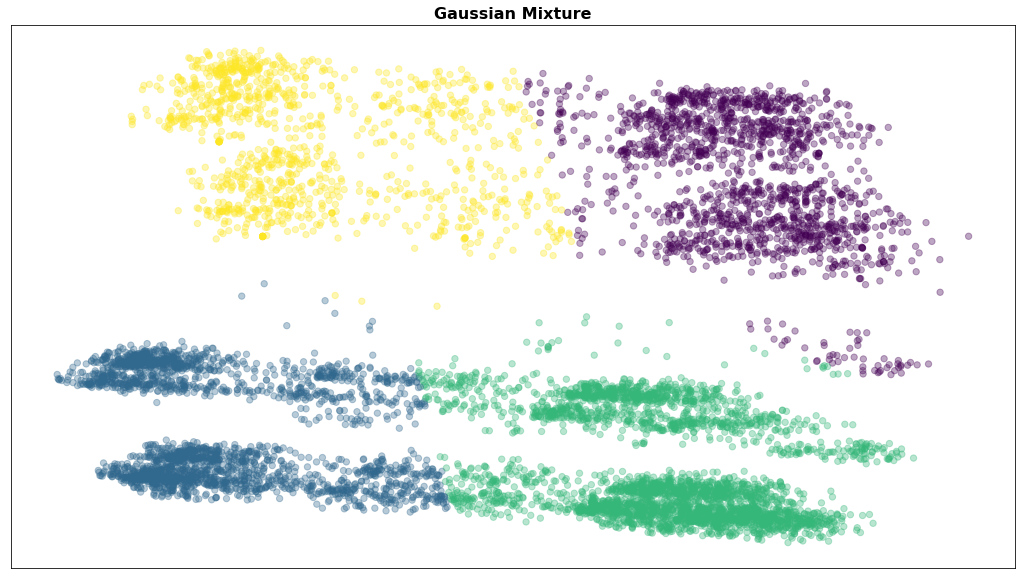

In [182]:
# fit with 4 clusters to data
gmm = GMM(n_components=4).fit(X_resampled_pca)

# cluster labels
labels = gmm.predict(X_resampled_pca)

# plot with colour by cluster labels and alpha for transparency
plt.scatter(X_resampled_pca[:, 0], X_resampled_pca[:, 1], c=labels, s=40, alpha = 0.35, cmap='viridis');
plt.title('Gaussian Mixture', fontsize = 16, fontweight = 'bold')
# make the axes scales not shown:
frame = plt.gca() # get current axes
frame.axes.get_xaxis().set_visible(False) 
frame.axes.get_yaxis().set_visible(False)

The results of fitting the GM model to the data set are incredibly similar to the result of fitting K-means to the data. I believe this is because although the shape of the cluster can change, it tends towards half-moon shapes. Again, the nature of the clusters in this data set are not adequately represented in this way. The only thing that really differs from fitting K-means to the data is the cluster membership of data points towards the cluster boundaries. It isn't easy to notice but you can see by looking at the data points near the boundaries that the shape of the clusters are not quite the same as in K-means.  

<br>  

### Center-Based Density: DBSCAN  

I mentioned before the K-means did not seem appropriate for the natural cluster shapes and sizes of this data. I also mentioned that I thought DBSCAN would be more appropriate and interesting to implement with this data. DBSCAN is not an expectation-maximization algorithm which moves cluster centroids around based on some function. The cluster centers are not centroids but rather there are many centers reffered to as core points. DBSCAN is a density-based clustering algorithm which looks through the data for high-density areas which are seperated by lower density areas. These low density areas DBSCAN labels as noise points not belonging to any one cluster.   

There are three types of points DBSCAN identifies: 

* **Core points** are within the interior of a cluster and are determined to be core points based on the number of other points in its neighbourhood. The number of points within any one points neighbourhood is based on a distance parameter as well as a paramter referred to as **Eps** (epsilon). The distance measure used is euclidean distance by default. Epis defines the maximimum distance between two points for them to be considered in the same neighbourhood. The clusters as result of DBSCAN are also influenced by the parameter **MinPts** (min_samples in SciKit learn) which defines the minimum number of points which need to fall within any one points neighbourhood for it to be considered a core point. By tuning these parameters, the results of DBSCAN change drastically. These core points are at the heart of what are reffered to as *center-based density approaches* which includes DBSCAN.  

* **Border points** are not core points but they fall within the neighbourhood of a core point or perhaps multiple core points. 

* **Noise points** a noise point is neither a core nor border point.  

<br>  

I will visuzalize the results of DBSCAN while tuning the epsilon parameter. By default the min_samples parameter is set to 5 which I think is appropriate. 



<br> 

In [103]:
# define plot_clusters which will be used for all four displays below. algorithm could be replaced with dbscan because
# I am only using dbscan
def plot_clusters(X_resampled_pca, algorithm, args, kwds): # args allows one to pass a variable number of arugments to a function
    labels = algorithm(*args, **kwds).fit_predict(X_resampled_pca) # kwds allows any number of key words to be passes as arguments
    palette = sns.color_palette("muted", np.unique(labels).max() + 1) # colour palette with number of colours equal to number
                                                                      # of labels plus one for noise points
    # 0 in the color pallete = black. This assigns noise points not assigned to any of the cluster labels a colour of black. 
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels] 
    # scatter plot of the resampled points after pca with colour and alpha defined for transparency
    plt.scatter(X_resampled_pca.T[0], X_resampled_pca.T[1], c=colors, s=40, alpha = 0.35, cmap='viridis')

<br>  

Below are visualizations of the results of DBSCAN with the epsilon parameter altered. Noise points are displayed as black dots while core and border points are displayed in colour.

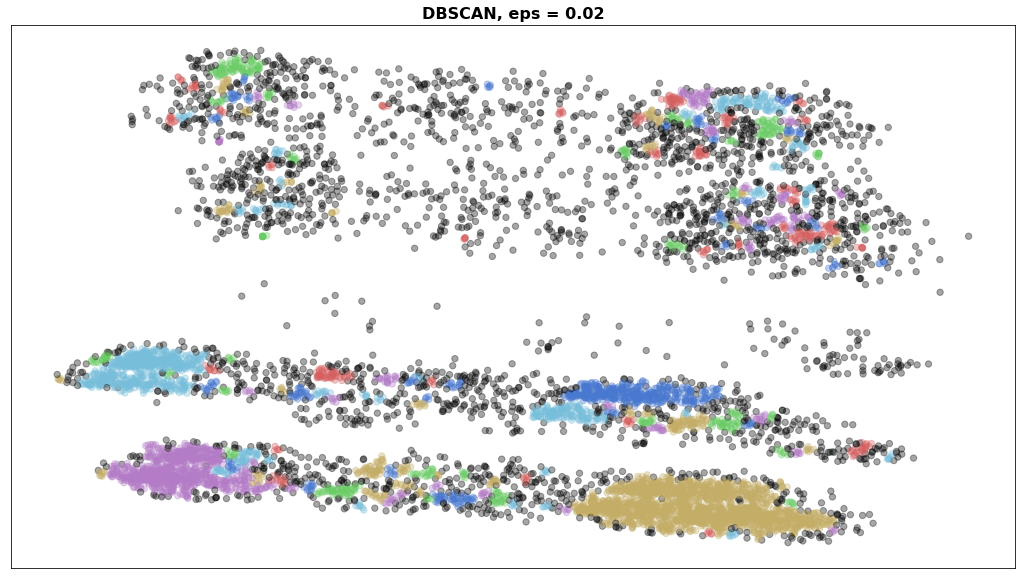

In [104]:
# plot size
pylab.rcParams['figure.figsize'] = (18, 10)

# plot the clusters based on dbscan
plot_clusters(X_resampled_pca, cluster.DBSCAN, (), {'eps':0.02} )
# add title in bold
plt.title('DBSCAN, eps = 0.02', fontsize = 16, fontweight = 'bold')
# make the axes scales not shown:
frame = plt.gca() # get current axes
# hide axes:
frame.axes.get_xaxis().set_visible(False) 
frame.axes.get_yaxis().set_visible(False)

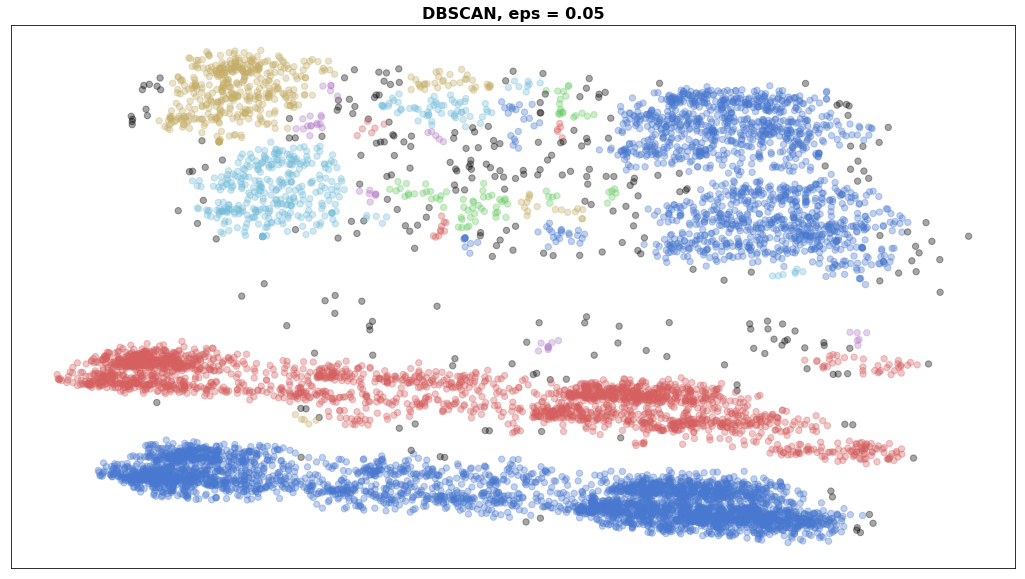

In [105]:
# plot size
pylab.rcParams['figure.figsize'] = (18, 10)

# plot the clusters based on dbscan
plot_clusters(X_resampled_pca, cluster.DBSCAN, (), {'eps':0.05} )
# add title in bold
plt.title('DBSCAN, eps = 0.05', fontsize = 16, fontweight = 'bold')
# make the axes scales not shown:
frame = plt.gca() # get current axes
# hide axes:
frame.axes.get_xaxis().set_visible(False) 
frame.axes.get_yaxis().set_visible(False)

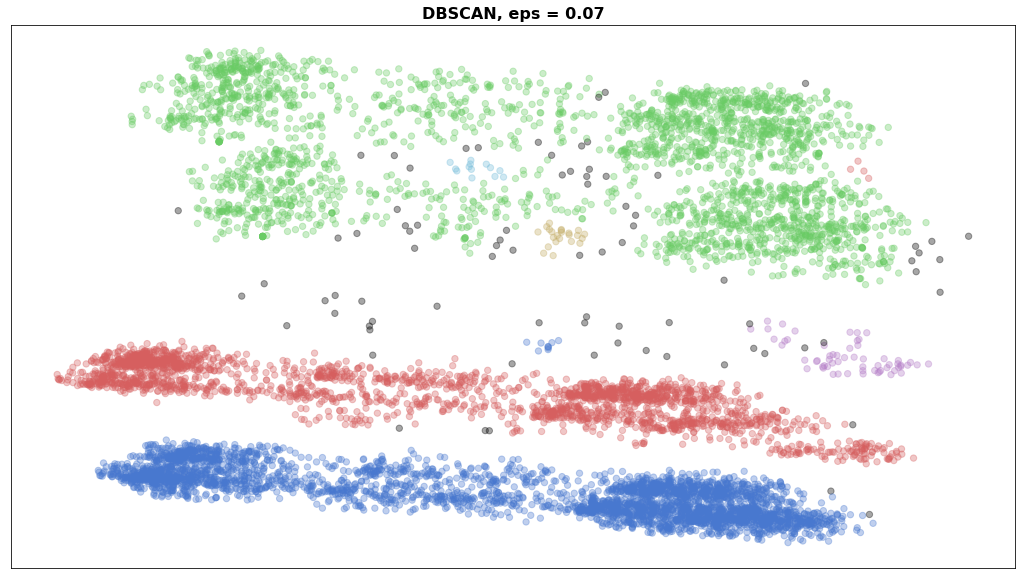

In [106]:
# plot size
pylab.rcParams['figure.figsize'] = (18, 10)

# plot the clusters based on dbscan
plot_clusters(X_resampled_pca, cluster.DBSCAN, (), {'eps':0.07} )
# add title in bold
plt.title('DBSCAN, eps = 0.07', fontsize = 16, fontweight = 'bold')
# make the axes scales not shown:
frame = plt.gca() # get current axes
frame.axes.get_xaxis().set_visible(False) 
frame.axes.get_yaxis().set_visible(False)

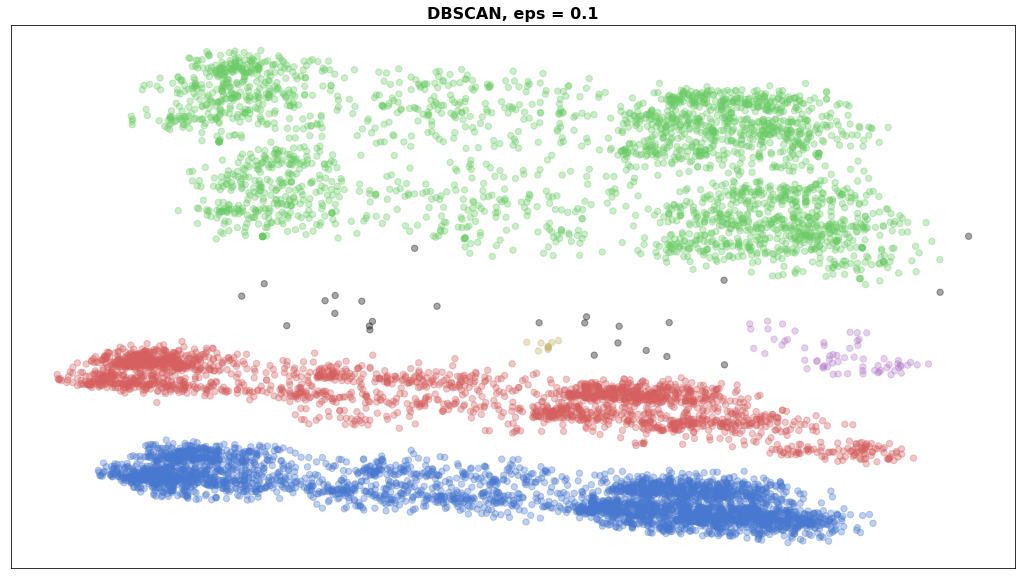

In [107]:
# plot size
pylab.rcParams['figure.figsize'] = (18, 10)

# plot the clusters based on dbscan
plot_clusters(X_resampled_pca, cluster.DBSCAN, (), {'eps':0.1} )
# add title in bold
plt.title('DBSCAN, eps = 0.1', fontsize = 16, fontweight = 'bold')
# make the axes scales not shown:
frame = plt.gca() # get current axes
frame.axes.get_xaxis().set_visible(False) 
frame.axes.get_yaxis().set_visible(False)

It is quite obvious that DBSCAN is much more capable of finding the natural clusters in the data. Looking at the different results for the differing values of eps provides a great learning opportunity. Recall that epsilon defines the maximum distance between two points for them to be considered in the same neighbourhood,measured in eucidean distance. With eps set at a low value (0.02), we can see that DBSCAN has found many small, uniquely-shaped clusters in the most dense areas of the data. That being said, DBSCAN has also labeled a lot of points as noise points, even in locations which are quite dense relative to the overall nature of the data. With eps being so low, many larger clusters are overlooked for smaller, more dense clusters. Setting eps to a higher value (0.05), we can see that DBSCAN has labeled far fewer points as noise points and distinguished the larger clusters in the data. Notice how towards the top of the display there are many noise points because the points are quite sparse yet seem to be more closely clustered in certain areas. When epsilon is increased again to 0.07, even fewer noise points are labeled as such and the more spare clusterings towards the top of the display are labeled together. We can see the influence of increasing the maximum distance required for points to be within the same neighbourhood. There are stil some smaller clusters towards the top of the display which get clustered into one larger cluster when epsilon is increased to 0.1. In this final display, there are three large clusters, two smaller clusters, and only a few noise points in the middle of the display. Notice how small the smallest cluster is. It looks to be about 7 points in total and is just within the MinPts preset value of 5.  

As seen, some of the strengths of DBSCAN are that it is resistant to noise in a way which K-means is not. Points away from the clusters are simply labeled as noise using DBSCAN while these points would impact the cluster position using K-means. DBSCAN can also find clusters of unique shapes and sizes which K-means could not. K-means could only find globular shaped clusters which in this case were not suitable. That being said, it is also clear that DBSCAN had trouble determining clusters which had varrying densities. This was most noticible towards the top of the displays where the data were tightly clustered towards the right and left sides but were more sparse in the center. 

 <br> 
 
## Supervised Learning  

<br>  

In this section, classification models will be induced from a training set of data in which class labels are known and applied to a test set of data in which class labels are unknown in which labels are predicted by the model. The performance of the models will be varified with 10-fold cross-validation (described later). 

### Artificial Neural Network with class imbalance data and resampled data    

The classifier used in the section is a multilayered perceptron model which trains using backpropigation. The model is based off of the human brain and contains an input layer which has a number of nodes (similar to neurons) equal to the number of attributes in the data set. In this case there are 178 nodes after mapping. The model learns the assignment of class labels by allowing attribute values to flow in one direction from the input layer to a number of hidden layers and finally to an output layer which assigns class labels all the while experiencing different weights on the paths between nodes. The output layer in a two class problem is usually one node. Weights connect the output of each node in each layer to all nodes in the next layer. Values are multipled by the weights resulting in the values of the hidden layer. These hidden layer values are then converted to a probability between 0 and 1. The assignment of class labels is based on this probability which is the result the process above and is called forward-propigation. Next, the most interesting step of the model is undertaken. The class label assigned is compared to the actual class label of the record and if it is incorrect it is fed back through the network so that the network can find the optimal weights which can be used to predict the class label of any input correctly. An error in predicting class labels is computed and compared against different weight values. When visualized, this looks like a U with error rate on the y- axis and weight values on the x-axis. When the value of the weight is too small the error rate is also high, when the value of the weight is too low then the error rate is high again. In the middle, at the correct weight, the error rate is minimized. This weight is chosen as the optimal weight. This optimal weight is required for each node. Starting with random weights the goal is to continuously move in the right direction towards the bottom of the U where the error rate is the lowest. This U is called the gradient and the process of making steps towards the lowest part of the gradient which is associated with the lowest error rate is called gradient descent. Eventually this process leads to the weight associated with the mimimal error.  

The downside to this is that neural nets suffer from getting caught in local minima where although it seems they are stepping in the right direction to reduce error rate, it is possible that the true globally lowest state is not within the local surroundings and thus what appears to be the best result was, in reality, simply the best local result.


**Checking perfomance of model WITHOUT class balance (non-resampled data)** 

First I am going to see how the model predicts each class using the imbalanced dataset before resampling was done to balance the classes. Like I previously discussed, the quality of predictions for collisions which did not result in fatality should be very good since the vast majority of records fell into this class. I mentioned the classifier could predict all records were associated with the second class and it would be correct in 98% of cases. Therefore, I am not concerned with accuracy as an overall metric. 

**Holdout Method**  

Using the holdout method, the orginal data is split into two sets: one for training and one for testing. The size of the training set is often two thirds of the data, while the test set makes up one thrid of the data. The classification model is induced from the training set and is applied to the test set to evaluate its performance in predicting the class labels of unseen data.  

One of the well-known limitations of the holdout method is that it does not maximize the number of records for training. Because a portion of the data is being 'held out' for testing, these records are not available to the model during training. As result, the model which is induced using holdout has seen less data and may not perform as well as it could have if all records were available during training.  

The composition of the sets are also very important. The smaller the training set the larger the variance in the model thus we are less confident in its predictions. A training set too large is also a problem because when the performance of the model is computed on the proportionally small test set its results are not very reliable and it are hard to interpret.  

The final problem is that when using the holdout method the training and test sets are no longer independent and so a class which is over or underrepresented in one of the sets will be the opposite in the other set.  

This last limitation of the holdout method is very important to consider for the unbalanced data set. If the fatal class is under or overrepresented in the training set, the induced models evaluation on the test set will not reflect what it should reflect. Thankfully, the train_test_split alogorithm in SciKit learn takes into account the breakdown of classlabels when splitting data into testing and training sets. 

In [80]:
# split the non-resampled data in test and training sets:

X_train, X_test, y_train, y_test = train_test_split(subData, Target)

In [81]:
#define the classifyer as a multi-layer perceptron neural net with 3 layers, 30 modes in each. 

mlp = MLPClassifier(hidden_layer_sizes=(178,))

I chose one hidden layer with 178 nodes, 1 for each attribute in the data set. 

In [320]:
# fit the network to the data:

mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(178,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [321]:
# store the predictions taken from fitting the network to the data: 

predictions = mlp.predict(X_test)

Recall:  


* a True Positive corresponds to the number of positive exampled correctly predicted as positive by the model. 
* a False Negative correponds to the number of positive examples wrongly predicted as negative by the model. 
* a False Positive corresponds to the number of negative examples wrongly predicted as positve by the model. 
* a True Negative corresponds to the number of negative exampled correctly predicted as negative by the model.

In [322]:
# print the confusion matrix of the predicted class labels:

print(confusion_matrix(y_test,predictions))

[[  568   533]
 [  161 81337]]


Above is a confusion matrix of the predicted classes of the unbalanced data. As can be seen, class 1 (fatality) was correctly predicted 568 times and incorrectly redicted 161 times. On the other hand, class (non-fatal) was correctly predicted 81,337 times and inccorectly predicted 533 times. If I were interested in the accuracy of this model. it would be the number of correct predictions made by the model divided by the total number of predictions made. The inverse of this metric, with inccorect predictions in the numerator and total predictions in the demoninator would give me the overall error rate of the model. That being said, I am not interested in accuracy and error rate with imbalanced data because, as previously mentioned, the model could always predict the second class and be right 98% of the time. 

In [323]:
# print out the performance metrics:

print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          1       0.78      0.52      0.62      1101
          2       0.99      1.00      1.00     81498

avg / total       0.99      0.99      0.99     82599



The performance metrics I am really interested in are precision and recall. These metrics are very interesting when the successful detection of one class is more significant than the detection of the other class. In this example, there are far fewer records associated with the first class so successful predictions of this class are more significant. Not to mention, the first class includes individuals who died as result of a collision so it is important to predict this label.   

>**Precision** is the fraction of records that were predicted to be the positive class which actually were the positive class. It is the ratio of true positives over true positives plus false positives. The higher the precision score, the lower the number of false positive (type I) errors committed by the classification model.  

>**Recall** is the fraction of positive cases correctly predicted by the model. High recall means the model misclassified very few positive examples as negative. The recall is identical to the true positive rate (sensitivity) in that it is the ratio of true positives over true positives and false negatives.   

>The F1 measure is simply a harmonic mean of the precision and recall. Since the harmonic mean is usually closer to the smaller of the numbers added into the equation, a high F1 informs us that the precision and recall are both relatively high. 





Evaluation for this data:

For the unbalanced dataset, 78% of the records which the neural network classified as the first class (fatal) turned out to be that class. This means the model had quite a low number of false positives where non-fatal collisions were wrongly predicted as fatal collisions.  

The recall of the neural net for the first class (fatality) was quite low at only 52%. This means that a lot of fatal collisions were misclassified as non-fatal collisions. Therefore, the sensitivity of this classifier is low and the false negative rate is high. 

>### **What matters more in this situation? False positives or false negatives?** 

>The number of false negatives is very important to this analysis. False positives do not have a negative consequence. It is far worse to misclassify a fatal collision as non-fatal than it is to classify a non-fatal collision as fatal. Because this model had a high number of false negatives, many fatal collisions were wrongly predicted as non-fatal collisions. This is perhaps the most important metric to evaluate this model with the unbalanced class distrubtion. If this were a real-world scenario and this model was used to inform a risk-prevention campaign the parameters would need to be adjusted and the model would need to be rerun many times on new data.   

> In other words, the model must have high sensitivity meaning its true positive rate must be very good. Sensitivity is defined as the fraction of positive exampled predicted correctly by the model. A true positive rate cannot be very high if the number of false negatives made by the model are also high. The model really must predict fatalities correctly to be adequate.   

> The specificity of the models predictions (true negative rate) is not very important because, as previously mentioned, the number of false positives are not a concern. 

<br>  

**10-Fold Cross-Validation**  

I overviewed the limitations of the holdout method. These limitations can be overcome using K-fold cross validation. 

With K-fold cross-validation, each record is used the same number of times for training and exactly once for testing. Using 10-fold cross-validation I can get a sense to what extent the performance of the classifier can be accounted for by its overfitting the training data. First the data is partitioned into 10 subsets and during each induction cycle one of the subsets is used for testing the model while the rest are used for training. This process is repeated 10 times so that each subset is used once for testing. With this method, the performance of the model can be evaluated while using all data for training thus maximizing the amount of data the model is induced with. If performance metrics significantly drop via cross-validation then it is reasonable to believe that a considerable amount of the classifiers performance can be accounted for by overfitting the training data rather than true relationships in the data.

**Warning**: Running the below 10 fold validation will some time.

In [324]:
# define performance metrics:
scoring = ['precision_macro', 'recall_macro']


# rerun the network with 10 fold cross validation:
scores = cross_validate(mlp, subData, Target, scoring=scoring,
                       cv=10, return_train_score=False)

In [325]:
# show index of keys for later printing:
sorted(scores.keys())

['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']

In [326]:
# see recall for each fold:
scores['test_recall_macro'] 

array([ 0.71135553,  0.7325345 ,  0.7297756 ,  0.69405281,  0.67949225,
        0.65305706,  0.71420148,  0.71998863,  0.72960393,  0.69857656])

Above is the recall of the neural net for all 10 folds. As can be seen, the lowest recall value was about 65% while the highest was over 73%.

In [327]:
# print average recall of across all folds:
print("Recall: ", scores['test_recall_macro'].mean())

Recall:  0.706263834391


Above is the average recall of the classifier for all 10-folds of cross-validation. 

After cross-validation the recall is about 71% which gives me a lot more confidence in the model. With this measure of recall far fewer fatal collisions were misclassified as non-fatal collisions. This is likely the case because the model has more data for training and was able to see more records of the fatal class to make better predictions about these cases. It could also have to do with the fact that I am now looking at an overall recall value rather than recall values for both classes.

In [328]:
# see precision for each fold:
scores['test_precision_macro'] 

array([ 0.84005182,  0.74831871,  0.7297756 ,  0.82541551,  0.70948536,
        0.51515212,  0.68778337,  0.77441207,  0.80190952,  0.73062008])

Above are the precision values of the neural net for all 10 folds of cross-validation. The highest precision value was 84% and the lowest precision value about 52% (yikes). 

In [329]:
# print average precision across all folds:
print("Precision: ", scores['test_precision_macro'].mean())

Recall:  0.736292416633


The overall precision of the classifier with cross-validation slightly decreased but I am less concerned about this measure than I am about recall. 

I would be interested to see the results of this model on the entire data set before taking my refined subsample. I would like the know the precision and recall of the model with more training data.  

<br>  



**Checking perfomance of model WITH class balance (resampled data)** 

<br>  

Now I will see how the model does using the resampled data. With balanced classes the quality of predictions for collisions which resulted in fatality should be much better.   

Considering I am not looking at unbalanced classes now, I am less concerned precision and recall and quite interested in overall accuracy of the neural net. As a reminder:

> **Accuracy** The ratio of the number of correct predictions divided by the total number of predictions made

**Holdout Method**

In [82]:
# split the resampled data into training and testing sets:

X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled)

In [83]:
# fit the network to the data:

mlp.fit(X_train_resampled, y_train_resampled)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(178,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [84]:
# store the predictions taken from fitting the network to the data: 

predictions = mlp.predict(X_test_resampled)

In [85]:
# print the confusion matrix of the predicted class labels:

print(confusion_matrix(y_test_resampled,predictions))

[[926 201]
 [165 881]]


As can be seen from the above confusion matrix. The classifier correclty predicted fatal collisions 926 times (seen in upper left position of the matrix) out of a total 1091 predictions made for that class. The classifier correctly predicted non-fatal collisions 881 times (seen in the lower right position of the matrix) out of a total 1082 predictions made for that class.  

**Accuracy** = (926 + 881) / (1091 + 1082) x 100 =  **83.16%**  

This is a good accuracy value and this shows that the errors made by the model after class balance were few and far between. That being said, the predictive quality could be improved. It would be interesting to how the model would run if I resampled from the entire data set rather than a portion of it.

In [87]:
# print out the accuracy score:

print(accuracy_score(y_test_resampled,predictions))

0.831569259089


<br> 

### **Caveat** 

Although this accuracy is quite good, it has to be kept in mind that the model is predicting class labels for a data sets whose class labels are balanced. It is not always common in real world scenarios to have balanced classes one is trying to predict. I believe it is much more interesting and important to work with unbalanced classes than it is to work with balanced classes. Even when we consider just this data alone we see that extreme class imbalance is, and always has been, the case. Far fewer collisions result in fatality than those which do not result in fatality. Because of this, the above accuracy of the model does not reflect its performance on the raw data. The only thing which can be concluded is the model has an accuracy of 83% when predicting class labels on a balanced subset of the refined subsample which included the most recent 10% of the overall database. In the future, tuning this model with the unbalanced data set would be worth-while.  

That being said, perhaps modelling the balanced data is actually the better approach. In such a case, the model can learn an equal amount of information from records associated with both classes. Randomly undersampling the dominant class has created an environment where the classifier can learn the characteristics of collisions which resulted in a fatality. This is very important if we want to correctly predict these collisions. 

<br> 

**10-Fold Cross-Validation**

In [90]:
# using 10 fold cross validation with accuracy as performance metric:

scores = cross_validate(mlp, X_resampled, y_resampled, scoring='accuracy',
                       cv=10, return_train_score=False)

In [91]:
# show index of keys for later printing:
sorted(scores.keys())

['fit_time', 'score_time', 'test_score']

In [94]:
# print accuracy scores for each fold as percent
print("Accuracy: ", scores['test_score'] * 100)

Accuracy:  [ 78.96551724  74.94252874  78.04597701  74.25287356  73.44827586
  70.8045977   75.34562212  78.22580645  77.64976959  73.96313364]


The above values shows the accuracy scores of the classifier for each of the 10 folds of cross-validation. The highest accuracy was about 79% and the lowest accuracy was 73.45%. 

In [96]:
# print average accuracy of all 10 folds as percent
print("Accuracy: ", scores['test_score'].mean() * 100)

Accuracy:  75.5644101912


Above is the average accuracy for all 10 folds of cross-validation. Overall this is an acceptable accuracy but there is room for improvement. The average accuracy as result from 10-fold cross-validation is quite similar to the accuracy of the classifier as result of the holdout method. Because of this, overfitting the training data during holdout was a reasonable concern.  

<br> 

### Descision Tree Induction
  
<br> 

A decision tree is a classification model which essentially asks a series of questions which are used to split the data set into binary branches. At each stage of the tree the data set becomes more refined as the tree cuts the data roughly in half based on the values of an attribute. By asking a series of questions, the tree grows and it finds the splits which can seperate data into class labels and makes class predictions based these splits. 

**Checking perfomance of model WITHOUT class balance (non-resampled data)**  

**Holdout Method**

In [109]:
# split data into train and test sets
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(subData, Target)

In [126]:
#  import decision tree classifier
from sklearn import tree

#  store in tree object
Tree = tree.DecisionTreeClassifier(random_state = 0)


In [127]:
# fit decision tree to the training data
Tree.fit(X_train_tree, y_train_tree)
predictions = Tree.predict(X_test_tree)

In [128]:
# print the confusion matrix of the predicted class labels:

print(confusion_matrix(y_test_tree,predictions))

[[  641   481]
 [  540 80937]]


Above is a confusion matrix of the class labels predicted by the decision tree. 641 of the fatal class were correctly predicted out of a total 1181 predictions made for this class. 80,937 of the non-fatal class were correctly predicted out of a total 81,418 predictions made for this class. As seen, the vast majority of records were predicted to be the non-fatal class which would yeild a high accuracy but would not give any merit to this model as predicting the fatal class is more crucial. 

In [129]:
# print out the performance metrics:

print(classification_report(y_test_tree,predictions))

             precision    recall  f1-score   support

          1       0.54      0.57      0.56      1122
          2       0.99      0.99      0.99     81477

avg / total       0.99      0.99      0.99     82599



It seems the decision tree made a lot of false positives when predicting the fatal class. This can be seen by the low precision value. The decision tree also made many errors in classifying fatal collisions as non-fatal collisions. This can be seen in the low recall value. This is understandable because as the decision tree looked for ways to split the data it built these splits in a way which was biased to the majority class. It is likely that the decision tree is uncertain how to split the data to accurately predict the rare class because not enough records associated with the rare class are present. 

Decision tress also have a strong likelihood of overfitting the training data, essentially modelling the noise particular to the training data rather than the relationships which can be generalized to unseen data of the same population. For this reason it is important to look at results via cross-validation.

**10-Fold Cross-Validation**

In [159]:
# get precision and recall as metrics
scoring = ['precision_macro', 'recall_macro']

# 10 fold cross validation
scores = cross_validate(Tree, subData, Target, scoring=scoring,
                       cv=10, return_train_score=False)

In [160]:
# see recall for each fold:
scores['test_recall_macro'] 

array([ 0.71121611,  0.74097778,  0.73101562,  0.71001997,  0.68680144,
        0.60206371,  0.71132993,  0.74214456,  0.72779439,  0.70352611])

In [161]:
# print average recall of across all folds:
print("Recall: ", scores['test_recall_macro'].mean())

Recall:  0.706688962385


Because this recall value is an overall recall measure it does not seem to have changed much.

In [162]:
# see precision for each fold:
scores['test_precision_macro']

array([ 0.71363935,  0.69474815,  0.67344831,  0.68024349,  0.66188559,
        0.50673064,  0.6732408 ,  0.68293532,  0.72125772,  0.67461251])

As seen above, the precision taken from one of the folds is very low (51%) compared to the highest precision (72%). This huge range depicts why it is important to use a method like cross-validation to get more clear overall results. 

In [163]:
# print average recall of across all folds:
print("Precision: ", scores['test_precision_macro'].mean())

Precision:  0.668274185509


The overall precision of the model is quite weak; the decision tree made many false positives and its performance on this data set overall is not adequate.

<br>  

**Checking perfomance of model WITH class balance (non-resampled data)**  

**Holdout Method**

In [168]:
# split data set into test and train
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_resampled, y_resampled)

In [169]:
# fit decision tree
Tree.fit(X_train_tree, y_train_tree)
predictions = Tree.predict(X_test_tree)

In [170]:
print(confusion_matrix(y_test_tree,predictions))

[[877 204]
 [262 830]]


Not surprisingly the confusion matrix is quite symmetrical with 877 true positives, 830 true negatives, 262 false positives, and 204 false negatives. 

In [171]:
# print out the accuracy score:

print(accuracy_score(y_test_tree,predictions))

0.785549930971


The overall accuracy of the decision tree when predicting class labels for the balanced data is quite good. Now the tree has an adequate number of records from both classes to use for determining splits during training. Recall though that overfitting is common when fitting a decision tree so I will compare this to the accuracy of the tree via 10-fold cross-validation.

**10-Fold Cross-Validation**

In [177]:
# 10 fold cross validation returning accuracy as metric

scores = cross_validate(Tree, X_resampled, y_resampled, scoring='accuracy',
                       cv=10, return_train_score=False)

In [178]:
# print accuracy scores for each fold as percent
print("Accuracy: ", scores['test_score'] * 100)

Accuracy:  [ 73.10344828  74.48275862  77.12643678  71.83908046  72.75862069
  74.36781609  72.11981567  74.88479263  74.53917051  74.19354839]


The accuracy for the tree for each fold is quite consistent here with the highest accuracy being about 77% and the lowest being about 72%.

In [179]:
# print average accuracy of all 10 folds as percent
print("Accuracy: ", scores['test_score'].mean() * 100)

Accuracy:  73.9415488108


The average accuracy as result of cross-validation is not surprisingly slightly lower than that seen using the holdout method. Most of the predicitons made by the decision tree were correct but there is room for improvement.

<br> 


### Emsemble Method: Random Forests

<br>  

Rather than predicting class labels based on a single classifier induced from the training data, emsemble methods try to improve performance by aggregating th predictions of multiple classifiers and voting across them. Ensemble methods take a set of classifiers and predicts class labels by taking a vote of the predictions made by each classifier. The majority vote wins; if 51 out of 100 classifiers vote for a particular class label, that class label is predicted by the ensemble. In the case of ensemble methods, the sum of the votes is greater than the individual predictions. By taking a majority vote across multiple classifiers, the results of ensemble methods are often higher quality than that of any one classifier.   

This is a very powerful method because the ensemble makes wrong predictions only if more than half of the individual classifiers made the wrong predictions. Because of this, the error rate of the ensemble is lower than that of the individual classifiers. Ensembles perform well if the base classifiers are independent of each other (their error rates are not correlated) and their predictions are significantly better than predictions made by random guessing.   

Random forest is a an ensemble method designed for decision trees. It votes across the predictions of multiple decision trees which have been generated from the values of random independant vectors. The random component ensures the correlation between trees is reduced so the generalization error of the ensemble is improved. 

<br>  


**Checking perfomance of model WITHOUT class balance (non-resampled data)**  

**Holdout Method**

In [181]:
# split data into train and test sets
X_train_forest, X_test_forest, y_train_forest, y_test_forest = train_test_split(subData, Target)

In [182]:
# random forest classifier
randForest = RandomForestClassifier(n_estimators = 100, random_state = 0)

Specifying n_estimators = 100 means that the ensemble will grow 100 decision trees randomly and vote across their predictions.

In [183]:
# fit random forest classifier
randForest.fit(X_train_forest, y_train_forest)
predictions = randForest.predict(X_test_forest)

In [184]:
# print the confusion matrix of the predicted class labels:

print(confusion_matrix(y_test_forest,predictions))

[[  477   579]
 [    6 81537]]


This confusion matrix is very interesting. Firstly, it is very non-symmetrical unlike that of the decision tree classifier. It seems that the ensemble has made many more true positive predictions and almost no false positive predictions. That being said, the ensemble wrongly predicted more fatal collisions as non-fatal than it correctly predicted fatal collisions. Because the number of false negatives outnumber the amount of true positives, the recall of the ensemble is very low. It is very interesting that the random forest ensemble had almost zero false positives on the imbalanced dataset. If this were a topic where false positives were far more important to reduce than false negatives, this ensemble would be almost perfect. That being said, wrongly prediction fatal accidents as non-fatal (false negative) is much more important to this analysis than false positives.   

In [185]:
# print out performance metrics
print(classification_report(y_test_forest,predictions))

             precision    recall  f1-score   support

          1       0.99      0.45      0.62      1056
          2       0.99      1.00      1.00     81543

avg / total       0.99      0.99      0.99     82599



**Interesting:** It seems that the random forest ensemble was able to converge on a vote which could parse out records it predicted with great accuracy were *not* fatal collisions but it could not predict exactly which collisions *were* fatal collisions. Essentially, the ensemble knew what characteristics excluded collisions from being classified as fatal but was not nearly as good at determining characteristics which included collisions into the fatal class and not the non-fatal class. Because of this, many fatal collisions were predicted to be non-fatal but almost no non-fatal collisions were predicted to be fatal.    

In other words, the ensemble was able to determine exclusionary criteria but not inclusionary criteria. Perhaps this is because the inclusionary criteria are much more subtle. 

It is very interesting to compare the results of the random forest to the induced decision tree.

**10-Fold Cross Validation**

In [138]:
# to see precision and recall
scoring = ['precision_macro', 'recall_macro']

# cross validation
scores = cross_validate(randForest, subData, Target, scoring=scoring,
                       cv=10, return_train_score=False)

In [139]:
# see recall for each fold:
scores['test_recall_macro'] 

array([ 0.70114943,  0.72750953,  0.7229425 ,  0.69765514,  0.67124903,
        0.67428326,  0.70502312,  0.71542245,  0.72231956,  0.69350238])

The recall of the random forest for each fold is very consistent and better overall than the recall results using the holdout method.

In [140]:
# print average recall of across all folds:
print("Recall: ", scores['test_recall_macro'].mean())




Recall:  0.703105641031


The average recall of the random forest acceptable but for this analysis I would like it to be as high as possible. 

In [141]:
# see precision for each fold:
scores['test_precision_macro'] 

array([ 0.99604442,  0.984076  ,  0.98871682,  0.98742735,  0.99231884,
        0.91791607,  0.98781716,  0.99358103,  0.99120294,  0.98718158])

As expected from the initial results, the precision of the random forest is very high and thus the number of false positives were low across each fold. 

In [142]:
# print average recall of across all folds:
print("Precision: ", scores['test_precision_macro'].mean())

Precision:  0.982628220614


Very high average precision, mirroring initial results. 

**Checking perfomance of model WITH class balance (non-resampled data)**    

I am not so interested in the accuracy of the ensemble on the balanced data set as I am about the precision and recall of the ensemble on the unbalanced data set. I prefer to keep the environment as close to the original nature of the data as possible and then find a method of prediction that is suitable rather than tailoring the enviornment itself to the classifier. 

**Holdout Method**

In [153]:
# split data into train and test sets
X_train_forest, X_test_forest, y_train_forest, y_test_forest = train_test_split(X_resampled, y_resampled)

In [154]:
# fit random forst model
randForest.fit(X_train_forest, y_train_forest)
predictions = randForest.predict(X_test_forest)

In [155]:
# print the confusion matrix of the predicted class labels:

print(confusion_matrix(y_test_forest,predictions))

[[879 203]
 [125 966]]


The confusion matrix is much less confused than that of the unbalanced ensemble predictions. Now there is a much less drastic difference in the false positives to true positives and false negatives to true negatives. 

In [157]:
# print out the accuracy score:

print(accuracy_score(y_test_forest,predictions))

0.849056603774


Overall, the class labels of the data were predicted with about 85% accuracy which is good in a statistical sense but is far less convincing in a practical sense. Even if the breakdown of collisions which were fatal and non-fatal was even, I would not be very confident in results which are 85% accurate when the implications of innaccuracy mean that a fatality was not predicted. 

**10-Fold Cross Validation**

In [149]:
# 10 fold cross validation returning accuracy
scores = cross_validate(randForest, X_resampled, y_resampled, scoring='accuracy',
                       cv=10, return_train_score=False)

In [150]:
# print accuracy scores for each fold as percent
print("Accuracy: ", scores['test_score'] * 100)

Accuracy:  [ 81.26436782  79.31034483  80.11494253  79.65517241  76.89655172
  76.89655172  77.76497696  80.64516129  80.29953917  78.91705069]


In [151]:
# print average accuracy of all 10 folds as percent
print("Accuracy: ", scores['test_score'].mean() * 100)

Accuracy:  79.1764659145


Although the ensemble is quite accurate overall, the breakdown of collisions into fatal and non-fatal results is (thankfully) never going to be even. Although it is interesting to look at such a scenario, this value does not give me much insight into the task at hand.  

<br>  


# ASSIGNMENT ENDS HERE !

I wanted to go very in depth with SVM but the runtime was way, way too long. I am going to see how this problem can be fixed in the future and explore it more. If you would like to look at how I was going to explore SVM for the balanced and unbalanced data please do.  

If you have suggestions on how to make the run-time acceptable I would appreciate that as well. It seemed to want to run forever. All the appropriate setup is below. I commented out the code incase you run the entire project at once from the start. 

### Support Vector Machine (SVM)  

<br>  

SVM is particularly interesting to me because it is robust to high-dimensional data and thus is not influenced by the curse of dimensionality. I will explain why soon. SVM is a discriminative classifier because rather than modelling each class, it simply looks to find a line or curve or multidimensional manifold that best separates the classes from each other. SVM can be applied to linearly seperable data by determining a maximal margin hyperplane. This simply means that when determining how to discriminate between classes by drawing a line or curve which seperates classes, there are multiple lines or curves which can seperate the classes but only one which is optimal. This optimal line is the one in which the margins around the line are the widest. The width of the margins around the line are determined by the nearest points of each class on either side of the line; these points touch the margins and are known as the support vectors. SVM looks to find a way to discriminate classes by finding the widest margin possible and does so by considering the support vectors. This is precisely why SVM is robust to high-dimensional data; the position of the discriminator and the width of its margins only require knownledge about the position of the support vectors. Data points which are not support vectors do not influence the model so the amount of data and the position of these data can vary greatly. If we added more random data, if these data were not support vectors then the model would not be altered. 

The crucial idea behind SVM is that determining the discriminant function which splits classes is not enough for a models generalizability error to be as low as possible. If the margins are wide the the line which seperates them has more leeway for modeling new data. New data can vary more while still being modelled sufficiently by maximizing the margin hyperplanes. If the margins were narrow then variation could have a significant impact on classification. Because of this, narrow boundary models are less generalizable and more likely to suffer from overfitting.


The important parameter for SVM is an optional penalty parameter that determines how hard and soft the margins of the model are. If one thinks about how SVM discriminiates between classes, a big concern arises when there is overlap between classes. If the data has overlapping classes, the margins can be softened to allow data points to come inside the margins if doing so results in a better fit.  

The parameter in SciKit learn to tune how hard and soft the margins are is simply refered to as 'C'. If C is a very large value, the margins are very hard and points are not allowed to be within the margins. If C is smaller then the margins are softer and data points can lie within the margins. The smaller the C parameter value the more soft the margins are. C can be seen as a penality for misclassifying data and there is a way to balance this penality to be equal for both classes which aids in the prediction of unbalanced classes. I will show this after running SVM without balanced penalities.   

* SVM assumes the data is in a standard range. The data is all on a range from 0 to 1 so standardization is alreayd done. 

### **Linear SVM**

Linear SVM has been described about. It simply looks for a line which descriminates between the classes with the maximal margin. Sometimes classes are linearly seperable and sometimes they are not.  
 

**Checking perfomance of model WITHOUT class balance (non-resampled data)**  

> First I will try linear SVM with hard set margins  

**Holdout Method**

In [80]:
# split data into train and test sets
#X_train_support, X_test_support, y_train_support, y_test_support = train_test_split(subData, Target)

In [81]:
# setting C to a very high value for harder margins
#SVM = SVC(kernel='linear', C=100)

In [ ]:
# fit support vector classifier
#SVM.fit(X_train_support, y_train_support)
#predictions = SVM.predict(X_test_support)

In [ ]:
# print the confusion matrix of the predicted class labels:

#print(confusion_matrix(y_test_support,predictions))

In [ ]:
# print out performance metrics
#print(classification_report(y_test_support,predictions))

**10-Fold Cross-Validation**

In [ ]:
# to see precision and recall
#scoring = ['precision_macro', 'recall_macro']

# cross validation
#scores = cross_validate(SVM, subData, Target, scoring=scoring,
#                       cv=10, return_train_score=False)

In [ ]:
# see recall for each fold:
#scores['test_recall_macro'] 

In [ ]:
# print average recall of across all folds:
#print("Recall: ", scores['test_recall_macro'].mean())

In [ ]:
# see precision for each fold:
#scores['test_precision_macro']

In [ ]:
# print average recall of across all folds:
#print("Precision: ", scores['test_precision_macro'].mean())


> Next I will try linear SVM with soft margins. I will only use 10-fold cross validation because tuning parameters is usually done with cross-validation. 

In [ ]:
# setting C to a low value for soft margins 
#SVM = SVC(kernel='linear', C=1)

In [ ]:
# to see precision and recall
#scoring = ['precision_macro', 'recall_macro']

# cross validation
#scores = cross_validate(SVM, subData, Target, scoring=scoring,
#                       cv=10, return_train_score=False)

In [ ]:
# print average recall of across all folds:
#print("Recall: ", scores['test_recall_macro'].mean())

In [ ]:
# print average recall of across all folds:
#print("Precision: ", scores['test_precision_macro'].mean())

### Weighted Margins for Unbalanced Classes  


The parameters of SVM can be tuned to increase the penalty the model encounters for misclassifying the minority class. This is very important witht he current data set because the classes are hugely unbalanced and the fatal class can easily be dominated by the non-fatal class during model-induction. By setting class_weight = 'balanced', the weight of the classes are inversely proportional to their representation in the data set: a rare class is weighted higher so not to be overwhelmed by the dominant class. This can be seen as an implicit way to balance the classes without actually replicating the number of records in the rare class. 

In [ ]:
# setting C to soft margins and balancing class weights

#SVM = SVC(kernel='linear', class_weight = 'balanced', C=1)

In [ ]:

# cross validation
#scores = cross_validate(SVM, subData, Target, scoring=scoring,
#                       cv=10, return_train_score=False

In [ ]:
# print average recall of across all folds:
#print("Recall: ", scores['test_recall_macro'].mean())

In [ ]:
# print average recall of across all folds:
#print("Precision: ", scores['test_precision_macro'].mean())

**Checking perfomance of model WITH class balance (resampled data)** 

> First with hard margins

**Holdout method**

In [ ]:
# split data into train and test sets
#X_train_support_resample, X_test_support_resample, y_train_support_resample, y_test_support_resample = train_test_split(X_resampled, y_resampled)

In [ ]:
# setting C to a high value for harder margins
#SVM = SVC(kernel='linear', C=100)

In [ ]:
# fit support vector classifier
#SVM.fit(X_train_support_resampled, y_train_support_resampled)
#predictions = SVM.predict(X_test_support_resampled)

In [ ]:
# print the confusion matrix of the predicted class labels:

#print(confusion_matrix(y_test_support_resampled,predictions))

In [ ]:
# print out the accuracy score:

#print(accuracy_score(y_test_support_resampled,predictions))

**10-Fold Cross-Validation** 

In [ ]:


# cross validation
#scores = cross_validate(SVM, X_resampled, y_resampled, scoring='accuracy',
#                      cv=10, return_train_score=False)

In [ ]:
# print accuracy scores for each fold as percent
#print("Accuracy: ", scores['test_score'] * 100)

In [ ]:
# print average accuracy of all 10 folds as percent
#print("Accuracy: ", scores['test_score'].mean() * 100)

> Next with soft margins

In [ ]:
# setting C to a low value for soft margins 
#SVM = SVC(kernel='linear', C=1)

In [ ]:

# cross validation
#scores = cross_validate(SVM, X_resampled, y_resampled, scoring='accuracy',
#                       cv=10, return_train_score=False)

In [ ]:
# print accuracy scores for each fold as percent
#print("Accuracy: ", scores['test_score'] * 100)

In [ ]:
# print accuracy scores for each fold as percent
#print("Accuracy: ", scores['test_score'].mean() * 100)

### **Non-Linear SVM**

SVM can be implemented with classes which are not linearly seperable. In this method the data is transformed into higher dimensional space so that a linear decision boundary can be used to discriminate between classes which would otherwise not be linearly seperable. Essentially, the method allows SVM to fit a linear model to a non-linear relationship. The problem is that finding the best way to project the data into higher dimensions so it can be linearly seperated is very computationally expensive and suffers from the curse of dimensionality and if done wrong, will not solve the overlapping classes problem.   

One way to solve this problem is to look at solutions for every single data point, choosing the best result. This is called a kernel transformation and is what makes non-linear SVM very computationally costly. That being said, there is a way to automatically find the best way to project the data which solves the beforementioned problems: the kernel trick. The kernel trick does not need to compute a full kernel projection by determining the locations of all data points but instead does this implicitly to find the best solution.

**Checking perfomance of model WITHOUT class balance (non-resampled data)**  

> First I will try non-linear SVM with hard set margins  



**Holdout Method**

In [ ]:
# no linear svm with hard margins
#NLSVM = SVC(kernel='rbf', C=100)

In [ ]:
# fit support vector classifier
#NLSVM.fit(X_train_support, y_train_support)
#predictions = NLSVM.predict(X_test_support)

In [ ]:
# print the confusion matrix of the predicted class labels:

#print(confusion_matrix(y_test_support,predictions))

In [ ]:
# print out performance metrics

#print(classification_report(y_test_support,predictions))

**10-Fold Cross Validation**

In [ ]:
# cross validation
#scores = cross_validate(NLSVM, subData, Target, scoring=scoring,
#                       cv=10, return_train_score=False)

In [ ]:
# print average recall of across all folds:
#print("Recall: ", scores['test_recall_macro'].mean())

In [ ]:
# print average recall of across all folds:
#print("Precision: ", scores['test_precision_macro'].mean())

> Next with soft margins tuning with cross-validation

In [ ]:
# no linear svm with hard margins
#NLSVM = SVC(kernel='rbf', C=1)

In [ ]:
# cross validation
#scores = cross_validate(NLSVM, subData, Target, scoring=scoring,
#                       cv=10, return_train_score=False)

In [ ]:
# print average recall of across all folds:
#print("Recall: ", scores['test_recall_macro'].mean())

In [ ]:
# print average recall of across all folds:
#print("Precision: ", scores['test_precision_macro'].mean())

### Using Weighted Margins

In [ ]:
# setting C to soft margins and balancing class weights

#NLSVM = SVC(kernel='rbf', class_weight = 'balanced', C=1)

In [ ]:
# cross validation
#scores = cross_validate(NLSVM, subData, Target, scoring=scoring,
#                       cv=10, return_train_score=False)

In [ ]:
# print average recall of across all folds:
#print("Recall: ", scores['test_recall_macro'].mean())

In [ ]:
# print average recall of across all folds:
#print("Precision: ", scores['test_precision_macro'].mean())

**Checking perfomance of model WITH class balance (resampled data)**  

> First with hard margins  

**Holdout Method**

In [ ]:
# setting C to a high value for hard margins
#NLSVM = SVC(kernel='rbf', C=100)

In [ ]:
# fit support vector classifier
#NLSVM.fit(X_train_support_resampled, y_train_support_resampled)
#predictions = SVM.predict(X_test_support_resampled)

In [ ]:
# print the confusion matrix of the predicted class labels:

#print(confusion_matrix(y_test_support_resampled,predictions))

In [ ]:
# print out the accuracy score:

#print(accuracy_score(y_test_support_resampled,predictions))

**10-Fold Cross-validation** 

In [ ]:
# cross validation
#scores = cross_validate(NLSVM, X_resampled, y_resampled, scoring='accuracy',
#                       cv=10, return_train_score=False)

In [ ]:
# print accuracy scores for each fold as percent
#print("Accuracy: ", scores['test_score'] * 100)

In [ ]:
# print average accuracy of all 10 folds as percent
#print("Accuracy: ", scores['test_score'].mean() * 100)

> Next with soft margins: 

In [ ]:
# setting C to a low value for soft margins 
#NLSVM = SVC(kernel='rbf', C=1)

In [ ]:
# cross validation
#scores = cross_validate(NLSVM, X_resampled, y_resampled, scoring='accuracy',
#                       cv=10, return_train_score=False)

In [ ]:
# print accuracy scores for each fold as percent
#print("Accuracy: ", scores['test_score'] * 100)

In [ ]:
# print accuracy scores for each fold as percent
#print("Accuracy: ", scores['test_score'].mean() * 100)